# **Bibliotecas e Funções**

In [ ]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [ ]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [ ]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [ ]:
# Baixando o arquivo dos tipos de câncer
!gdown 1l4ntkr4XJkxzNp7odnONu68ypwuJyZ8p --quiet # Mais incidentes

# Leitura dos dados
df = pd.read_csv('incid.csv')
print(df.shape)
df.head(3)

(521682, 32)


IDADE  SEXO     IBGE  CATEATEND  DIAGPREV  TOPO TOPOGRUP    EC TRATHOSP  \
0     79     1  3518701          9         1  C199      C19  IIIB        E   
1     68     2  3518701          9         1  C180      C18   IIA        E   
2     51     2  3518701          2         1  C180      C18  IIIA        E   

   NENHUM  ...  RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  \
0       0  ...     7   3518701         1               2.0   
1       0  ...     7   3518701         1               2.0   
2       0  ...     7   3518701         1               3.0   

   IBGE_idem_IBGEATEN  presenca_rec  obito_geral  sobrevida_ano1  \
0                   1             0            1               1   
1                   1             0            1               1   
2                   1             0            1               0   

   sobrevida_ano3  sobrevida_ano5  
0               0               0  
1               1               0  
2               0               0  

[3 rows x 32 columns]

In [ ]:
# Dados
df_mama = df[df.TOPOGRUP.isin(['C50'])]
df_mama = df_mama[~((df_mama.obito_geral == 0) & (df_mama.sobrevida_ano3 == 0))].reset_index(drop=True)

df_pele = df[df.TOPOGRUP.isin(['C44'])]
df_pele = df_pele[~((df_pele.obito_geral == 0) & (df_pele.sobrevida_ano3 == 0))].reset_index(drop=True)

df_prost = df[df.TOPOGRUP.isin(['C61'])]
df_prost = df_prost[~((df_prost.obito_geral == 0) & (df_prost.sobrevida_ano3 == 0))].reset_index(drop=True)

df_colo = df[df.TOPOGRUP.isin(['C18', 'C19', 'C20'])]
df_colo = df_colo[~((df_colo.obito_geral == 0) & (df_colo.sobrevida_ano3 == 0))].reset_index(drop=True)

df_pulm = df[df.TOPOGRUP.isin(['C34'])]
df_pulm = df_pulm[~((df_pulm.obito_geral == 0) & (df_pulm.sobrevida_ano3 == 0))].reset_index(drop=True)

df_colo_utero = df[df.TOPOGRUP.isin(['C53'])]
df_colo_utero = df_colo_utero[~((df_colo_utero.obito_geral == 0) & (df_colo_utero.sobrevida_ano3 == 0))].reset_index(drop=True)

df_mama.shape, df_pele.shape, df_prost.shape, df_colo.shape, df_pulm.shape, df_colo_utero.shape

((104532, 32),
 (100884, 32),
 (83445, 32),
 (56111, 32),
 (37005, 32),
 (21470, 32))

# **Mama**

In [ ]:
# Leitura dos dados de mama
print(df_mama.shape)
df_mama.head(3)

(104532, 32)


IDADE  SEXO     IBGE  CATEATEND  DIAGPREV  TOPO TOPOGRUP    EC TRATHOSP  \
0     41     2  3548500          9         1  C504      C50  IIIB        E   
1     33     2  3518701          9         1  C509      C50    IV        E   
2     79     2  3518701          9         1  C500      C50   IIA        I   

   NENHUM  ...  RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  \
0       0  ...     7   3518701         1               3.0   
1       0  ...     7   3518701         1               4.0   
2       0  ...     7   3518701         1               2.0   

   IBGE_idem_IBGEATEN  presenca_rec  obito_geral  sobrevida_ano1  \
0                   0             0            0               1   
1                   1             0            1               0   
2                   1             0            1               1   

   sobrevida_ano3  sobrevida_ano5  
0               1               1  
1               0               0  
2               1               1  

[3 rows x 32 columns]

In [ ]:
# Valores faltantes
df_mama.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df_mama.corr(numeric_only=True)
abs(corr_matrix['sobrevida_ano3']).sort_values(ascending = False).head(20)

sobrevida_ano3      1.000000
sobrevida_ano5      0.567784
obito_geral         0.567519
sobrevida_ano1      0.521975
CIRURGIA            0.295235
HORMONIO            0.279860
TRATCONS            0.182480
DIAGTRAT            0.180507
NENHUM              0.178029
presenca_rec        0.145265
RADIO               0.139306
ESCOLARI_preench    0.104421
IDADE               0.082884
CATEATEND           0.068271
DIAGPREV            0.049684
CONSDIAG            0.028488
SEXO                0.014609
ANODIAG             0.014001
IBGEATEN            0.013166
TMO                 0.011731
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_mama.sobrevida_ano3.value_counts()

1    83811
0    20721
Name: sobrevida_ano3, dtype: int64

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_mama,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (78399, 23), X_test = (26133, 23)
y_train = (78399,), y_test = (26133,)


In [ ]:
y_train.value_counts(normalize=True)

1    0.80177
0    0.19823
Name: sobrevida_ano3, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.801783
0    0.198217
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Dataset de treinamento de Mama
mama_treino = pd.DataFrame(X_train, columns=feat_cols)
mama_treino['TOPOGRUP'] = 'Mama'
mama_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Mama
mama_teste = pd.DataFrame(X_test, columns=feat_cols)
mama_teste['TOPOGRUP'] = 'Mama'
mama_teste['sobrevida_3anos'] = y_test.values

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

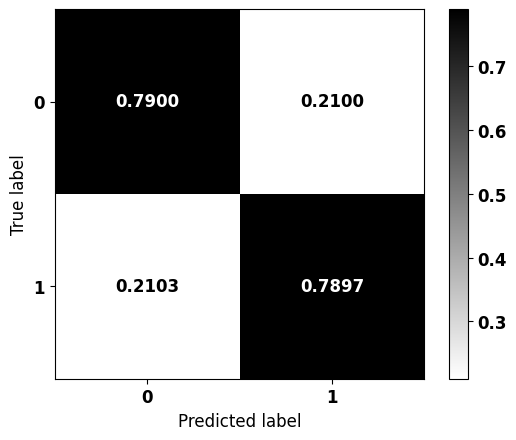


              precision    recall  f1-score   support

           0     0.4815    0.7900    0.5983      5180
           1     0.9383    0.7897    0.8576     20953

    accuracy                         0.7898     26133
   macro avg     0.7099    0.7898    0.7280     26133
weighted avg     0.8478    0.7898    0.8062     26133



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=0.2197,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

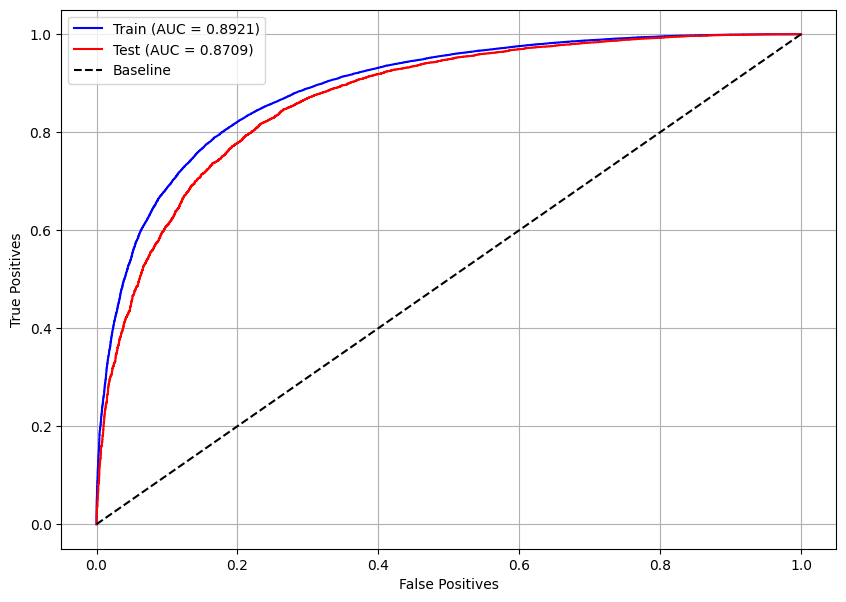

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

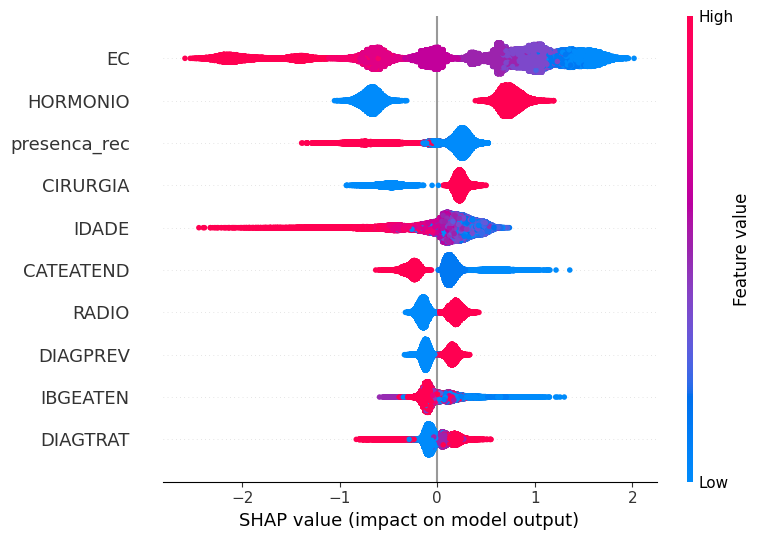

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 116,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 4,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.21, 0.24, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

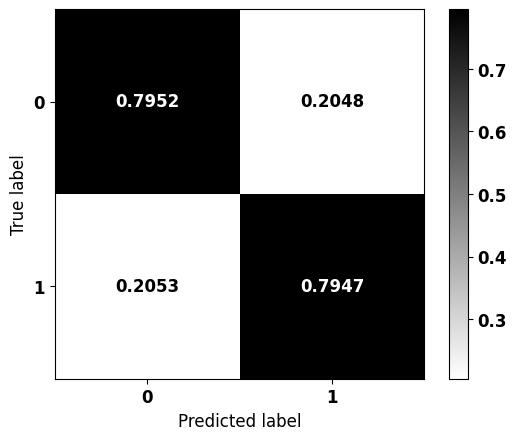


              precision    recall  f1-score   support

           0     0.4891    0.7952    0.6057      5180
           1     0.9401    0.7947    0.8613     20953

    accuracy                         0.7948     26133
   macro avg     0.7146    0.7949    0.7335     26133
weighted avg     0.8507    0.7948    0.8106     26133



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.2254

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

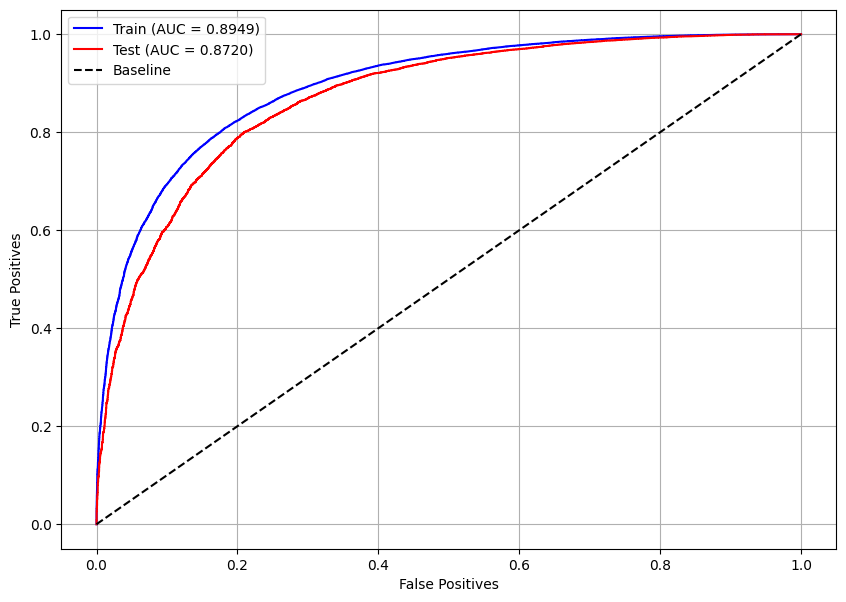

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 149,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.0,
 'min_child_weight': 2,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.21, 0.23, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

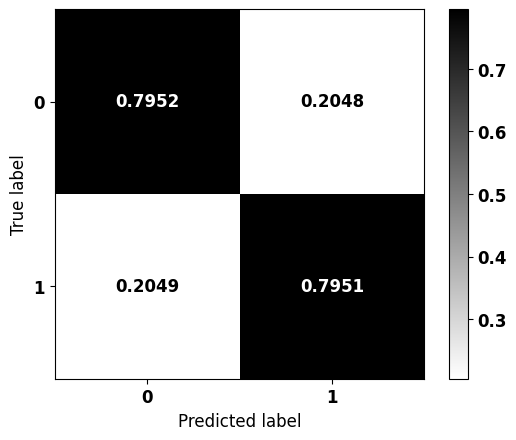


              precision    recall  f1-score   support

           0     0.4896    0.7952    0.6060      5180
           1     0.9401    0.7951    0.8615     20953

    accuracy                         0.7951     26133
   macro avg     0.7149    0.7951    0.7338     26133
weighted avg     0.8508    0.7951    0.8109     26133



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.2137

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

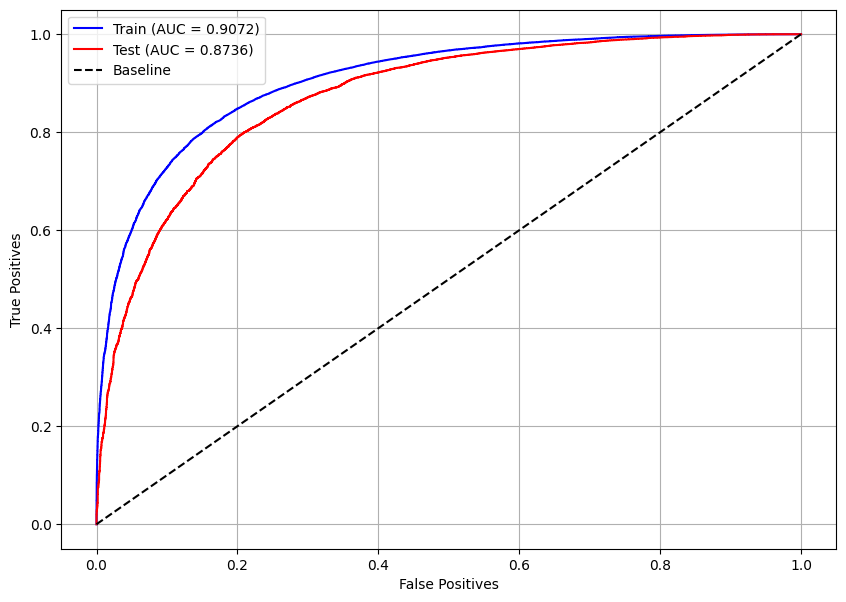

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 114,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.215, 0.23, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

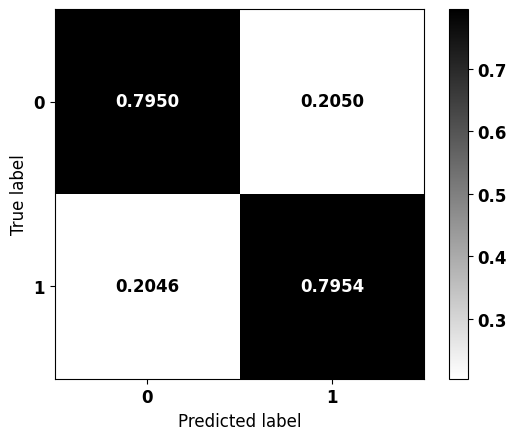


              precision    recall  f1-score   support

           0     0.4899    0.7950    0.6062      5180
           1     0.9401    0.7954    0.8617     20953

    accuracy                         0.7953     26133
   macro avg     0.7150    0.7952    0.7339     26133
weighted avg     0.8509    0.7953    0.8110     26133



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.2196

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

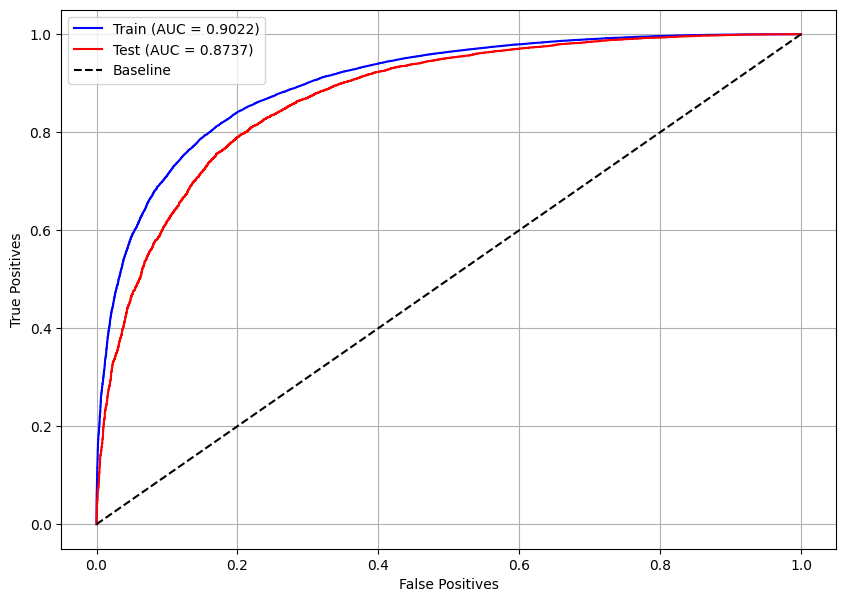

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15000000000000002,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=114, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


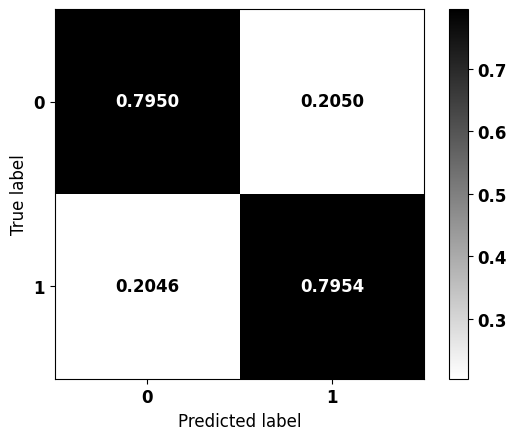


              precision    recall  f1-score   support

           0     0.4899    0.7950    0.6062      5180
           1     0.9401    0.7954    0.8617     20953

    accuracy                         0.7953     26133
   macro avg     0.7150    0.7952    0.7339     26133
weighted avg     0.8509    0.7953    0.8110     26133



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

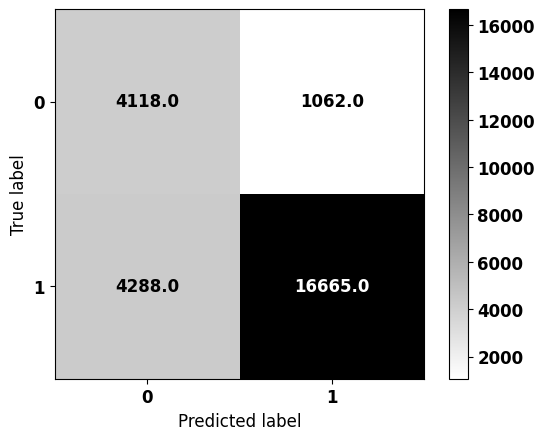


              precision    recall  f1-score   support

           0     0.4899    0.7950    0.6062      5180
           1     0.9401    0.7954    0.8617     20953

    accuracy                         0.7953     26133
   macro avg     0.7150    0.7952    0.7339     26133
weighted avg     0.8509    0.7953    0.8110     26133



In [ ]:
plot_confusion_matrix(xgb_optuna, X_test, y_test, norm=False)

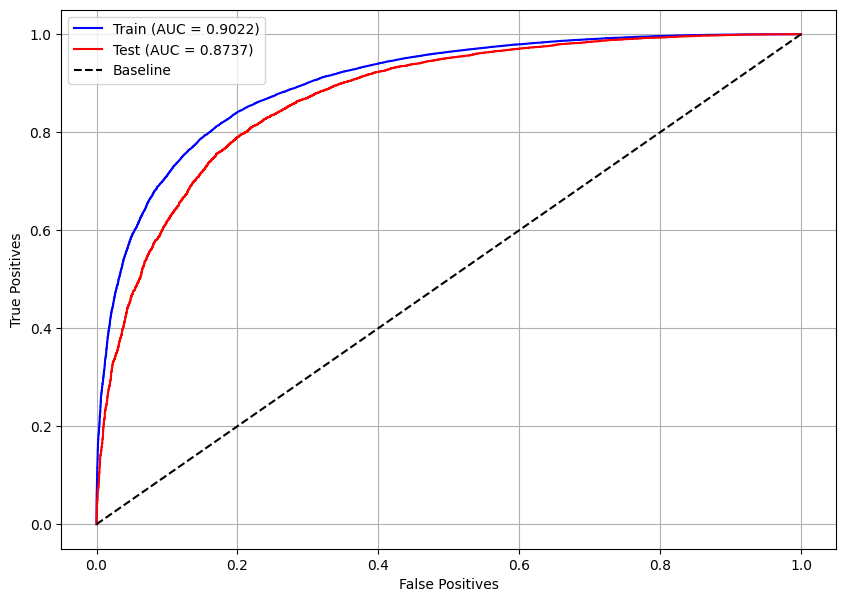

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

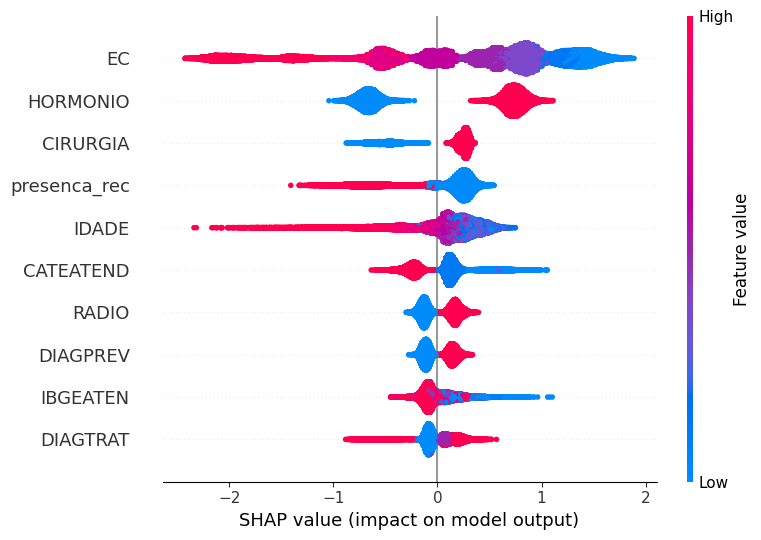

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

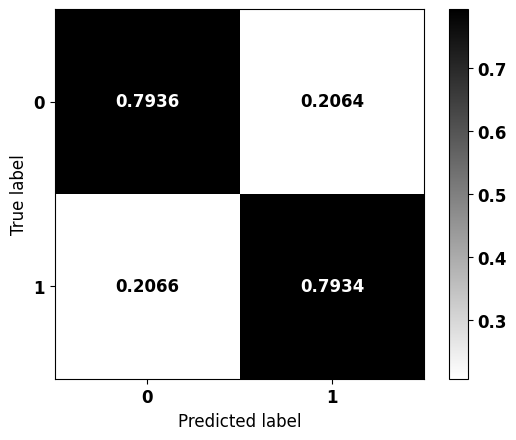


              precision    recall  f1-score   support

           0     0.4871    0.7936    0.6037      5180
           1     0.9396    0.7934    0.8603     20953

    accuracy                         0.7934     26133
   macro avg     0.7133    0.7935    0.7320     26133
weighted avg     0.8499    0.7934    0.8094     26133



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:4.44, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

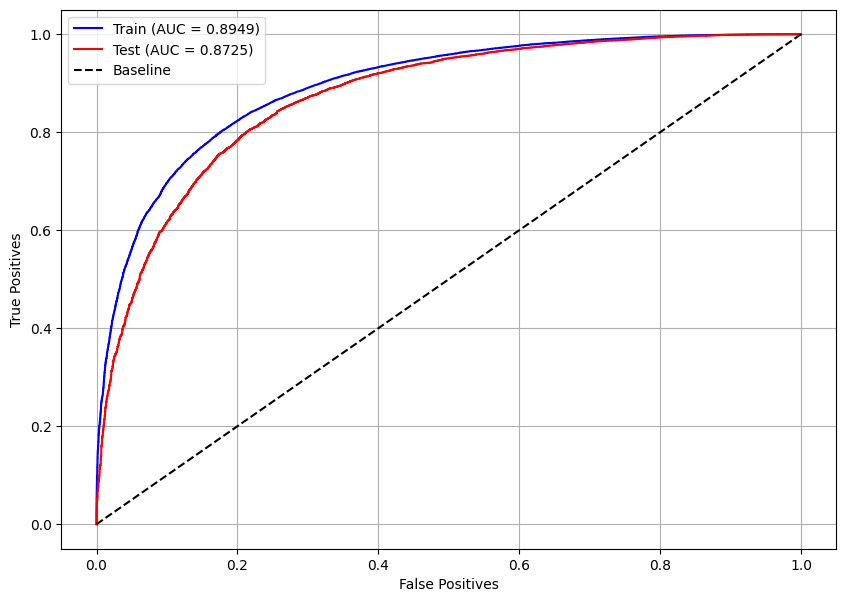

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


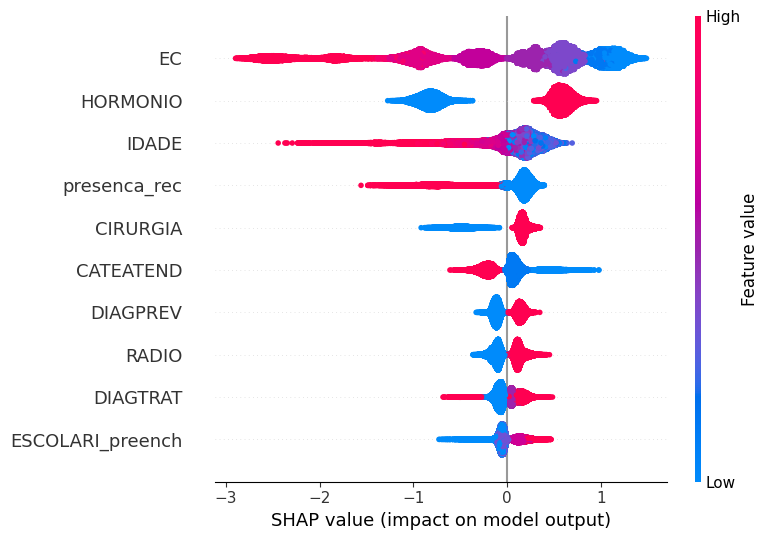

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 149,
 'max_depth': 7,
 'learning_rate': 0.09,
 'min_child_weight': 6,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(4.4, 4.55, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

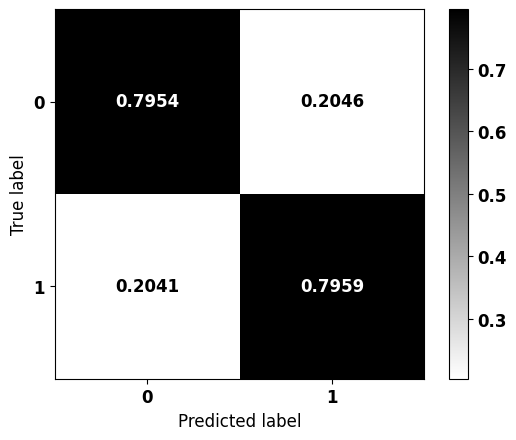


              precision    recall  f1-score   support

           0     0.4907    0.7954    0.6070      5180
           1     0.9402    0.7959    0.8621     20953

    accuracy                         0.7958     26133
   macro avg     0.7155    0.7956    0.7345     26133
weighted avg     0.8511    0.7958    0.8115     26133



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.41, 1:1}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

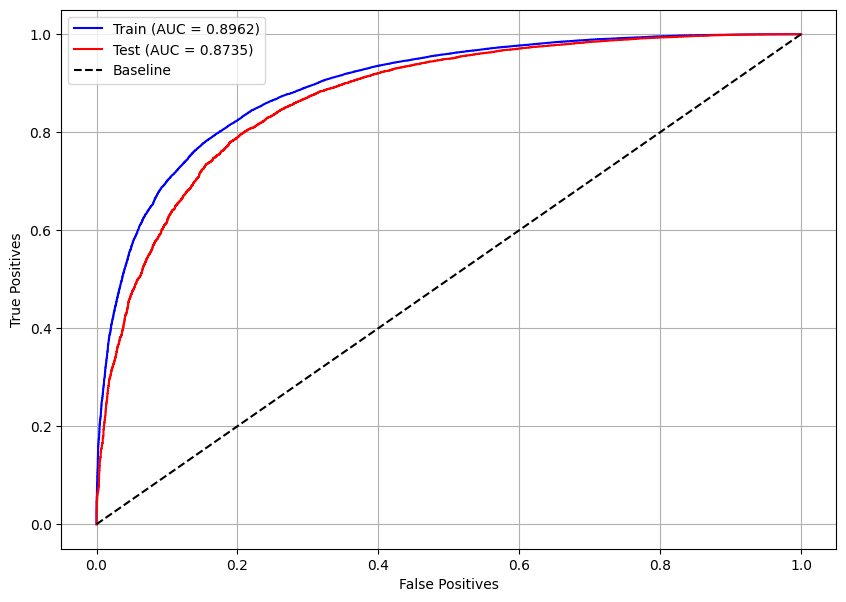

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 133,
 'max_depth': 7,
 'learning_rate': 0.14,
 'min_child_weight': 5,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(4.45, 4.65, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

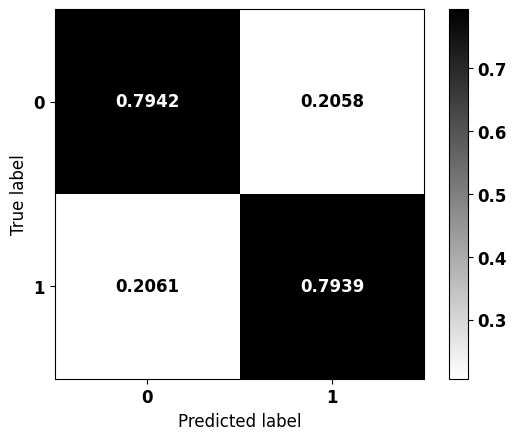


              precision    recall  f1-score   support

           0     0.4879    0.7942    0.6045      5180
           1     0.9398    0.7939    0.8607     20953

    accuracy                         0.7940     26133
   macro avg     0.7138    0.7941    0.7326     26133
weighted avg     0.8502    0.7940    0.8099     26133



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.485, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

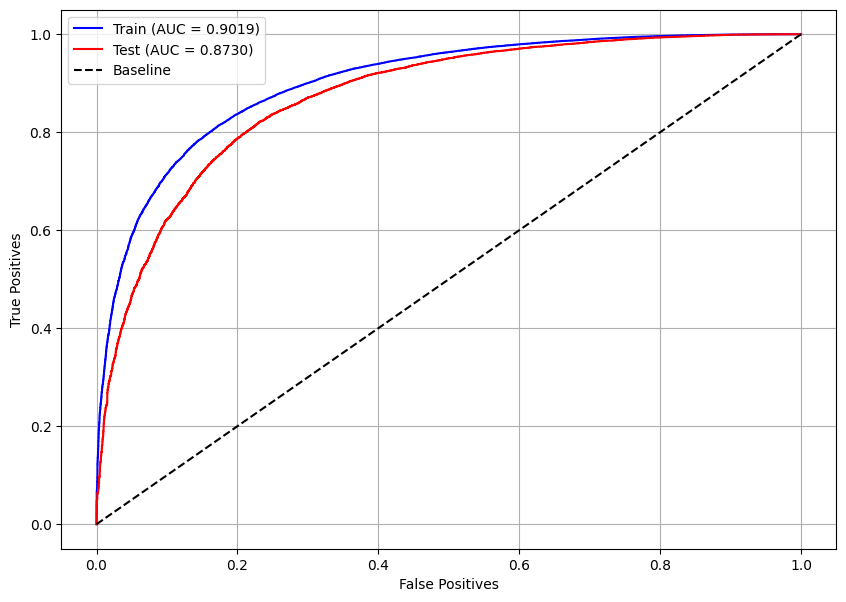

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 126,
 'max_depth': 8,
 'learning_rate': 0.16999999999999998,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(4.4, 4.6, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

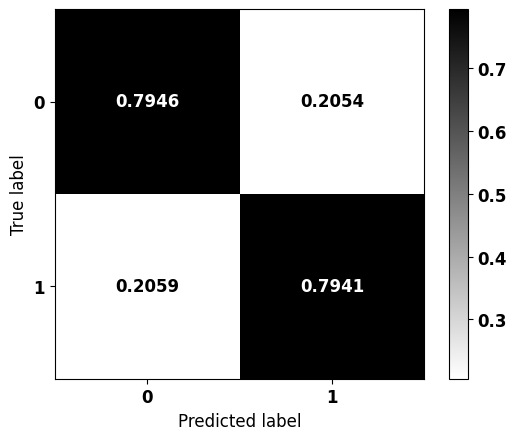


              precision    recall  f1-score   support

           0     0.4883    0.7946    0.6048      5180
           1     0.9399    0.7941    0.8609     20953

    accuracy                         0.7942     26133
   macro avg     0.7141    0.7944    0.7329     26133
weighted avg     0.8504    0.7942    0.8101     26133



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.532, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

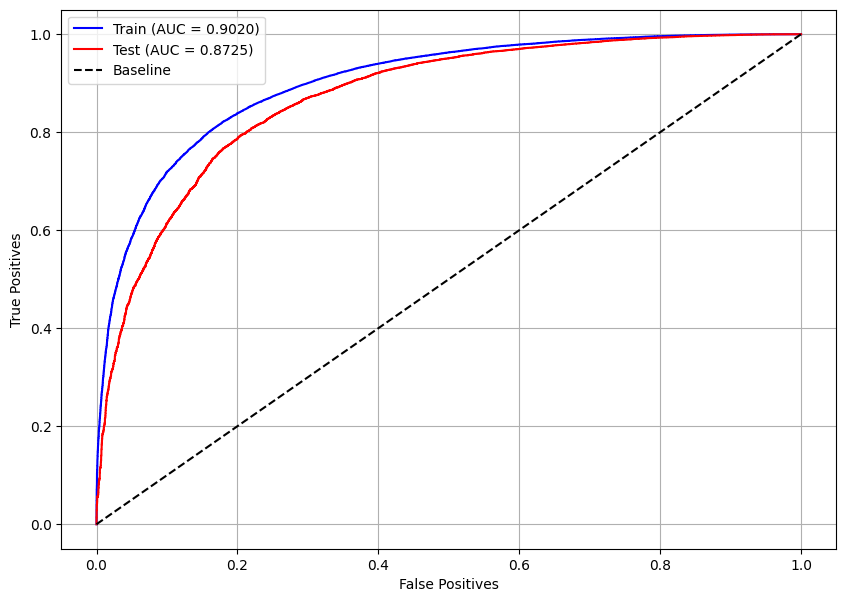

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 4.41, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.09, max_depth=7, min_child_weight=6,
               n_estimators=149, random_state=7, verbose=-1)


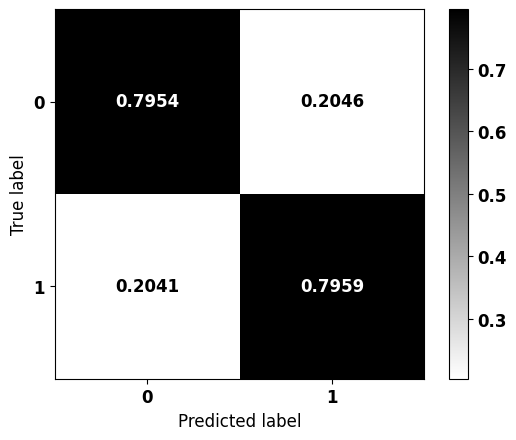


              precision    recall  f1-score   support

           0     0.4907    0.7954    0.6070      5180
           1     0.9402    0.7959    0.8621     20953

    accuracy                         0.7958     26133
   macro avg     0.7155    0.7956    0.7345     26133
weighted avg     0.8511    0.7958    0.8115     26133



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

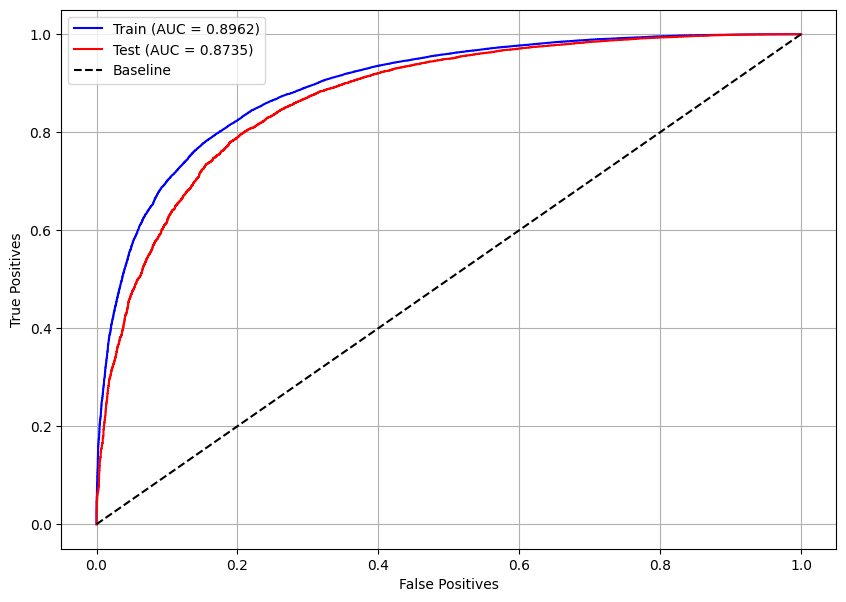

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

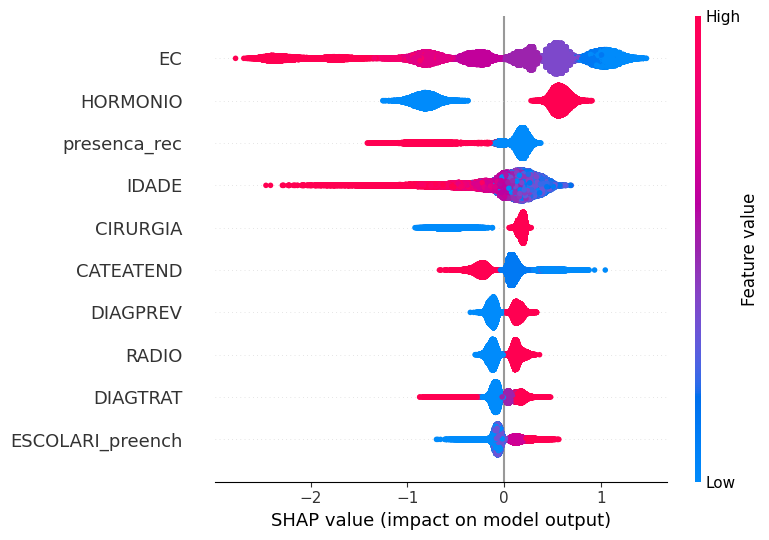

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7898, Optuna = 0.7953

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7934, Optuna = 0.7958

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 4.41, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.09, max_depth=7, min_child_weight=6,
               n_estimators=149, random_state=7, verbose=-1)

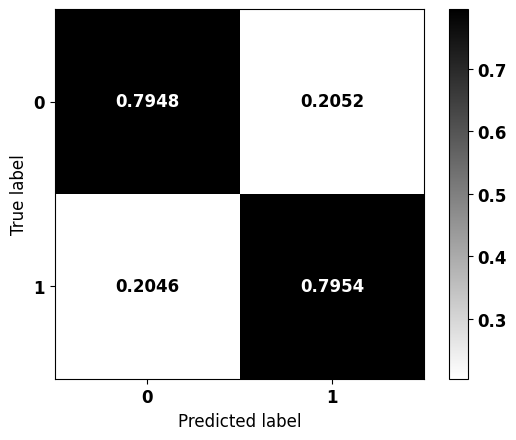


              precision    recall  f1-score   support

           0     0.4899    0.7948    0.6062      5180
           1     0.9400    0.7954    0.8617     20953

    accuracy                         0.7953     26133
   macro avg     0.7150    0.7951    0.7339     26133
weighted avg     0.8508    0.7953    0.8110     26133



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

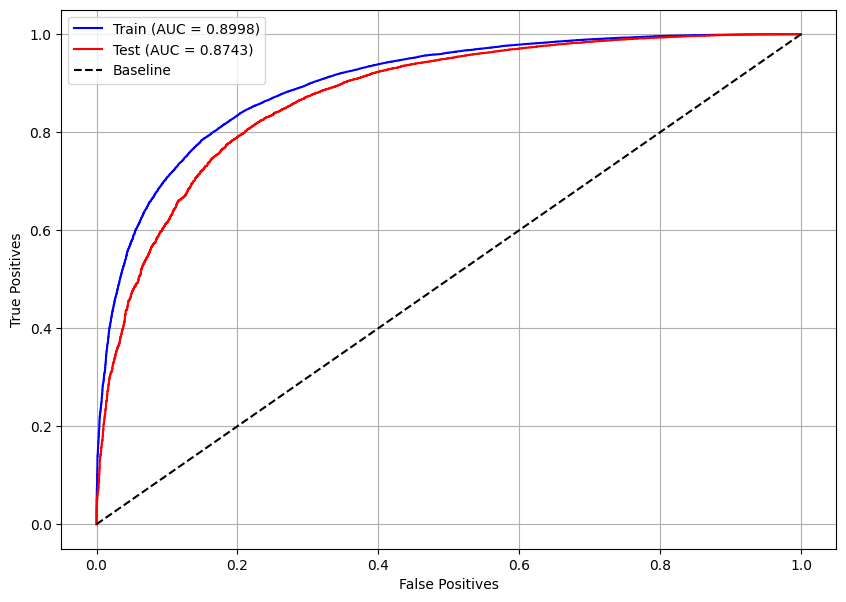

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 4.41, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.09, max_depth=7, min_child_weight=6,
               n_estimators=149, random_state=7, verbose=-1)


In [ ]:
# Dados para testar
!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF # Mais incidentes - Teste

df_teste = pd.read_csv('incid_teste.csv')

mama_teste = df_teste[df_teste.TOPOGRUP.isin(['Mama'])]
pele_teste = df_teste[df_teste.TOPOGRUP.isin(['Pele'])]
prost_teste = df_teste[df_teste.TOPOGRUP.isin(['Próstata'])]
colo_teste = df_teste[df_teste.TOPOGRUP.isin(['Colorretal'])]
pulm_teste = df_teste[df_teste.TOPOGRUP.isin(['Pulmão'])]
colo_utero_teste = df_teste[df_teste.TOPOGRUP.isin(['Colo de Útero'])]

mama_teste.shape, pele_teste.shape, prost_teste.shape, colo_teste.shape, pulm_teste.shape, colo_utero_teste.shape

### **Pele**

In [ ]:
saida_pele = pele_teste.sobrevida_3anos
pele_teste = pele_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pele_teste.shape)
pele_teste.head(3)

(25221, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
0 -3.596242  1.091681 -0.159568  -1.090962 -0.344597 -0.429061  0.315561   
1  0.776475 -0.916019  0.980231  -0.808623 -0.344597 -0.429061  0.315561   
2  0.248733 -0.916019  0.997129   1.167751 -0.344597 -0.429061  0.315561   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
0 -0.242155 -0.156064  -0.03833  ... -0.689569 -0.209410  0.048761  0.885900   
1 -0.242155 -0.156064  -0.03833  ... -0.689569 -0.155207  1.196545  1.436258   
2 -0.242155 -0.156064  -0.03833  ... -0.689569 -0.209410 -0.907725 -0.214815   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
0 -0.815017  1.073772  0.393904          1.588451           -0.776427   
1  0.636483  1.048108 -1.165675          2.585989            1.287951   
2 -0.234417 -1.110069 -1.165675         -0.406625           -0.776427   

   presenca_rec  
0     -0.218179  
1     -0.218179  
2     -0.218179  

[3 rows x 23 columns]

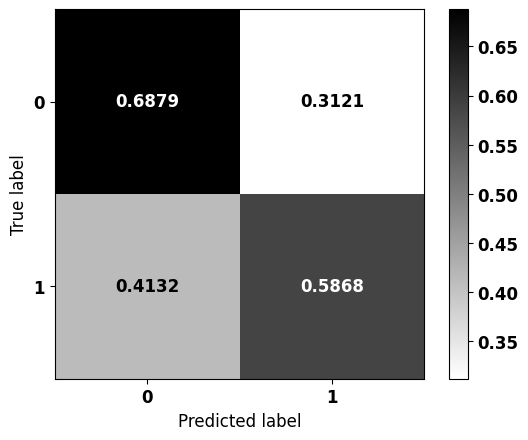


              precision    recall  f1-score   support

           0     0.3320    0.6879    0.4479      5799
           1     0.8629    0.5868    0.6985     19422

    accuracy                         0.6100     25221
   macro avg     0.5975    0.6373    0.5732     25221
weighted avg     0.7409    0.6100    0.6409     25221



In [ ]:
plot_confusion_matrix(best, pele_teste, saida_pele)

### **Próstata**

In [ ]:
saida_prost = prost_teste.sobrevida_3anos
prost_teste = prost_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(prost_teste.shape)
prost_teste.head(3)

(20862, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV       EC  CIRURGIA     RADIO  \
0 -0.767498   0.0 -0.121888  -0.695899  0.723032  0.27992  1.136845 -0.723672   
1  0.607604   0.0 -0.272041   1.379166  0.723032 -0.63168 -0.879627 -0.723672   
2  0.378421   0.0  0.986818  -0.695899  0.723032 -1.99908 -0.879627  1.381841   

     QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS      RRAS  \
0 -0.308078 -0.920818  ... -0.418644 -0.208982  0.841591  0.740489  0.331500   
1  3.245926  1.085991  ... -0.418644 -0.253622 -1.527219  0.386447  0.093007   
2 -0.308078 -0.920818  ... -0.418644 -0.253622  0.841591  1.271552  1.285474   

   IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  presenca_rec  
0 -0.575242  0.451912         -0.714113           -0.906043     -0.414926  
1 -0.365178 -0.971798         -0.714113            1.103700      2.410066  
2  0.774273 -0.971798         -0.714113           -0.906043     -0.414926  

[3 rows x 23 columns]

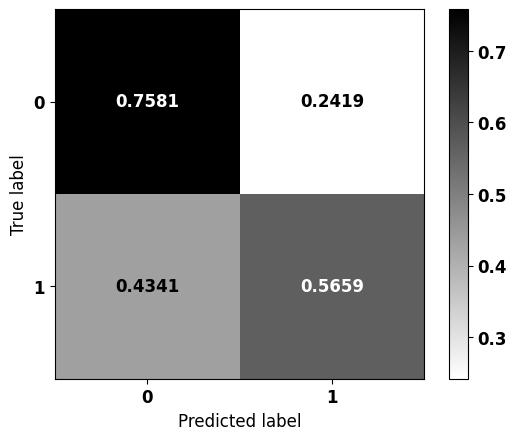


              precision    recall  f1-score   support

           0     0.2517    0.7581    0.3779      3369
           1     0.9239    0.5659    0.7019     17493

    accuracy                         0.5970     20862
   macro avg     0.5878    0.6620    0.5399     20862
weighted avg     0.8154    0.5970    0.6496     20862



In [ ]:
plot_confusion_matrix(best, prost_teste, saida_prost)

### **Colorretal**

In [ ]:
saida_colo = colo_teste.sobrevida_3anos
colo_teste = colo_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_teste.shape)
colo_teste.head(3)

(14028, 23)


IDADE      SEXO     IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
0  0.138324 -0.972134 -1.59744  -0.714301 -1.043802  1.054160   0.60093   
1 -1.232704  1.028664 -1.37191   1.343451  0.958036 -1.149243   0.60093   
2 -0.928032 -0.972134  0.86381  -0.714301  0.958036  1.329585   0.60093   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
0 -0.567847  0.737288  -0.07854  ... -0.325938 -0.242469 -1.543709 -0.032782   
1  1.761039  0.737288  -0.07854  ... -0.325938 -0.242469 -1.734289 -0.032782   
2 -0.567847  0.737288  -0.07854  ... -0.325938 -0.242469  0.552669 -0.032782   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
0 -0.046564 -1.604338  -0.96885          2.206391            0.964441   
1 -0.046564 -1.604338  -0.96885         -0.870779           -1.036870   
2 -0.046564 -1.604338  -0.96885          1.180668           -1.036870   

   presenca_rec  
0     -0.475073  
1      2.104938  
2      2.104938  

[3 rows x 23 columns]

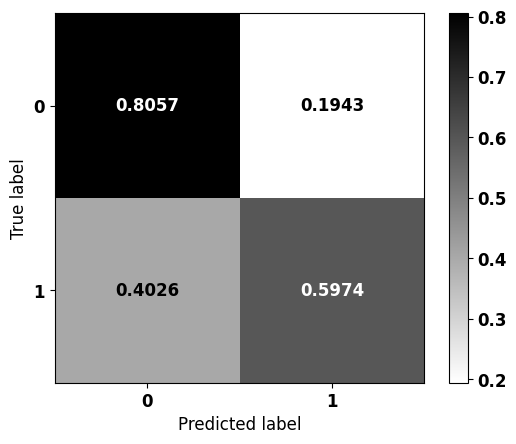


              precision    recall  f1-score   support

           0     0.6182    0.8057    0.6996      6273
           1     0.7917    0.5974    0.6810      7755

    accuracy                         0.6905     14028
   macro avg     0.7049    0.7015    0.6903     14028
weighted avg     0.7141    0.6905    0.6893     14028



In [ ]:
plot_confusion_matrix(best, colo_teste, saida_colo)

### **Pulmão**

In [ ]:
saida_pulm = pulm_teste.sobrevida_3anos
pulm_teste = pulm_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pulm_teste.shape)
pulm_teste.head(3)

(9252, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
0  0.402559  1.284999  0.646501  -0.853227  1.364883  0.640728 -0.468319   
1  1.146017 -0.778211 -1.764593   1.133388  1.364883  0.640728 -0.468319   
2 -0.712628 -0.778211  0.442781   1.133388  1.364883  0.640728 -0.468319   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
0 -0.748999  0.748999 -0.070691  ... -0.403143 -0.459489  0.484112 -0.479773   
1 -0.748999 -1.335116 -0.070691  ... -0.403143  2.229491 -1.310719 -0.112762   
2 -0.748999  0.748999 -0.070691  ... -0.403143 -0.459489 -0.592787  1.355278   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
0  0.959158 -1.829146 -1.225737         -1.825233           -1.027214   
1  0.959158 -1.703385  0.238090         -0.775222            0.973507   
2  0.959158  0.376280 -1.225737         -0.775222            0.973507   

   presenca_rec  
0     -0.407845  
1     -0.407845  
2      2.451912  

[3 rows x 23 columns]

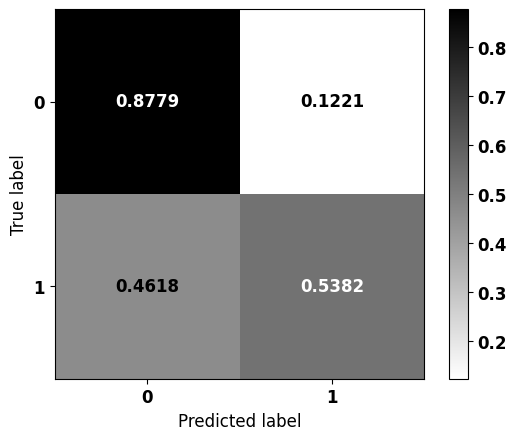


              precision    recall  f1-score   support

           0     0.9244    0.8779    0.9005      8007
           1     0.4066    0.5382    0.4632      1245

    accuracy                         0.8321      9252
   macro avg     0.6655    0.7080    0.6819      9252
weighted avg     0.8547    0.8321    0.8417      9252



In [ ]:
plot_confusion_matrix(best, pulm_teste, saida_pulm)

### **Colo de Útero**

In [ ]:
saida_colo_utero = colo_utero_teste.sobrevida_3anos
colo_utero_teste = colo_utero_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_utero_teste.shape)
colo_utero_teste.head(3)

(5368, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
0 -0.364081   0.0  1.074677  -0.892955  0.909436 -1.963211 -0.793676   
1  0.315314   0.0  0.929895   1.105189 -1.099583 -1.114731  1.259960   
2  0.519132   0.0  0.929895  -0.892955 -1.099583  0.157990 -0.793676   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
0  0.741156  1.071484 -0.087376  ... -0.292508 -0.175532  1.459891 -0.892417   
1  0.741156 -0.933285 -0.087376  ...  1.856197 -0.269490  0.413337 -0.892417   
2  0.741156  1.071484 -0.087376  ... -0.292508 -0.269490  0.413337 -0.892417   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
0 -1.162118  0.814678 -0.999734         -0.614620           -0.918477   
1 -0.710476  0.814678  0.639879         -0.614620            1.088759   
2 -0.710476  0.814678  0.639879          0.439108            1.088759   

   presenca_rec  
0     -0.459887  
1     -0.459887  
2     -0.459887  

[3 rows x 23 columns]

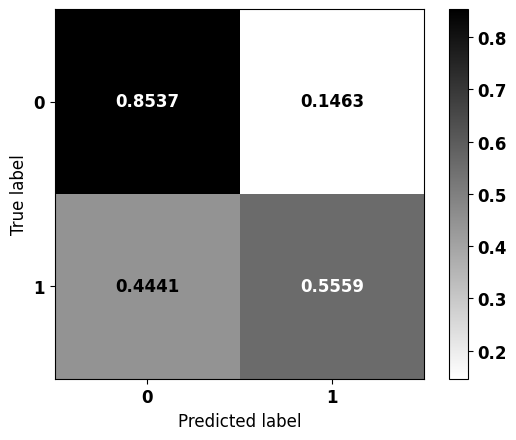


              precision    recall  f1-score   support

           0     0.5922    0.8537    0.6993      2310
           1     0.8342    0.5559    0.6672      3058

    accuracy                         0.6841      5368
   macro avg     0.7132    0.7048    0.6832      5368
weighted avg     0.7300    0.6841    0.6810      5368



In [ ]:
plot_confusion_matrix(best, colo_utero_teste, saida_colo_utero)

# **Pele**

In [ ]:
# Leitura dos dados de pele
print(df_pele.shape)
df_pele.head(3)

(100884, 32)


IDADE  SEXO     IBGE  CATEATEND  DIAGPREV  TOPO TOPOGRUP    EC TRATHOSP  \
0     42     1  3518701          9         2  C446      C44  IIIC        G   
1     43     2  3548708          9         1  C449      C44  IIIC        C   
2     31     2  3518701          2         2  C449      C44    IV        C   

   NENHUM  ...  RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  \
0       0  ...     7   3518701         1               3.0   
1       0  ...     1   3518701         1               4.0   
2       0  ...     7   3518701         1               3.0   

   IBGE_idem_IBGEATEN  presenca_rec  obito_geral  sobrevida_ano1  \
0                   1             0            1               0   
1                   0             0            1               1   
2                   1             0            1               0   

   sobrevida_ano3  sobrevida_ano5  
0               0               0  
1               0               0  
2               0               0  

[3 rows x 32 columns]

In [ ]:
# Valores faltantes
df_pele.isna().sum().sort_values(ascending=False).head(6)

DRS               1
IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
dtype: int64

In [ ]:
df_pele.dropna(inplace=True)
df_pele.shape

(100883, 32)

In [ ]:
# Correlação com a saída
corr_matrix = df_pele.corr(numeric_only=True)
abs(corr_matrix['sobrevida_ano3']).sort_values(ascending=False).head(20)

sobrevida_ano3      1.000000
sobrevida_ano5      0.568726
sobrevida_ano1      0.543767
obito_geral         0.503614
IDADE               0.238782
QUIMIO              0.128731
ANODIAG             0.103983
ESCOLARI_preench    0.102245
CIRURGIA            0.093976
DIAGTRAT            0.083850
TRATCONS            0.083574
NENHUM              0.083239
RADIO               0.069108
presenca_rec        0.050478
HABILIT2            0.042319
SEXO                0.030850
DIAGPREV            0.029932
DRS                 0.027130
RRAS                0.026648
IBGEATEN            0.021207
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_pele.sobrevida_ano3.value_counts()

1    77687
0    23196
Name: sobrevida_ano3, dtype: int64

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_pele,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (75662, 23), X_test = (25221, 23)
y_train = (75662,), y_test = (25221,)


In [ ]:
y_train.value_counts(normalize=True)

1    0.77007
0    0.22993
Name: sobrevida_ano3, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.770073
0    0.229927
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Dataset de treinamento de Pele
pele_treino = pd.DataFrame(X_train, columns=feat_cols)
pele_treino['TOPOGRUP'] = 'Pele'
pele_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Pele
pele_teste = pd.DataFrame(X_test, columns=feat_cols)
pele_teste['TOPOGRUP'] = 'Pele'
pele_teste['sobrevida_3anos'] = y_test.values

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

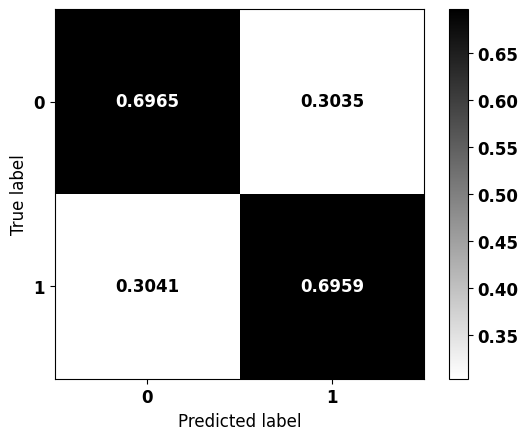


              precision    recall  f1-score   support

           0     0.4061    0.6965    0.5131      5799
           1     0.8848    0.6959    0.7790     19422

    accuracy                         0.6960     25221
   macro avg     0.6454    0.6962    0.6460     25221
weighted avg     0.7747    0.6960    0.7179     25221



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=0.282,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

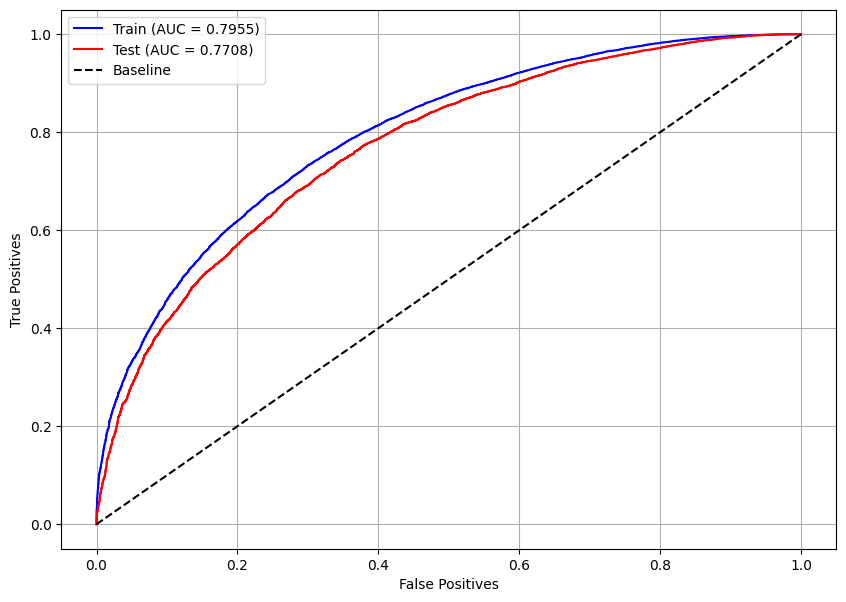

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

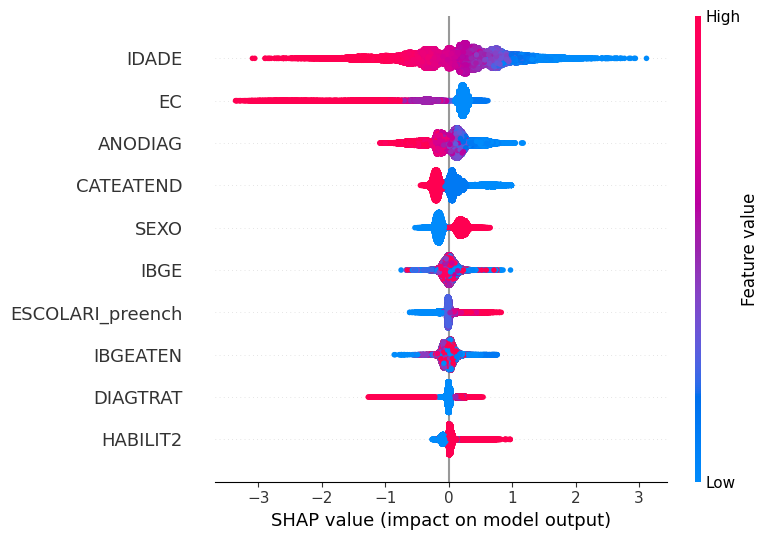

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 131,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 7,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.27, 0.3, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

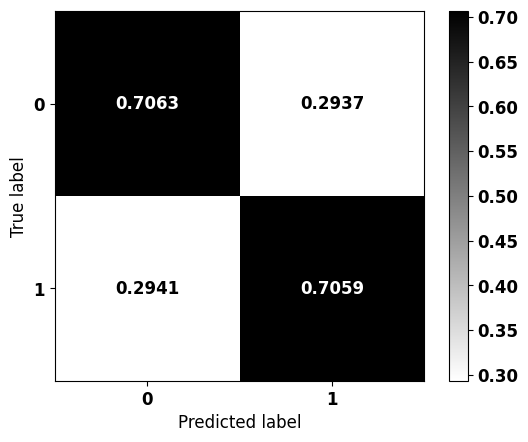


              precision    recall  f1-score   support

           0     0.4176    0.7063    0.5249      5799
           1     0.8895    0.7059    0.7871     19422

    accuracy                         0.7060     25221
   macro avg     0.6536    0.7061    0.6560     25221
weighted avg     0.7810    0.7060    0.7268     25221



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.2792

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

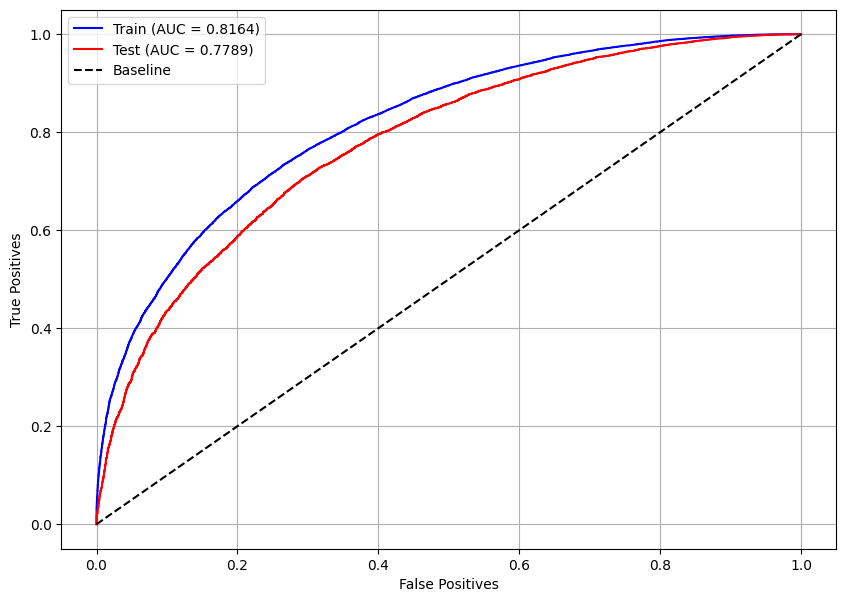

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 141,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 4,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.27, 0.29, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

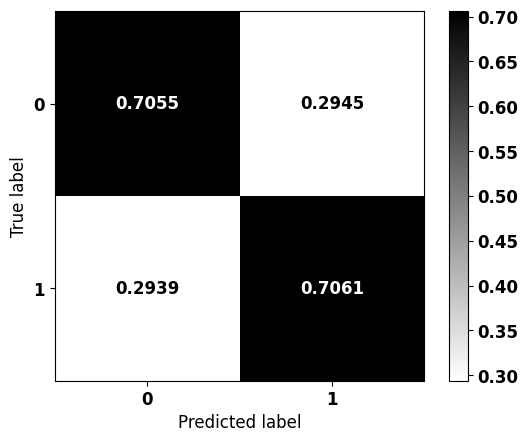


              precision    recall  f1-score   support

           0     0.4174    0.7055    0.5245      5799
           1     0.8892    0.7061    0.7871     19422

    accuracy                         0.7059     25221
   macro avg     0.6533    0.7058    0.6558     25221
weighted avg     0.7808    0.7059    0.7267     25221



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.2774

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

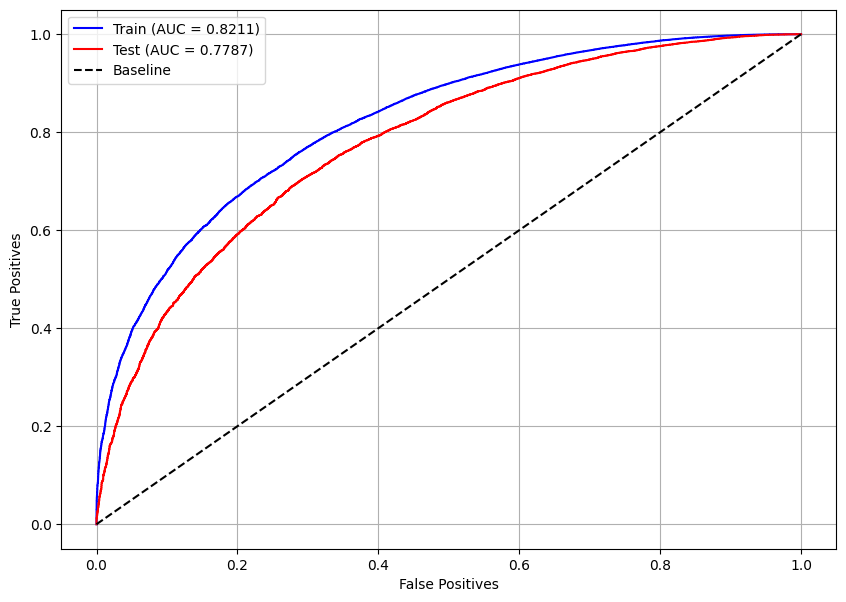

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 136,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 4,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(0.27, 0.29, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

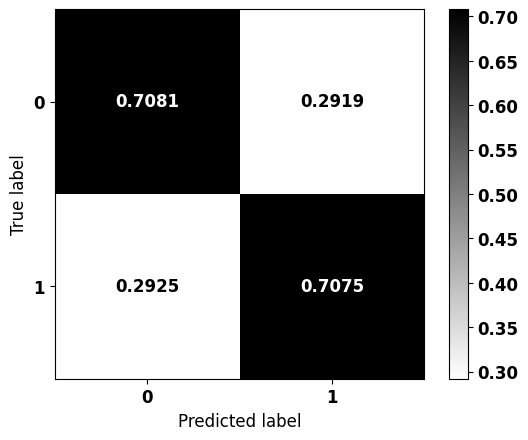


              precision    recall  f1-score   support

           0     0.4195    0.7081    0.5269      5799
           1     0.8903    0.7075    0.7884     19422

    accuracy                         0.7076     25221
   macro avg     0.6549    0.7078    0.6577     25221
weighted avg     0.7821    0.7076    0.7283     25221



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.2773

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

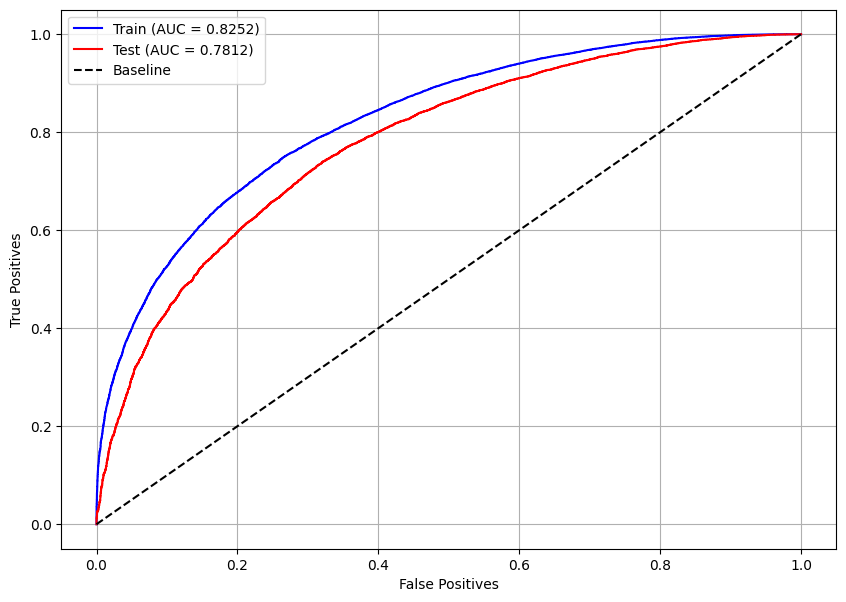

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=136, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


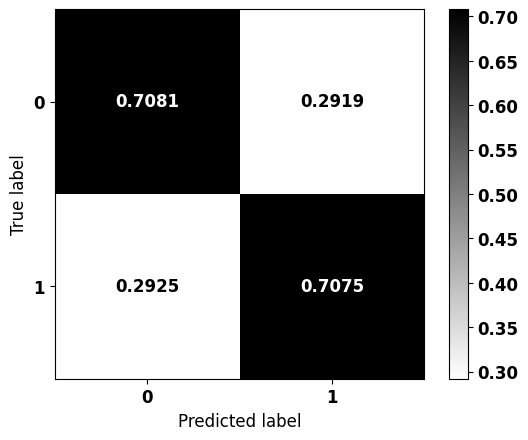


              precision    recall  f1-score   support

           0     0.4195    0.7081    0.5269      5799
           1     0.8903    0.7075    0.7884     19422

    accuracy                         0.7076     25221
   macro avg     0.6549    0.7078    0.6577     25221
weighted avg     0.7821    0.7076    0.7283     25221



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

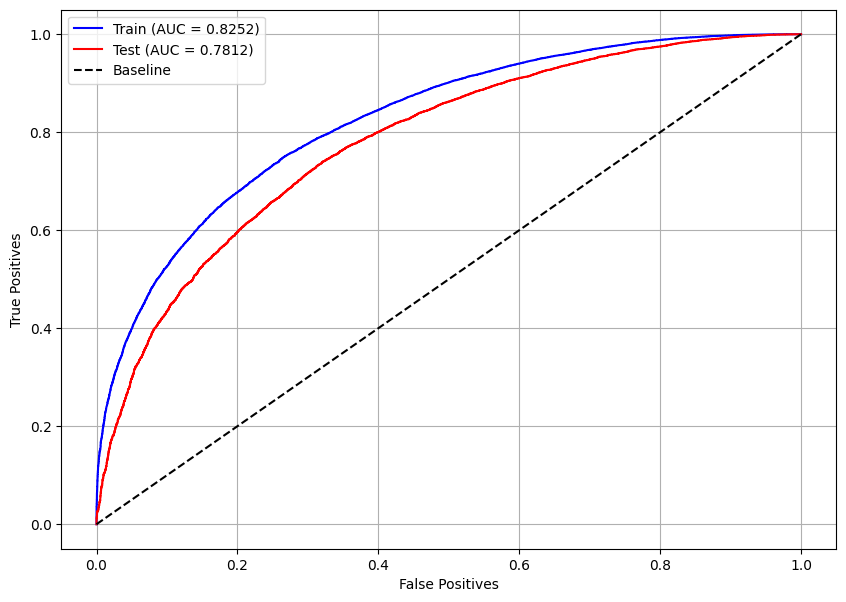

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

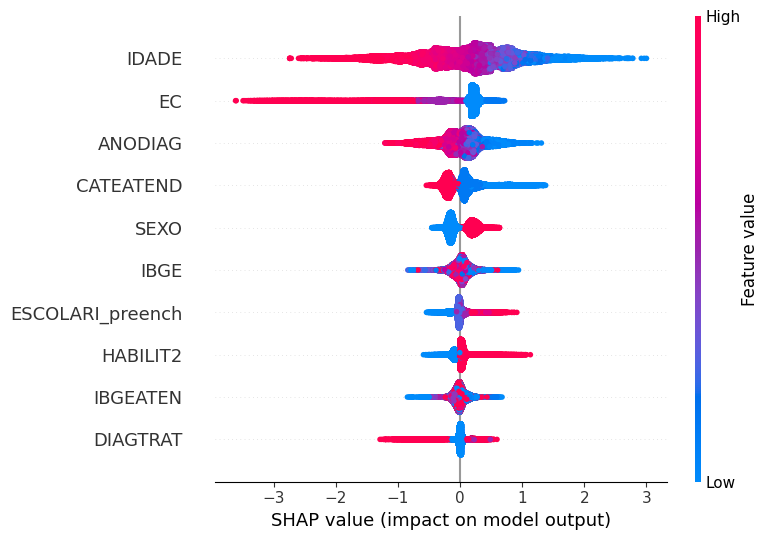

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

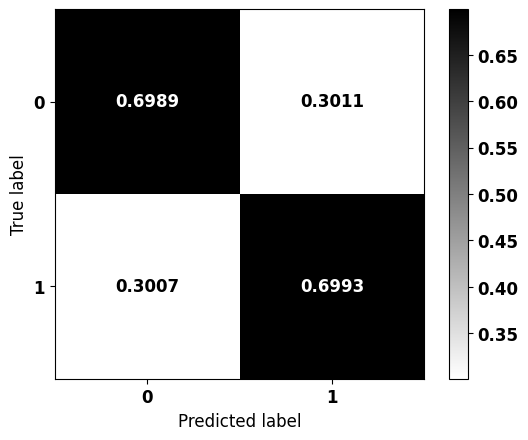


              precision    recall  f1-score   support

           0     0.4096    0.6989    0.5165      5799
           1     0.8861    0.6993    0.7817     19422

    accuracy                         0.6992     25221
   macro avg     0.6479    0.6991    0.6491     25221
weighted avg     0.7765    0.6992    0.7207     25221



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:3.47, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

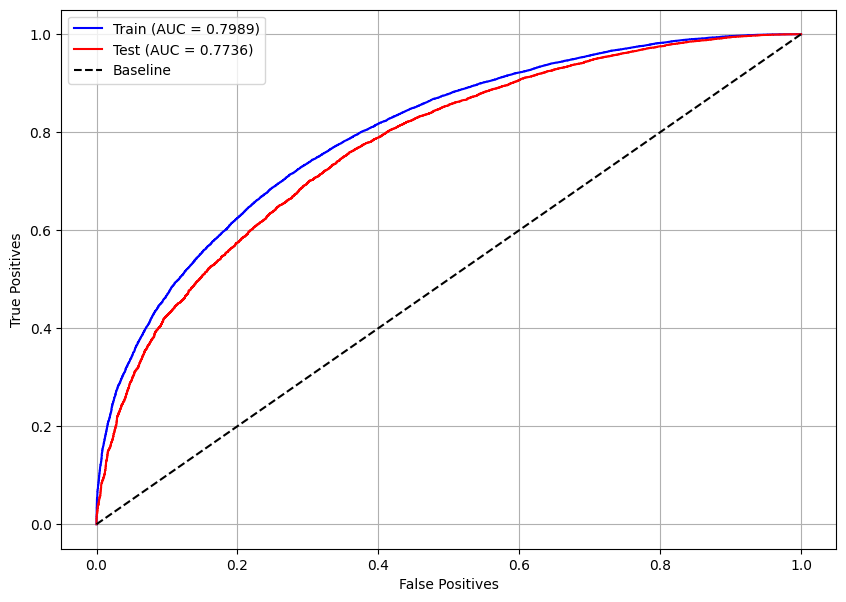

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


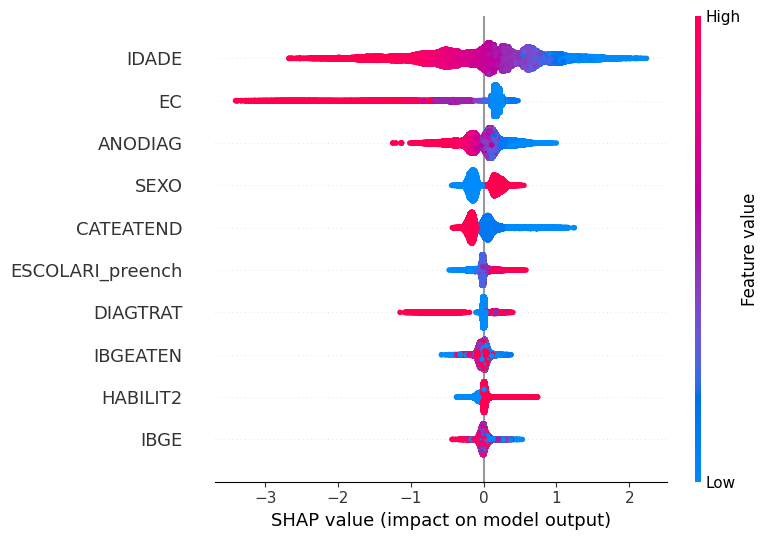

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 138,
 'max_depth': 10,
 'learning_rate': 0.2,
 'min_child_weight': 7,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(3.51, 3.56, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

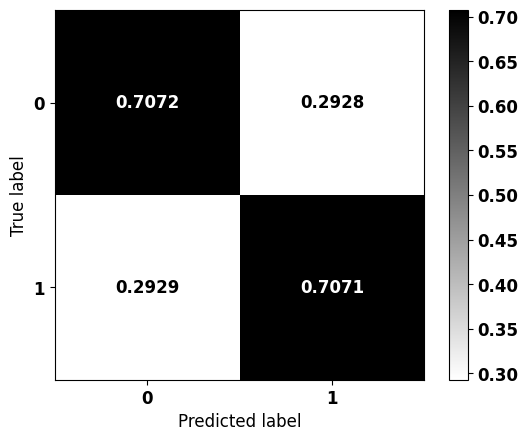


              precision    recall  f1-score   support

           0     0.4189    0.7072    0.5262      5799
           1     0.8900    0.7071    0.7881     19422

    accuracy                         0.7071     25221
   macro avg     0.6545    0.7072    0.6571     25221
weighted avg     0.7817    0.7071    0.7279     25221



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:3.5368, 1:1}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

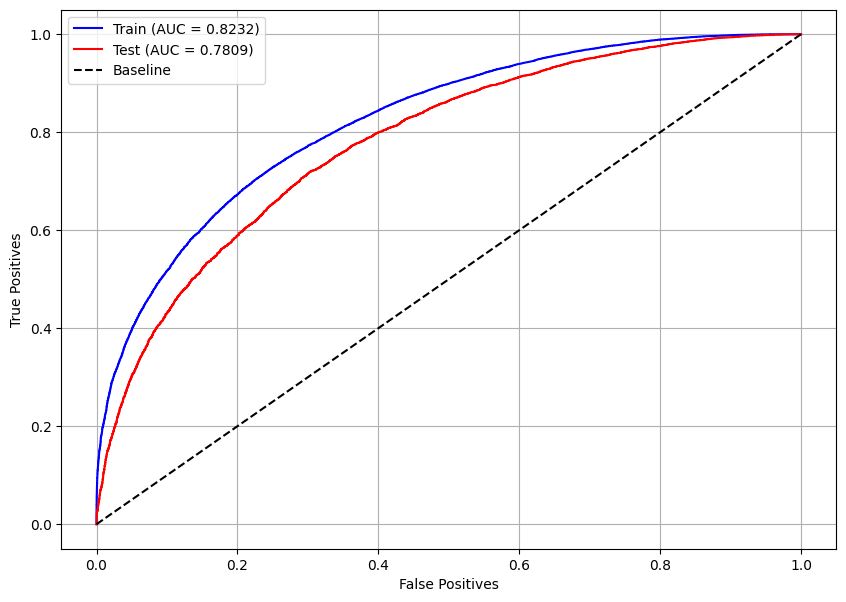

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 143,
 'max_depth': 9,
 'learning_rate': 0.2,
 'min_child_weight': 1,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(3.53, 3.56, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

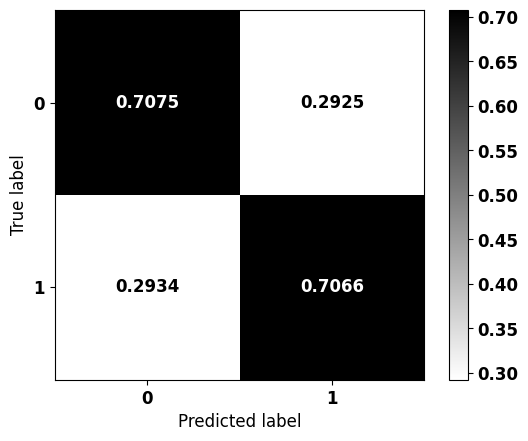


              precision    recall  f1-score   support

           0     0.4186    0.7075    0.5260      5799
           1     0.8900    0.7066    0.7878     19422

    accuracy                         0.7068     25221
   macro avg     0.6543    0.7071    0.6569     25221
weighted avg     0.7816    0.7068    0.7276     25221



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:3.5489, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

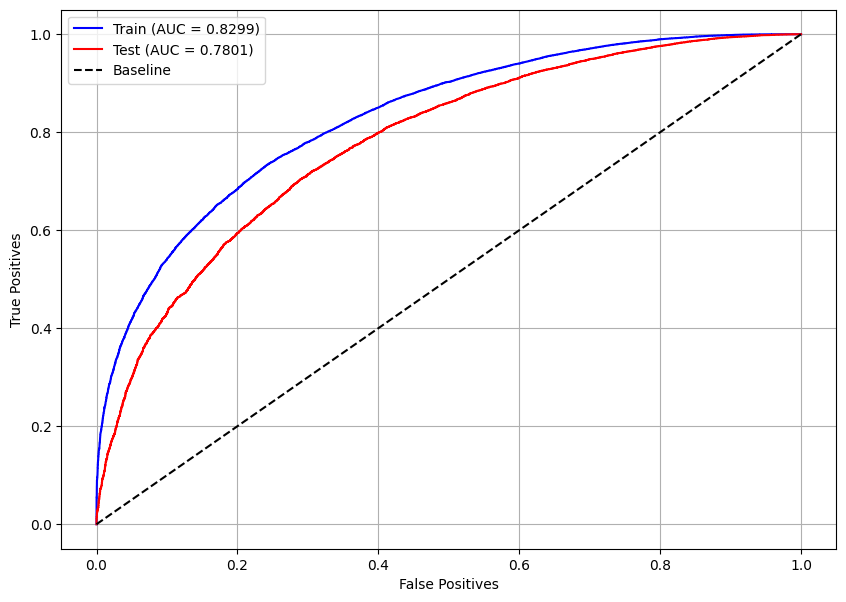

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 150,
 'max_depth': 10,
 'learning_rate': 0.16999999999999998,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(3.49, 3.53, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

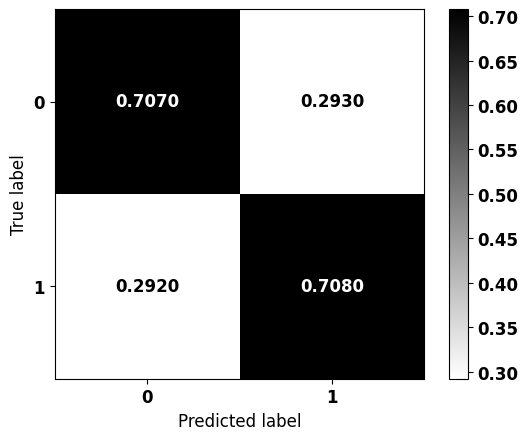


              precision    recall  f1-score   support

           0     0.4196    0.7070    0.5266      5799
           1     0.8900    0.7080    0.7886     19422

    accuracy                         0.7077     25221
   macro avg     0.6548    0.7075    0.6576     25221
weighted avg     0.7819    0.7077    0.7284     25221



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:3.5183, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

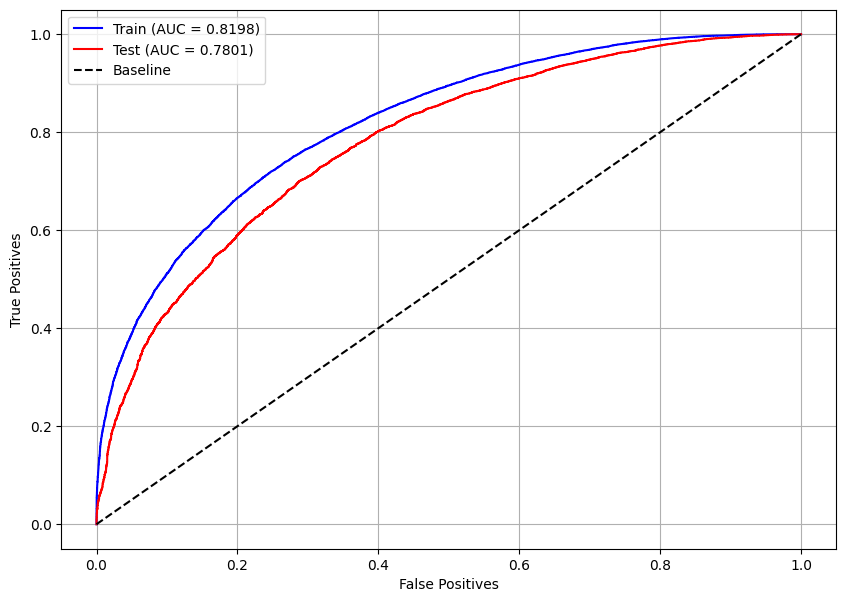

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 3.5183, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.16999999999999998, max_depth=10,
               min_child_weight=5, n_estimators=150, random_state=7,
               verbose=-1)


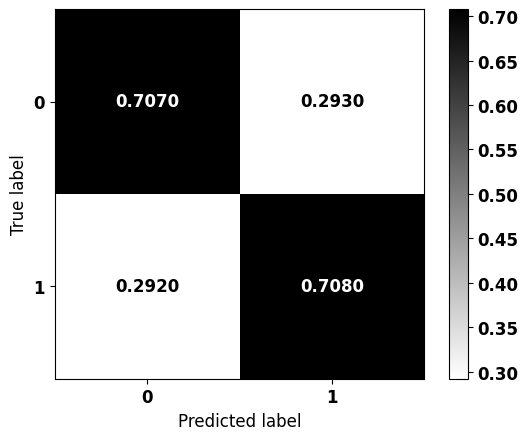


              precision    recall  f1-score   support

           0     0.4196    0.7070    0.5266      5799
           1     0.8900    0.7080    0.7886     19422

    accuracy                         0.7077     25221
   macro avg     0.6548    0.7075    0.6576     25221
weighted avg     0.7819    0.7077    0.7284     25221



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

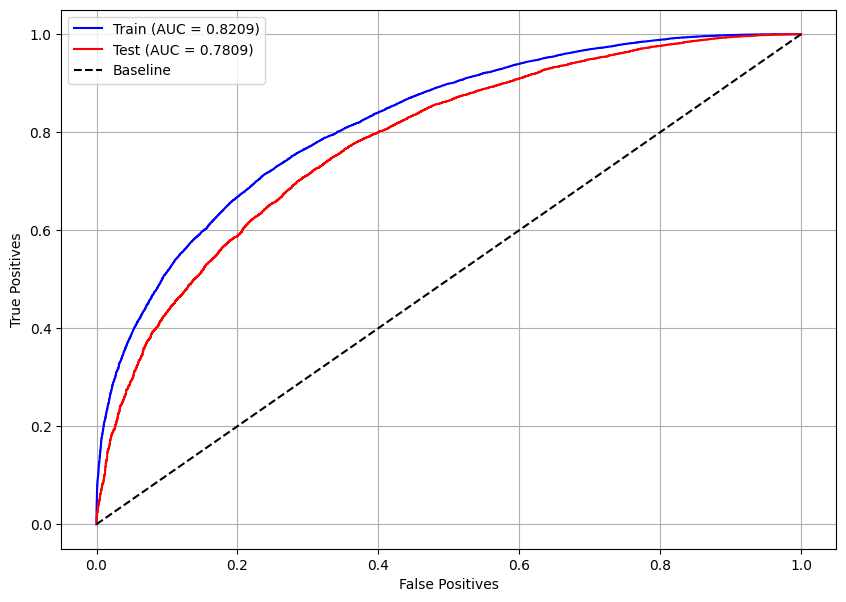

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

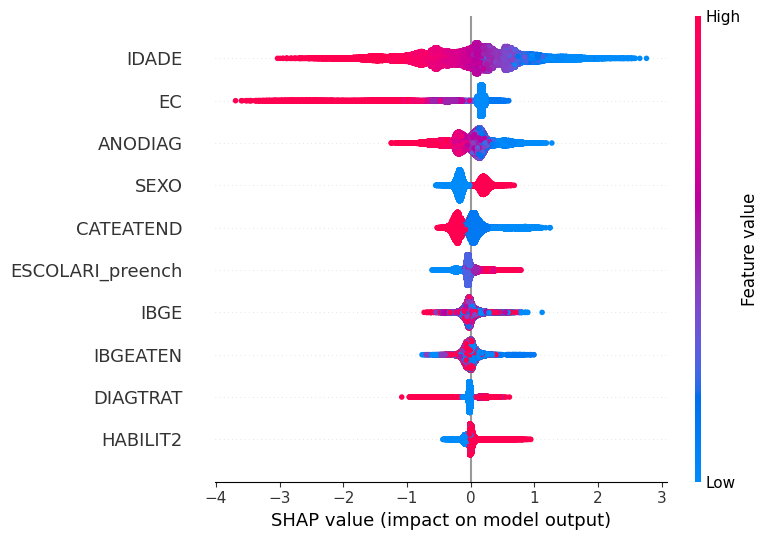

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.6960, Optuna = 0.7076

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.6992, Optuna = 0.7077

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 3.5183, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.16999999999999998, max_depth=10,
               min_child_weight=5, n_estimators=150, random_state=7,
               verbose=-1)

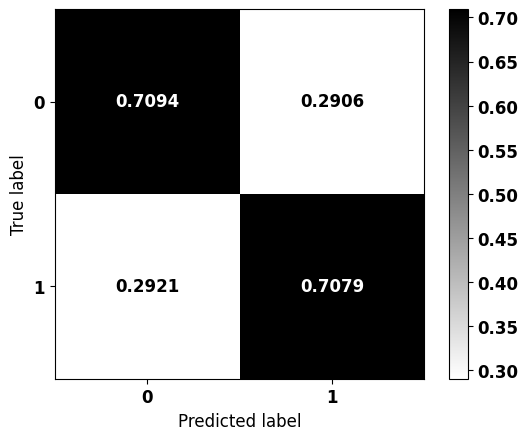


              precision    recall  f1-score   support

           0     0.4203    0.7094    0.5279      5799
           1     0.8908    0.7079    0.7889     19422

    accuracy                         0.7082     25221
   macro avg     0.6556    0.7086    0.6584     25221
weighted avg     0.7826    0.7082    0.7289     25221



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

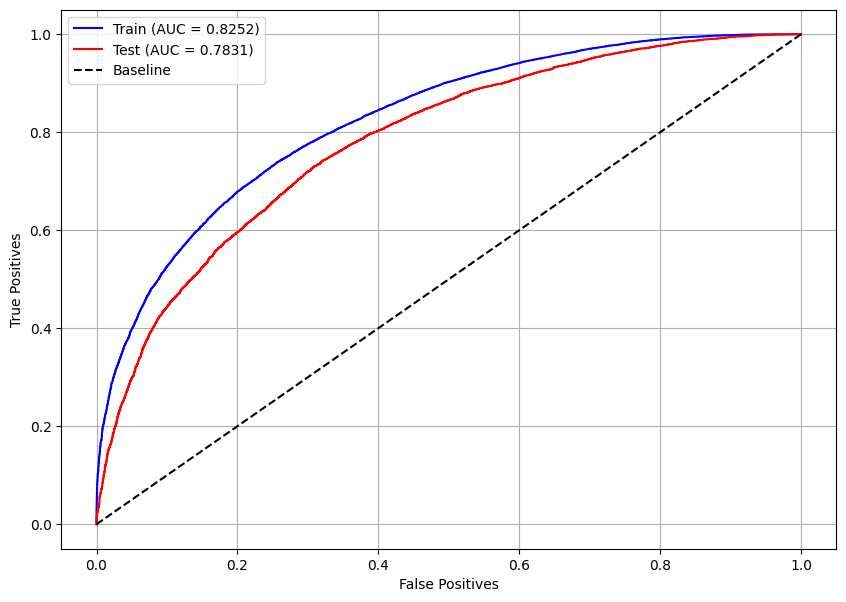

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 3.5183, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.16999999999999998, max_depth=10,
               min_child_weight=5, n_estimators=150, random_state=7,
               verbose=-1)


In [ ]:
# Dados para testar
!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF # Mais incidentes - Teste

df_teste = pd.read_csv('incid_teste.csv')

mama_teste = df_teste[df_teste.TOPOGRUP.isin(['Mama'])]
pele_teste = df_teste[df_teste.TOPOGRUP.isin(['Pele'])]
prost_teste = df_teste[df_teste.TOPOGRUP.isin(['Próstata'])]
colo_teste = df_teste[df_teste.TOPOGRUP.isin(['Colorretal'])]
pulm_teste = df_teste[df_teste.TOPOGRUP.isin(['Pulmão'])]
colo_utero_teste = df_teste[df_teste.TOPOGRUP.isin(['Colo de Útero'])]

mama_teste.shape, pele_teste.shape, prost_teste.shape, colo_teste.shape, pulm_teste.shape, colo_utero_teste.shape

Downloading...
From: https://drive.google.com/uc?id=194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF
To: /content/incid_teste.csv
100% 46.4M/46.4M [00:00<00:00, 178MB/s]


((26133, 25), (25221, 25), (20862, 25), (14028, 25), (9252, 25), (5368, 25))

### **Mama**

In [ ]:
saida_mama = mama_teste.sobrevida_3anos
mama_teste = mama_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(mama_teste.shape)
mama_teste.head(3)

(26133, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
2  -0.623264  0.078323 -0.758504   1.270371 -0.915765 -1.584428    0.5453   
10 -0.549923  0.078323  1.068808  -0.747659 -0.915765 -0.339226    0.5453   
11  0.110146  0.078323  0.854448   1.270371 -0.915765 -1.584428    0.5453   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
2   1.015205 -1.536653  0.848079  ...  2.956862 -0.190274 -0.446767 -0.851058   
10  1.015205  0.650765  0.848079  ...  2.956862 -0.190274 -1.367290  1.932872   
11  1.015205  0.650765  0.848079  ...  1.273530 -0.190274 -1.735499 -0.851058   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
2  -0.888302  0.743452 -0.803767          0.967430           -1.048322   
10 -0.205138 -1.642306 -0.803767         -0.940442           -1.048322   
11 -0.660580  0.743452  0.599581          1.921366            0.953905   

    presenca_rec  
2       -0.51497  
10      -0.51497  
11      -0.51497  

[3 rows x 23 columns]

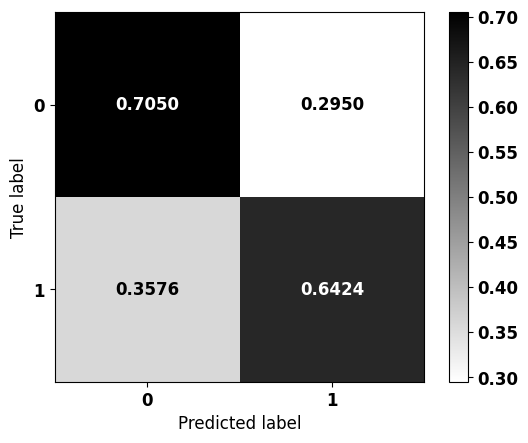


              precision    recall  f1-score   support

           0     0.3277    0.7050    0.4474      5180
           1     0.8981    0.6424    0.7490     20953

    accuracy                         0.6548     26133
   macro avg     0.6129    0.6737    0.5982     26133
weighted avg     0.7850    0.6548    0.6892     26133



In [ ]:
plot_confusion_matrix(best, mama_teste, saida_mama)

### **Próstata**

In [ ]:
saida_prost = prost_teste.sobrevida_3anos
prost_teste = prost_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(prost_teste.shape)
prost_teste.head(3)

(20862, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV       EC  CIRURGIA  \
3   0.149237   0.0  1.316000  -0.695899  0.723032 -0.63168 -0.879627   
12 -1.225865   0.0  0.958232  -0.695899  0.723032  0.27992  1.136845   
18 -0.423722   0.0 -0.370160  -0.695899  0.723032 -1.99908 -0.879627   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
3   1.381841 -0.308078  1.085991  ... -0.418644 -0.208982  0.051988  0.032404   
12 -0.723672 -0.308078 -0.920818  ... -0.418644 -0.208982  0.841591 -1.029723   
18  1.381841 -0.308078 -0.920818  ... -0.418644 -0.208982  1.236393  0.032404   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
3   1.523967 -0.540997 -0.971798         -0.714113           -0.906043   
12 -0.860966  0.842650  0.451912          0.355595            1.103700   
18  1.523967 -0.540997 -0.971798          1.425303           -0.906043   

    presenca_rec  
3      -0.414926  
12     -0.414926  
18     -0.414926  

[3 rows x 23 columns]

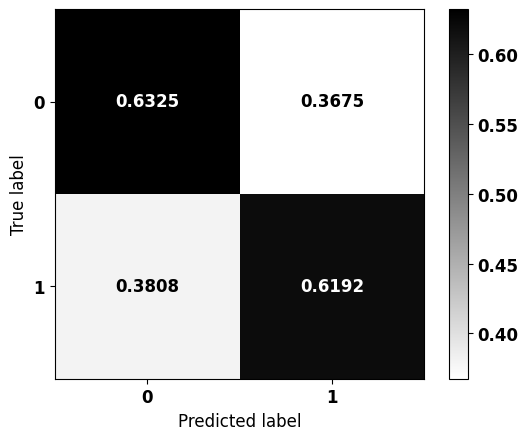


              precision    recall  f1-score   support

           0     0.2424    0.6325    0.3504      3369
           1     0.8974    0.6192    0.7328     17493

    accuracy                         0.6213     20862
   macro avg     0.5699    0.6258    0.5416     20862
weighted avg     0.7916    0.6213    0.6710     20862



In [ ]:
plot_confusion_matrix(best, prost_teste, saida_prost)

### **Colorretal**

In [ ]:
saida_colo = colo_teste.sobrevida_3anos
colo_teste = colo_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_teste.shape)
colo_teste.head(3)

(14028, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
0  0.366829 -0.972134  1.141405   1.343451  0.958036 -0.047542   0.60093   
1 -0.166349 -0.972134 -0.649610   1.343451  0.958036 -0.873817   0.60093   
6 -0.318686 -0.972134 -1.770966  -0.714301  0.958036  1.329585   0.60093   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
0 -0.567847  0.737288  -0.07854  ... -0.325938 -0.193018 -1.734289  1.587885   
1  1.761039  0.737288  -0.07854  ... -0.325938 -0.143566 -0.209650  1.767959   
6 -0.567847  0.737288  -0.07854  ... -0.325938 -0.193018  1.314989 -0.032782   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
0  0.660606 -1.716753  0.396181          1.180668            -1.03687   
1 -0.282288  0.900562 -0.968850          0.154944            -1.03687   
6 -0.046564 -0.607175  0.396181          2.206391            -1.03687   

   presenca_rec  
0     -0.475073  
1     -0.475073  
6     -0.475073  

[3 rows x 23 columns]

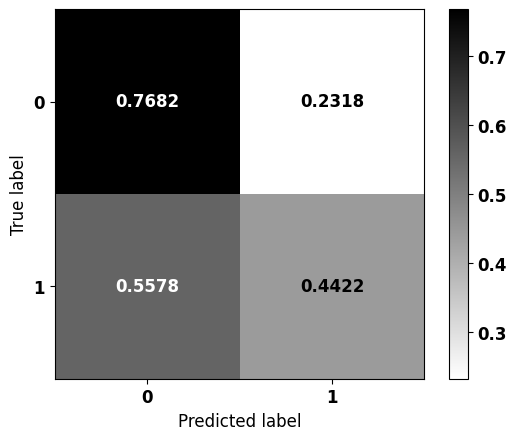


              precision    recall  f1-score   support

           0     0.5270    0.7682    0.6251      6273
           1     0.7022    0.4422    0.5426      7755

    accuracy                         0.5880     14028
   macro avg     0.6146    0.6052    0.5839     14028
weighted avg     0.6239    0.5880    0.5795     14028



In [ ]:
plot_confusion_matrix(best, colo_teste, saida_colo)

### **Pulmão**

In [ ]:
saida_pulm = pulm_teste.sobrevida_3anos
pulm_teste = pulm_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pulm_teste.shape)
pulm_teste.head(3)

(9252, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
8  -0.805560 -0.778211  0.751797  -0.853227  1.364883 -0.536078 -0.468319   
27  0.123762  1.284999  0.990635  -0.853227  1.364883  0.640728 -0.468319   
33  0.960153 -0.778211  0.844979   1.133388 -0.732664 -2.889689  2.135297   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
8  -0.748999 -1.335116 -0.070691  ... -0.403143 -0.432328  0.663596 -0.846783   
27 -0.748999  0.748999 -0.070691  ... -0.403143 -0.459489  1.022562 -0.846783   
33 -0.748999 -1.335116 -0.070691  ...  1.394771 -0.459489  0.304629 -0.846783   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
8  -1.881064  0.667417 -1.225737          0.274789            0.973507   
27 -1.171009  0.755208  0.238090          0.274789           -1.027214   
33 -0.697638  0.755208  0.238090         -0.775222            0.973507   

    presenca_rec  
8      -0.407845  
27      2.451912  
33      2.451912  

[3 rows x 23 columns]

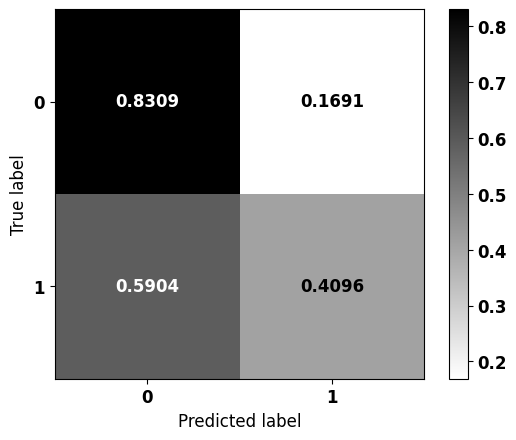


              precision    recall  f1-score   support

           0     0.9005    0.8309    0.8643      8007
           1     0.2736    0.4096    0.3281      1245

    accuracy                         0.7742      9252
   macro avg     0.5871    0.6203    0.5962      9252
weighted avg     0.8162    0.7742    0.7921      9252



In [ ]:
plot_confusion_matrix(best, pulm_teste, saida_pulm)

### **Colo de Útero**

In [ ]:
saida_colo_utero = colo_utero_teste.sobrevida_3anos
colo_utero_teste = colo_utero_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_utero_teste.shape)
colo_utero_teste.head(3)

(5368, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
40  0.519132   0.0  0.929895  -0.892955 -1.099583 -2.175331  1.259960   
63  0.722950   0.0  0.009041  -0.892955  0.909436  0.794350 -0.793676   
76 -0.092323   0.0  1.103217  -0.892955  0.909436  0.794350  1.259960   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
40 -1.349244 -0.933285 -0.087376  ...  4.004901 -0.269490  0.413337 -0.892417   
63 -1.349244 -0.933285 -0.087376  ... -0.292508  4.381396  0.936614 -0.892417   
76 -1.349244  1.071484 -0.087376  ... -0.292508 -0.175532  0.936614  1.467974   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
40 -0.710476  0.814678  0.639879         -1.668349            1.088759   
63 -0.936297  0.814678  0.639879         -0.614620           -0.918477   
76  1.321912 -1.416945  0.639879         -0.614620           -0.918477   

    presenca_rec  
40     -0.459887  
63     -0.459887  
76      2.174445  

[3 rows x 23 columns]

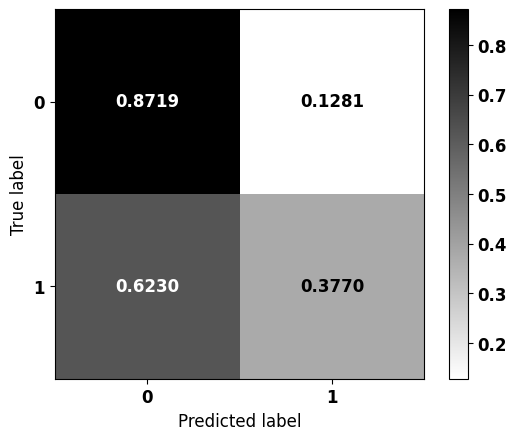


              precision    recall  f1-score   support

           0     0.5139    0.8719    0.6467      2310
           1     0.7957    0.3770    0.5116      3058

    accuracy                         0.5900      5368
   macro avg     0.6548    0.6245    0.5792      5368
weighted avg     0.6744    0.5900    0.5697      5368



In [ ]:
plot_confusion_matrix(best, colo_utero_teste, saida_colo_utero)

# **Próstata**

In [ ]:
# Leitura dos dados de colo de útero
print(df_prost.shape)
df_prost.head(3)

(83445, 32)


IDADE  SEXO     IBGE  CATEATEND  DIAGPREV  TOPO TOPOGRUP  EC TRATHOSP  \
0     74     1  3518701          9         1  C619      C61  II        I   
1     78     1  3518701          9         1  C619      C61  II        I   
2     60     1  3518701          9         2  C619      C61  II        I   

   NENHUM  ...  RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  \
0       0  ...     7   3518701         1               2.0   
1       0  ...     7   3518701         1               3.0   
2       0  ...     7   3518701         1               3.0   

   IBGE_idem_IBGEATEN  presenca_rec  obito_geral  sobrevida_ano1  \
0                   1             0            1               1   
1                   1             0            0               1   
2                   1             0            0               1   

   sobrevida_ano3  sobrevida_ano5  
0               1               1  
1               1               1  
2               1               1  

[3 rows x 32 columns]

In [ ]:
# Valores faltantes
df_prost.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df_prost.corr(numeric_only=True)
abs(corr_matrix['sobrevida_ano3']).sort_values(ascending=False).head(20)

sobrevida_ano3        1.000000
sobrevida_ano5        0.560232
sobrevida_ano1        0.542615
obito_geral           0.495667
IDADE                 0.188485
CIRURGIA              0.131056
QUIMIO                0.125216
TRATCONS              0.098753
CATEATEND             0.097919
HORMONIO              0.096619
DIAGTRAT              0.096111
DIAGPREV              0.095582
ESCOLARI_preench      0.088228
NENHUM                0.085927
RADIO                 0.070873
ANODIAG               0.043506
presenca_rec          0.031445
IBGE_idem_IBGEATEN    0.027160
CONSDIAG              0.021789
RRAS                  0.020393
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_prost.sobrevida_ano3.value_counts()

1    69969
0    13476
Name: sobrevida_ano3, dtype: int64

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_prost,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (62583, 23), X_test = (20862, 23)
y_train = (62583,), y_test = (20862,)


In [ ]:
y_train.value_counts(normalize=True)

1    0.838502
0    0.161498
Name: sobrevida_ano3, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.83851
0    0.16149
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Dataset de treinamento de Próstata
prost_treino = pd.DataFrame(X_train, columns=feat_cols)
prost_treino['TOPOGRUP'] = 'Próstata'
prost_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Próstata
prost_teste = pd.DataFrame(X_test, columns=feat_cols)
prost_teste['TOPOGRUP'] = 'Próstata'
prost_teste['sobrevida_3anos'] = y_test.values

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

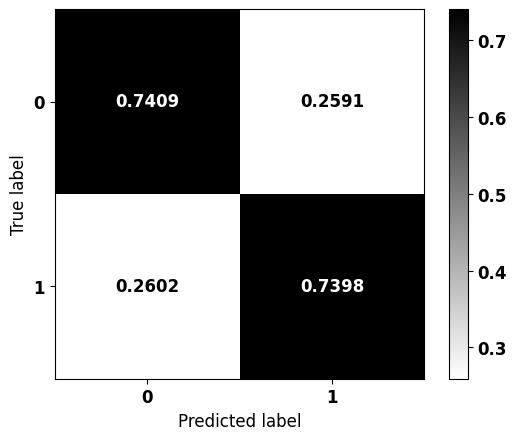


              precision    recall  f1-score   support

           0     0.3542    0.7409    0.4793      3369
           1     0.9368    0.7398    0.8268     17493

    accuracy                         0.7400     20862
   macro avg     0.6455    0.7404    0.6530     20862
weighted avg     0.8427    0.7400    0.7706     20862



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=0.1675,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

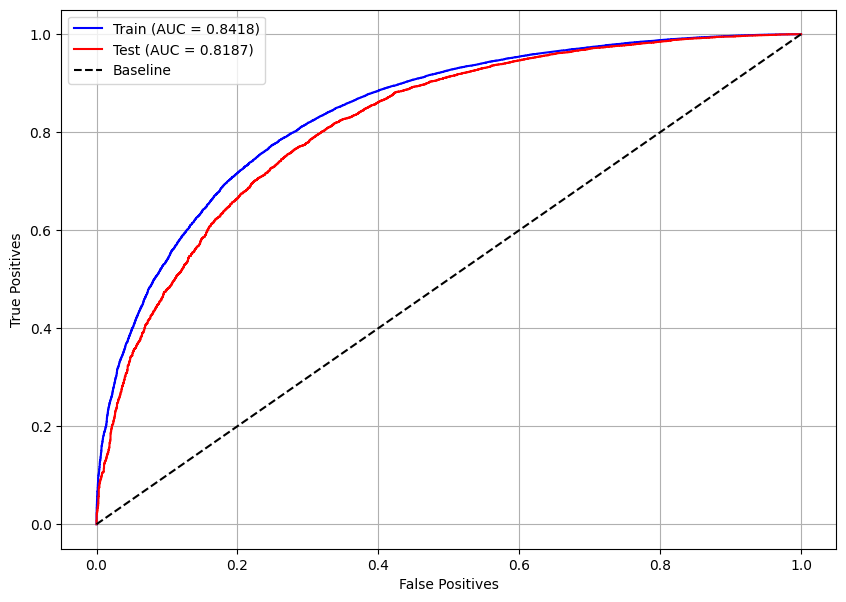

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

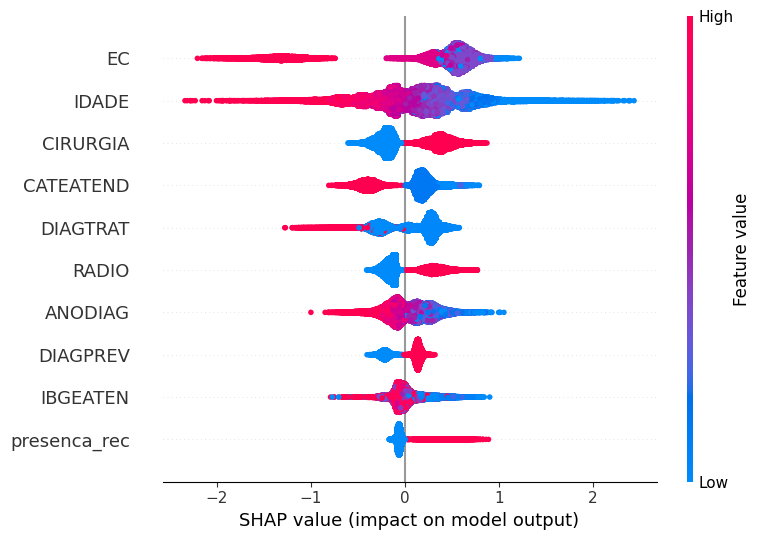

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 122,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(0.155, 0.18, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

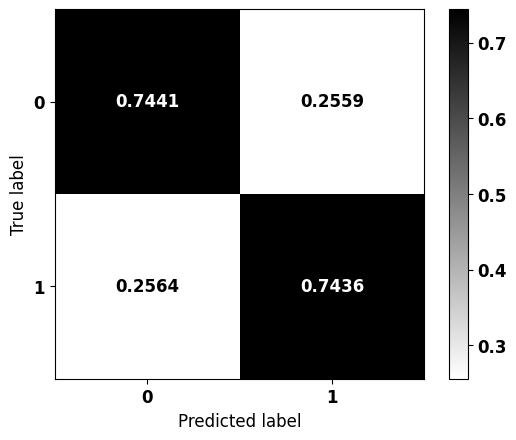


              precision    recall  f1-score   support

           0     0.3586    0.7441    0.4839      3369
           1     0.9379    0.7436    0.8295     17493

    accuracy                         0.7437     20862
   macro avg     0.6482    0.7439    0.6567     20862
weighted avg     0.8443    0.7437    0.7737     20862



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.161

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

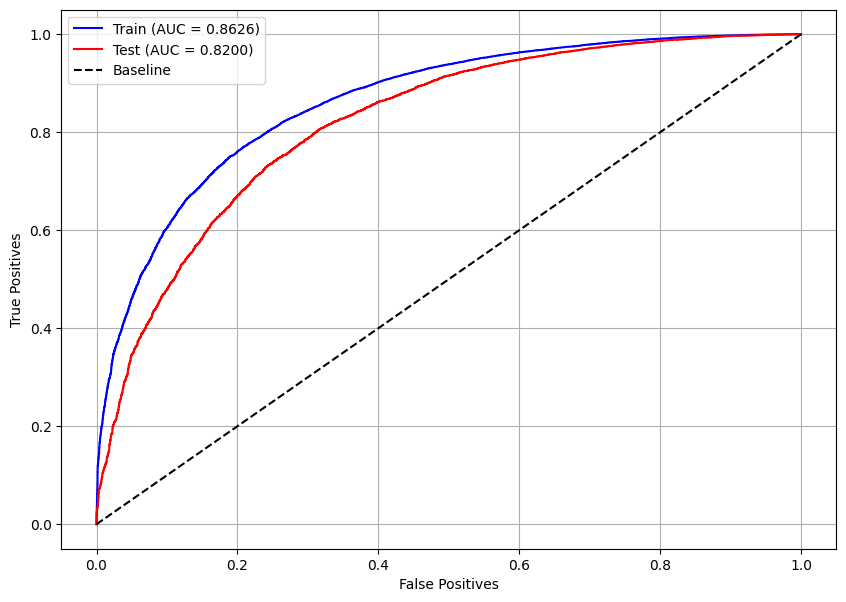

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 148,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.16, 0.18, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

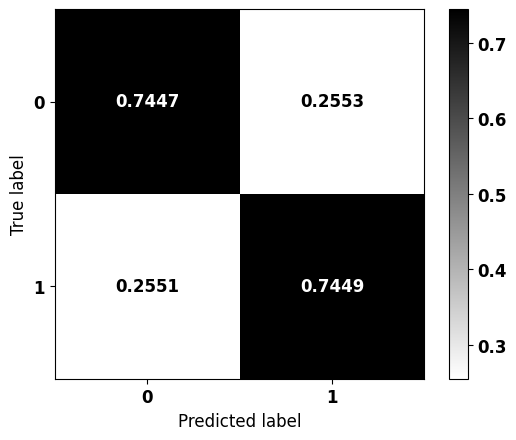


              precision    recall  f1-score   support

           0     0.3599    0.7447    0.4853      3369
           1     0.9381    0.7449    0.8304     17493

    accuracy                         0.7448     20862
   macro avg     0.6490    0.7448    0.6578     20862
weighted avg     0.8447    0.7448    0.7747     20862



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.1628

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

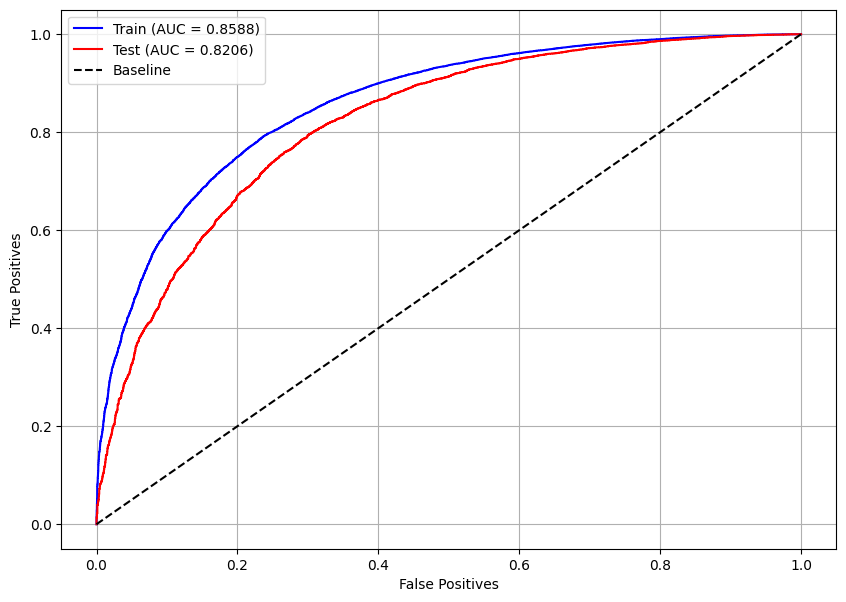

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 110,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(0.16, 0.18, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

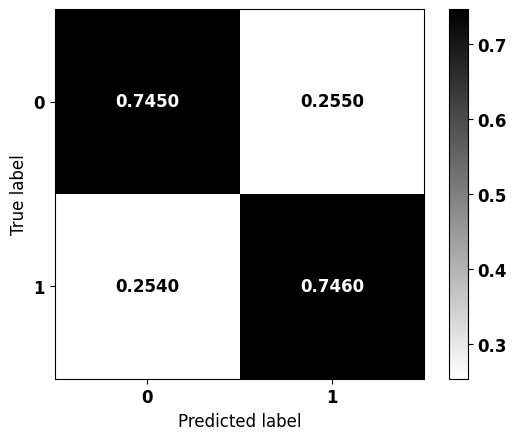


              precision    recall  f1-score   support

           0     0.3610    0.7450    0.4863      3369
           1     0.9382    0.7460    0.8312     17493

    accuracy                         0.7459     20862
   macro avg     0.6496    0.7455    0.6587     20862
weighted avg     0.8450    0.7459    0.7755     20862



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.1655

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

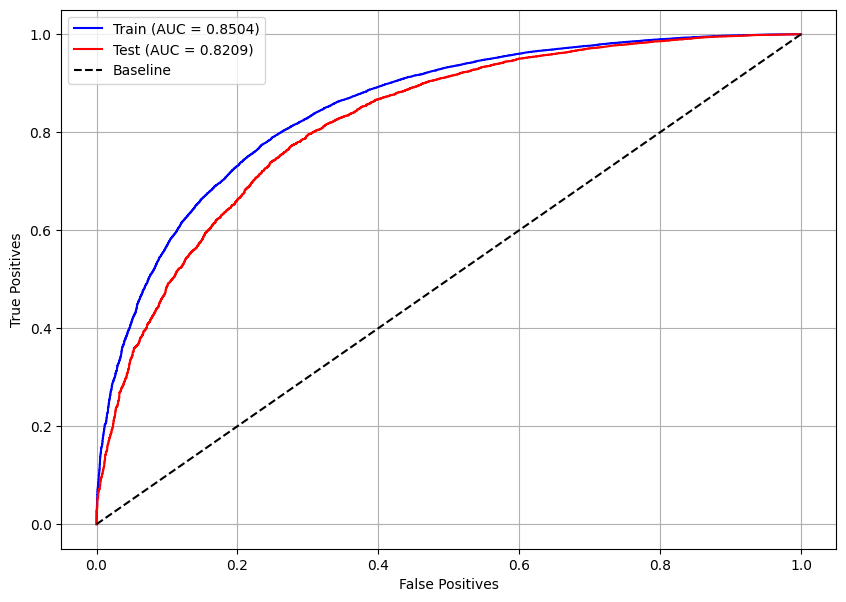

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=110, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


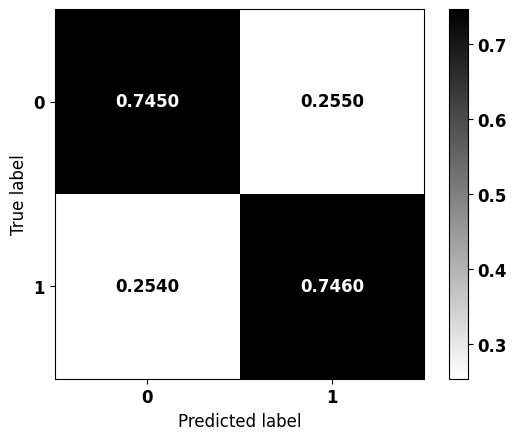


              precision    recall  f1-score   support

           0     0.3610    0.7450    0.4863      3369
           1     0.9382    0.7460    0.8312     17493

    accuracy                         0.7459     20862
   macro avg     0.6496    0.7455    0.6587     20862
weighted avg     0.8450    0.7459    0.7755     20862



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

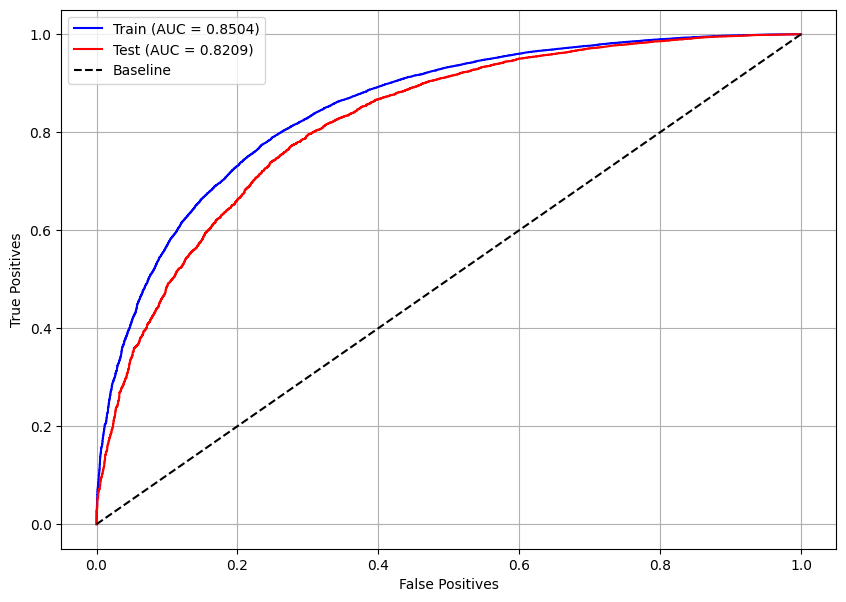

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

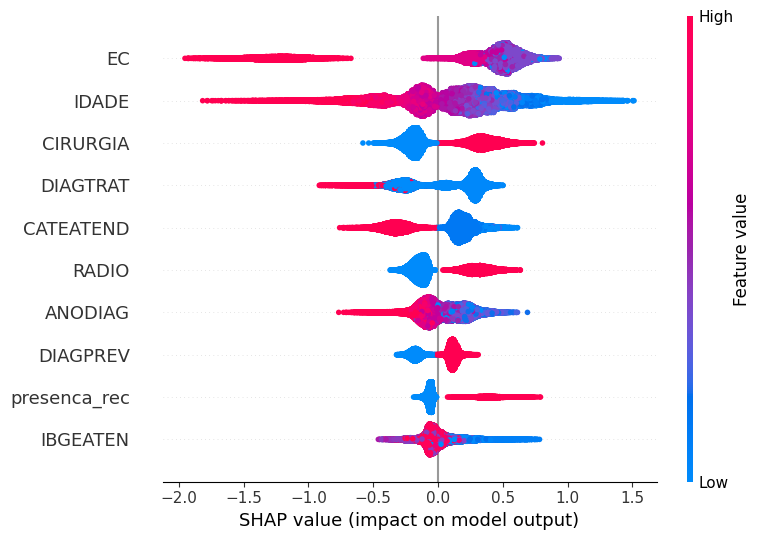

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

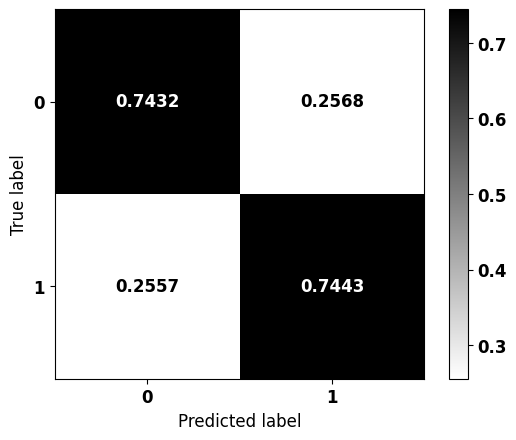


              precision    recall  f1-score   support

           0     0.3589    0.7432    0.4841      3369
           1     0.9377    0.7443    0.8299     17493

    accuracy                         0.7441     20862
   macro avg     0.6483    0.7438    0.6570     20862
weighted avg     0.8442    0.7441    0.7740     20862



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:6.025, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

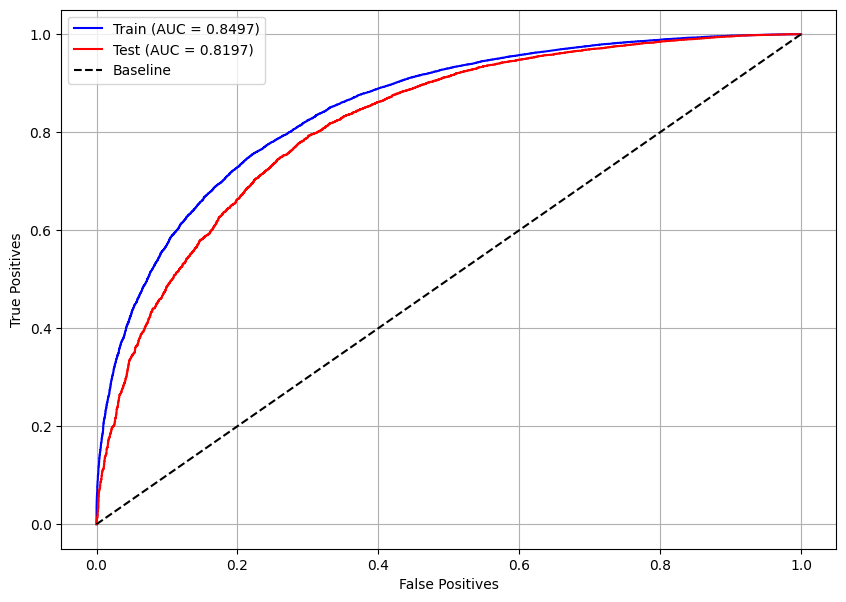

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


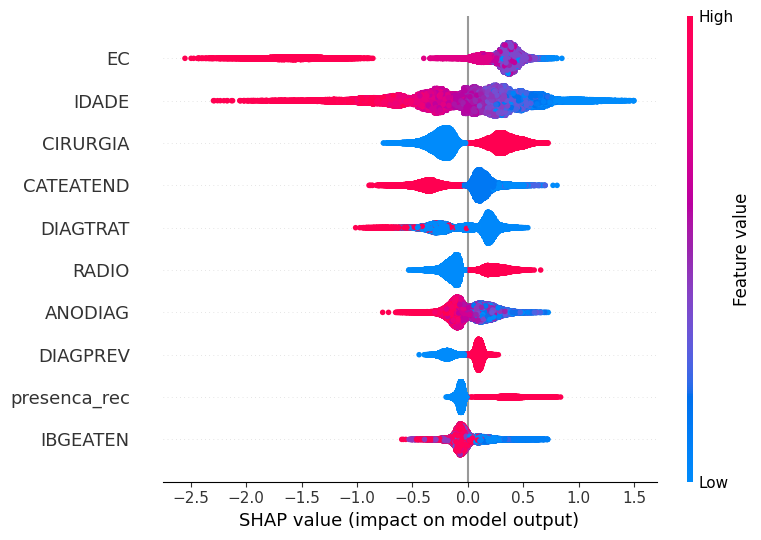

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 117,
 'max_depth': 6,
 'learning_rate': 0.12000000000000001,
 'min_child_weight': 7,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(5.9, 6.1, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

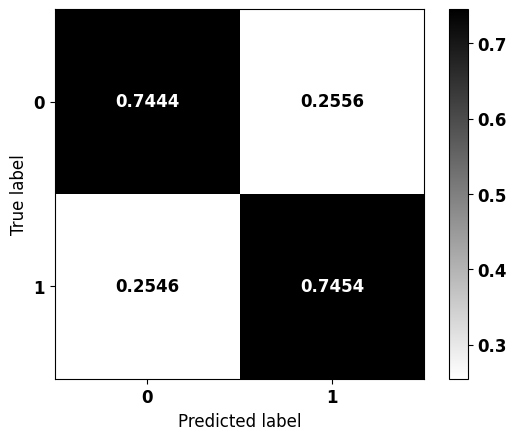


              precision    recall  f1-score   support

           0     0.3602    0.7444    0.4855      3369
           1     0.9381    0.7454    0.8307     17493

    accuracy                         0.7452     20862
   macro avg     0.6491    0.7449    0.6581     20862
weighted avg     0.8447    0.7452    0.7750     20862



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:6.041, 1:1}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

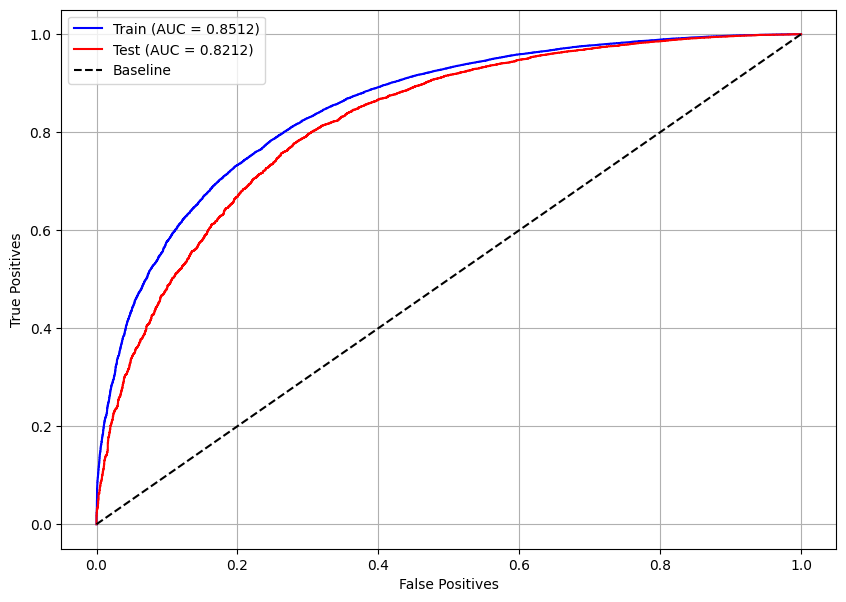

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 85,
 'max_depth': 7,
 'learning_rate': 0.11,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(5.9, 6.1, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

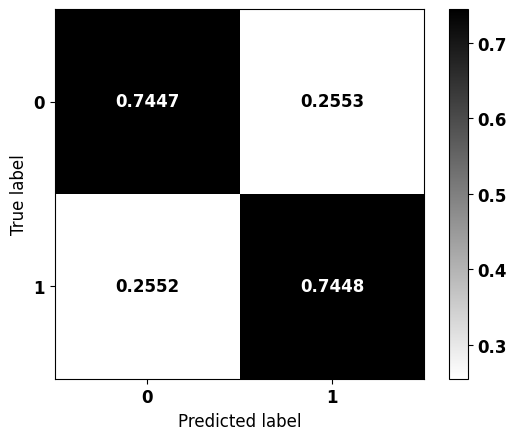


              precision    recall  f1-score   support

           0     0.3598    0.7447    0.4852      3369
           1     0.9381    0.7448    0.8303     17493

    accuracy                         0.7448     20862
   macro avg     0.6489    0.7448    0.6578     20862
weighted avg     0.8447    0.7448    0.7746     20862



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:5.939, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

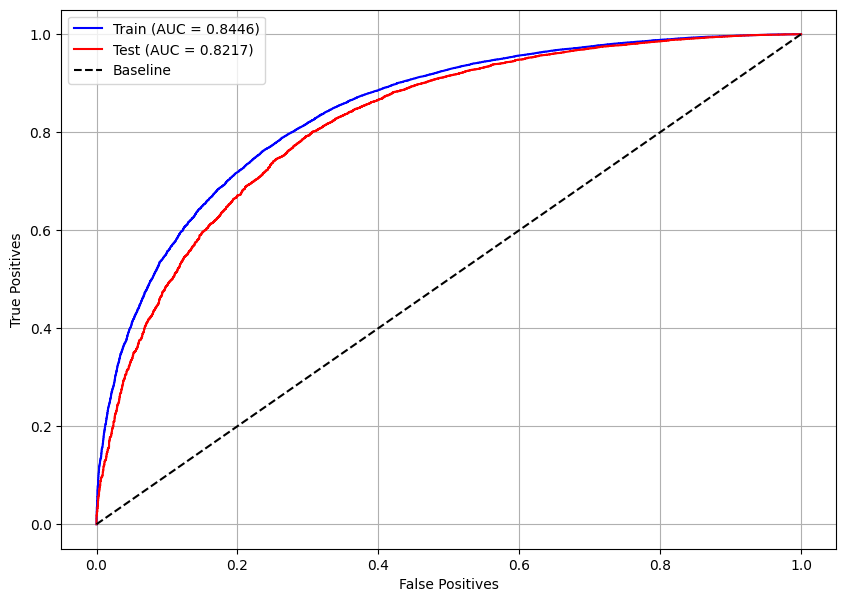

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 134,
 'max_depth': 8,
 'learning_rate': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(6, 6.2, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

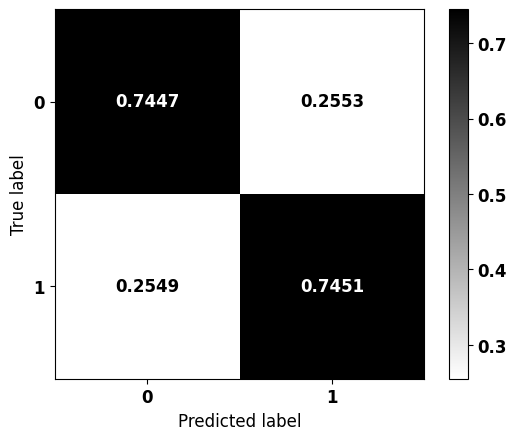


              precision    recall  f1-score   support

           0     0.3601    0.7447    0.4854      3369
           1     0.9381    0.7451    0.8305     17493

    accuracy                         0.7450     20862
   macro avg     0.6491    0.7449    0.6580     20862
weighted avg     0.8448    0.7450    0.7748     20862



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:6.06, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

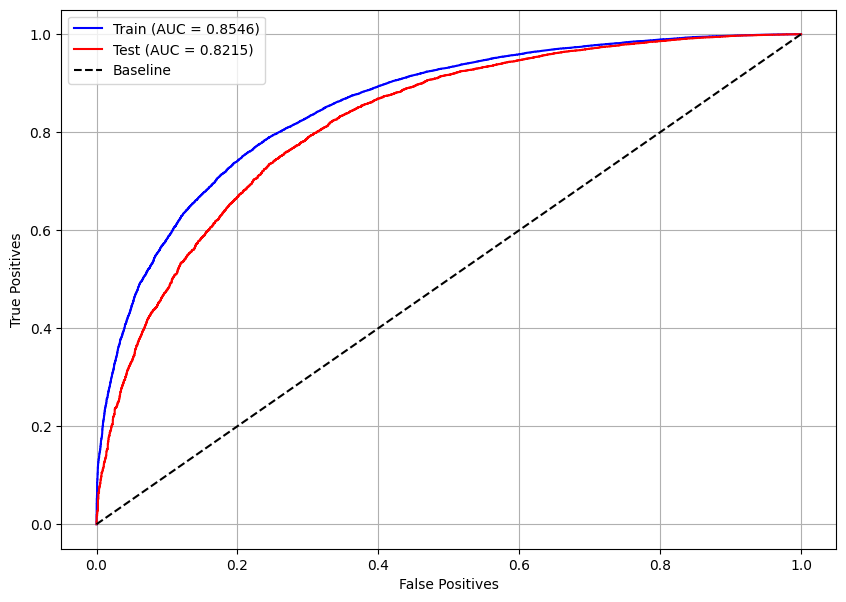

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 6.041, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.12000000000000001, max_depth=6,
               min_child_weight=7, n_estimators=117, random_state=7,
               verbose=-1)


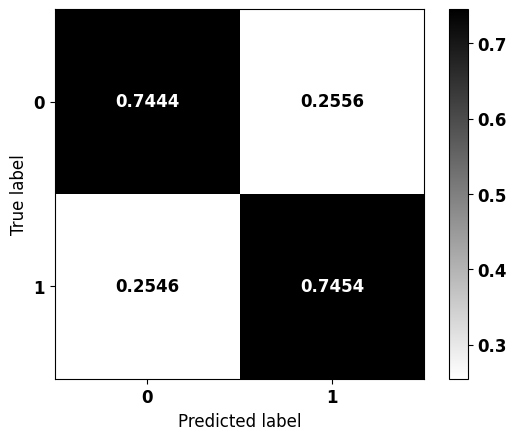


              precision    recall  f1-score   support

           0     0.3602    0.7444    0.4855      3369
           1     0.9381    0.7454    0.8307     17493

    accuracy                         0.7452     20862
   macro avg     0.6491    0.7449    0.6581     20862
weighted avg     0.8447    0.7452    0.7750     20862



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

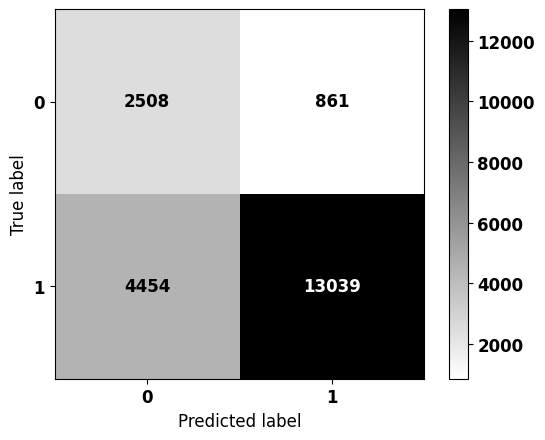


              precision    recall  f1-score   support

           0     0.3602    0.7444    0.4855      3369
           1     0.9381    0.7454    0.8307     17493

    accuracy                         0.7452     20862
   macro avg     0.6491    0.7449    0.6581     20862
weighted avg     0.8447    0.7452    0.7750     20862



In [ ]:
plot_confusion_matrix(lgbm_optuna, X_test, y_test, norm=False)

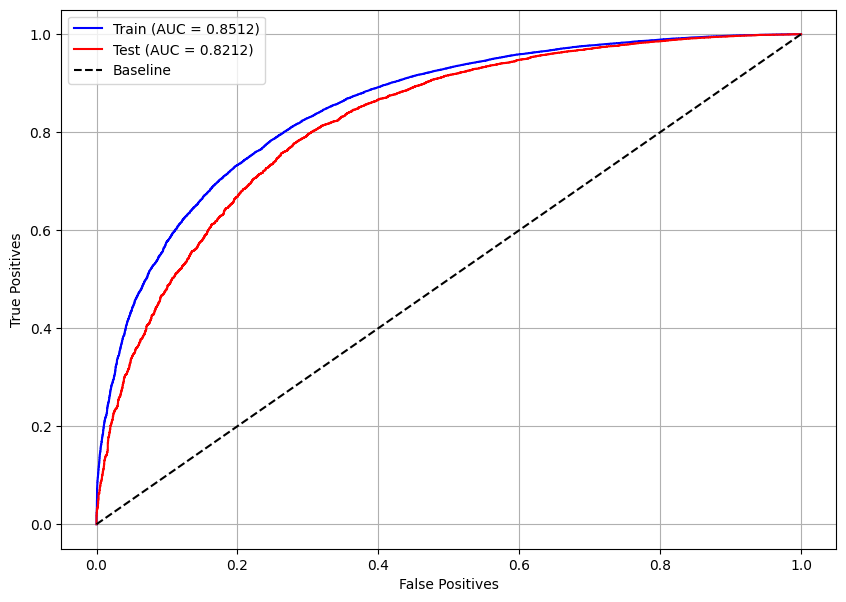

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

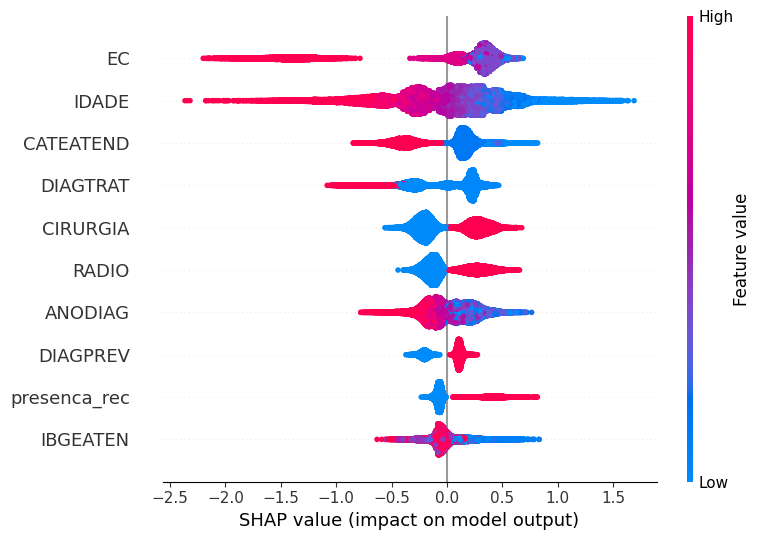

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7400, Optuna = 0.7459

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7441, Optuna = 0.7452

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 6.041, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.12000000000000001, max_depth=6,
               min_child_weight=7, n_estimators=117, random_state=7,
               verbose=-1)

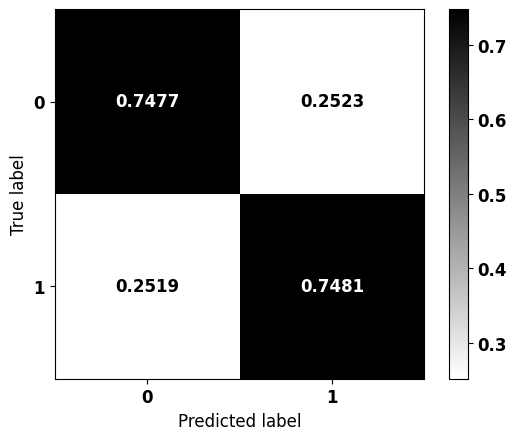


              precision    recall  f1-score   support

           0     0.3637    0.7477    0.4894      3369
           1     0.9390    0.7481    0.8327     17493

    accuracy                         0.7480     20862
   macro avg     0.6514    0.7479    0.6610     20862
weighted avg     0.8461    0.7480    0.7773     20862



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

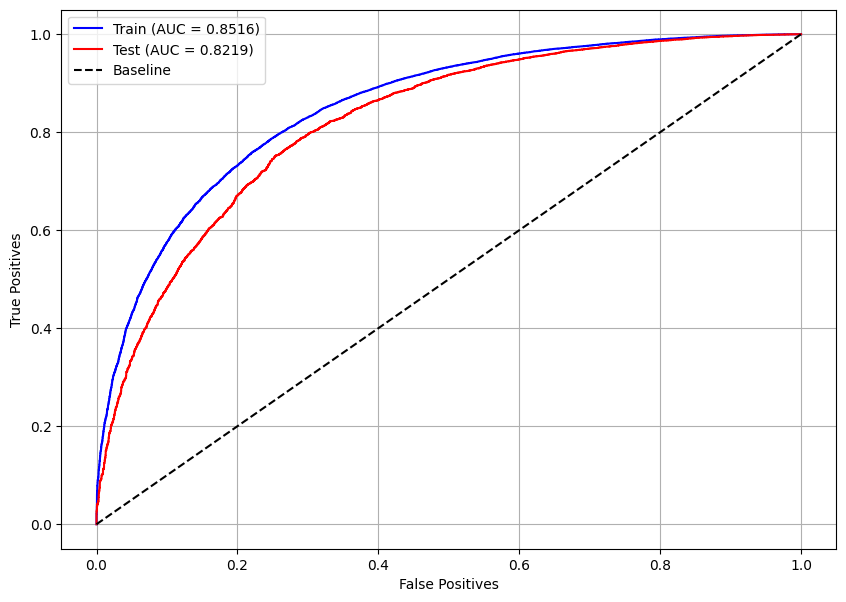

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=110, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


In [ ]:
# Dados para testar
!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF # Mais incidentes - Teste

df_teste = pd.read_csv('incid_teste.csv')

mama_teste = df_teste[df_teste.TOPOGRUP.isin(['Mama'])]
pele_teste = df_teste[df_teste.TOPOGRUP.isin(['Pele'])]
prost_teste = df_teste[df_teste.TOPOGRUP.isin(['Próstata'])]
colo_teste = df_teste[df_teste.TOPOGRUP.isin(['Colorretal'])]
pulm_teste = df_teste[df_teste.TOPOGRUP.isin(['Pulmão'])]
colo_utero_teste = df_teste[df_teste.TOPOGRUP.isin(['Colo de Útero'])]

mama_teste.shape, pele_teste.shape, prost_teste.shape, colo_teste.shape, pulm_teste.shape, colo_utero_teste.shape

Downloading...
From: https://drive.google.com/uc?id=194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF
To: /content/incid_teste.csv
100% 46.4M/46.4M [00:00<00:00, 51.3MB/s]


((26133, 25), (25221, 25), (20862, 25), (14028, 25), (9252, 25), (5368, 25))

### **Mama**

In [ ]:
saida_mama = mama_teste.sobrevida_3anos
mama_teste = mama_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(mama_teste.shape)
mama_teste.head(3)

(26133, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
2  -0.623264  0.078323 -0.758504   1.270371 -0.915765 -1.584428    0.5453   
10 -0.549923  0.078323  1.068808  -0.747659 -0.915765 -0.339226    0.5453   
11  0.110146  0.078323  0.854448   1.270371 -0.915765 -1.584428    0.5453   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
2   1.015205 -1.536653  0.848079  ...  2.956862 -0.190274 -0.446767 -0.851058   
10  1.015205  0.650765  0.848079  ...  2.956862 -0.190274 -1.367290  1.932872   
11  1.015205  0.650765  0.848079  ...  1.273530 -0.190274 -1.735499 -0.851058   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
2  -0.888302  0.743452 -0.803767          0.967430           -1.048322   
10 -0.205138 -1.642306 -0.803767         -0.940442           -1.048322   
11 -0.660580  0.743452  0.599581          1.921366            0.953905   

    presenca_rec  
2       -0.51497  
10      -0.51497  
11      -0.51497  

[3 rows x 23 columns]

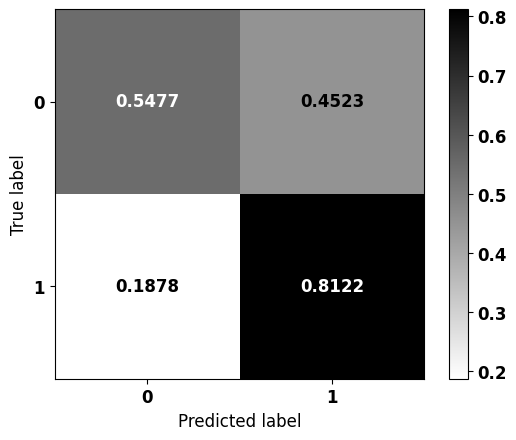


              precision    recall  f1-score   support

           0     0.4190    0.5477    0.4748      5180
           1     0.8790    0.8122    0.8443     20953

    accuracy                         0.7598     26133
   macro avg     0.6490    0.6800    0.6595     26133
weighted avg     0.7878    0.7598    0.7711     26133



In [ ]:
plot_confusion_matrix(best, mama_teste, saida_mama)

### **Pele**

In [ ]:
saida_pele = pele_teste.sobrevida_3anos
pele_teste = pele_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pele_teste.shape)
pele_teste.head(3)

(25221, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
4  0.324125 -0.916019 -0.841077   1.167751 -0.344597 -0.429061  0.315561   
5  0.701083 -0.916019  0.447649   1.167751 -0.344597 -0.429061  0.315561   
7 -0.052834 -0.916019  0.069663  -0.808623 -0.344597 -0.429061  0.315561   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
4 -0.242155 -0.156064  -0.03833  ...  0.591376  -0.20941 -0.716428  1.436258   
5 -0.242155 -0.156064  -0.03833  ... -0.689569  -0.20941  0.240058 -0.214815   
7 -0.242155 -0.156064  -0.03833  ...  1.872320  -0.20941  0.813950 -0.398268   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
4  0.636483 -1.212419  0.393904         -1.404163           -0.776427   
5 -0.234417 -1.110069 -1.165675          1.588451           -0.776427   
7  0.926783 -1.212419  0.393904         -0.406625           -0.776427   

   presenca_rec  
4     -0.218179  
5     -0.218179  
7     -0.218179  

[3 rows x 23 columns]

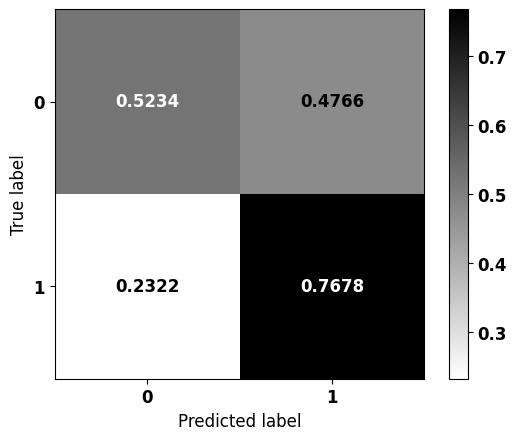


              precision    recall  f1-score   support

           0     0.4023    0.5234    0.4549      5799
           1     0.8436    0.7678    0.8040     19422

    accuracy                         0.7116     25221
   macro avg     0.6230    0.6456    0.6294     25221
weighted avg     0.7422    0.7116    0.7237     25221



In [ ]:
plot_confusion_matrix(best, pele_teste, saida_pele)

### **Colorretal**

In [ ]:
saida_colo = colo_teste.sobrevida_3anos
colo_teste = colo_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_teste.shape)
colo_teste.head(3)

(14028, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
0  0.366829 -0.972134  1.141405   1.343451  0.958036 -0.047542   0.60093   
1 -0.166349 -0.972134 -0.649610   1.343451  0.958036 -0.873817   0.60093   
6 -0.318686 -0.972134 -1.770966  -0.714301  0.958036  1.329585   0.60093   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
0 -0.567847  0.737288  -0.07854  ... -0.325938 -0.193018 -1.734289  1.587885   
1  1.761039  0.737288  -0.07854  ... -0.325938 -0.143566 -0.209650  1.767959   
6 -0.567847  0.737288  -0.07854  ... -0.325938 -0.193018  1.314989 -0.032782   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
0  0.660606 -1.716753  0.396181          1.180668            -1.03687   
1 -0.282288  0.900562 -0.968850          0.154944            -1.03687   
6 -0.046564 -0.607175  0.396181          2.206391            -1.03687   

   presenca_rec  
0     -0.475073  
1     -0.475073  
6     -0.475073  

[3 rows x 23 columns]

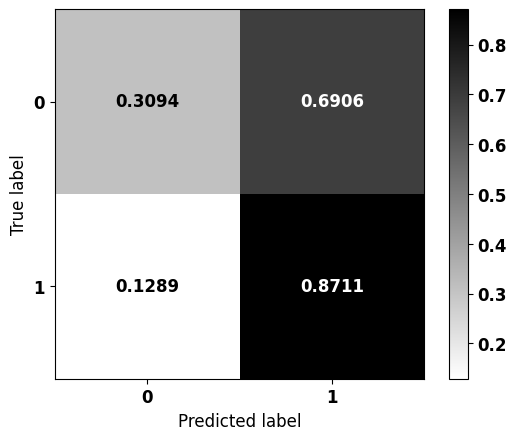


              precision    recall  f1-score   support

           0     0.6600    0.3094    0.4213      6273
           1     0.6093    0.8711    0.7170      7755

    accuracy                         0.6199     14028
   macro avg     0.6346    0.5902    0.5692     14028
weighted avg     0.6319    0.6199    0.5848     14028



In [ ]:
plot_confusion_matrix(best, colo_teste, saida_colo)

### **Pulmão**

In [ ]:
saida_pulm = pulm_teste.sobrevida_3anos
pulm_teste = pulm_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pulm_teste.shape)
pulm_teste.head(3)

(9252, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
8  -0.805560 -0.778211  0.751797  -0.853227  1.364883 -0.536078 -0.468319   
27  0.123762  1.284999  0.990635  -0.853227  1.364883  0.640728 -0.468319   
33  0.960153 -0.778211  0.844979   1.133388 -0.732664 -2.889689  2.135297   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
8  -0.748999 -1.335116 -0.070691  ... -0.403143 -0.432328  0.663596 -0.846783   
27 -0.748999  0.748999 -0.070691  ... -0.403143 -0.459489  1.022562 -0.846783   
33 -0.748999 -1.335116 -0.070691  ...  1.394771 -0.459489  0.304629 -0.846783   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
8  -1.881064  0.667417 -1.225737          0.274789            0.973507   
27 -1.171009  0.755208  0.238090          0.274789           -1.027214   
33 -0.697638  0.755208  0.238090         -0.775222            0.973507   

    presenca_rec  
8      -0.407845  
27      2.451912  
33      2.451912  

[3 rows x 23 columns]

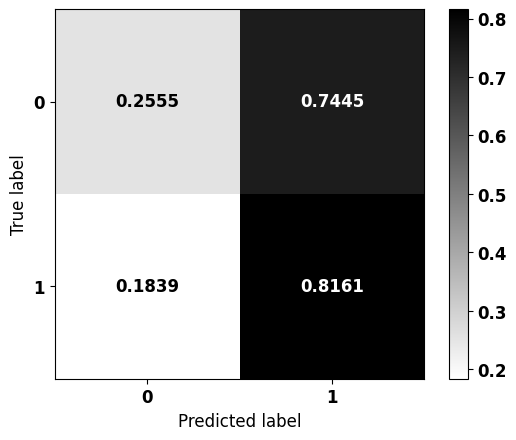


              precision    recall  f1-score   support

           0     0.8993    0.2555    0.3980      8007
           1     0.1456    0.8161    0.2471      1245

    accuracy                         0.3310      9252
   macro avg     0.5225    0.5358    0.3226      9252
weighted avg     0.7979    0.3310    0.3777      9252



In [ ]:
plot_confusion_matrix(best, pulm_teste, saida_pulm)

### **Colo de Útero**

In [ ]:
saida_colo_utero = colo_utero_teste.sobrevida_3anos
colo_utero_teste = colo_utero_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_utero_teste.shape)
colo_utero_teste.head(3)

(5368, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
40  0.519132   0.0  0.929895  -0.892955 -1.099583 -2.175331  1.259960   
63  0.722950   0.0  0.009041  -0.892955  0.909436  0.794350 -0.793676   
76 -0.092323   0.0  1.103217  -0.892955  0.909436  0.794350  1.259960   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
40 -1.349244 -0.933285 -0.087376  ...  4.004901 -0.269490  0.413337 -0.892417   
63 -1.349244 -0.933285 -0.087376  ... -0.292508  4.381396  0.936614 -0.892417   
76 -1.349244  1.071484 -0.087376  ... -0.292508 -0.175532  0.936614  1.467974   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
40 -0.710476  0.814678  0.639879         -1.668349            1.088759   
63 -0.936297  0.814678  0.639879         -0.614620           -0.918477   
76  1.321912 -1.416945  0.639879         -0.614620           -0.918477   

    presenca_rec  
40     -0.459887  
63     -0.459887  
76      2.174445  

[3 rows x 23 columns]

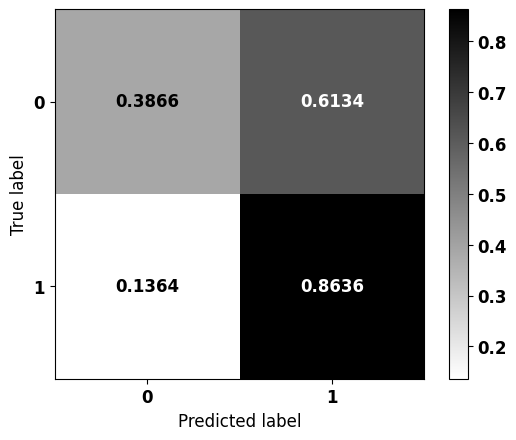


              precision    recall  f1-score   support

           0     0.6817    0.3866    0.4934      2310
           1     0.6508    0.8636    0.7423      3058

    accuracy                         0.6583      5368
   macro avg     0.6662    0.6251    0.6178      5368
weighted avg     0.6641    0.6583    0.6352      5368



In [ ]:
plot_confusion_matrix(best, colo_utero_teste, saida_colo_utero)

# **Colorretal**

In [ ]:
# Leitura dos dados de colorretal
print(df_colo.shape)
df_colo.head(3)

(56111, 32)


IDADE  SEXO     IBGE  CATEATEND  DIAGPREV  TOPO TOPOGRUP    EC TRATHOSP  \
0     79     1  3518701          9         1  C199      C19  IIIB        E   
1     68     2  3518701          9         1  C180      C18   IIA        E   
2     51     2  3518701          2         1  C180      C18  IIIA        E   

   NENHUM  ...  RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  \
0       0  ...     7   3518701         1               2.0   
1       0  ...     7   3518701         1               2.0   
2       0  ...     7   3518701         1               3.0   

   IBGE_idem_IBGEATEN  presenca_rec  obito_geral  sobrevida_ano1  \
0                   1             0            1               1   
1                   1             0            1               1   
2                   1             0            1               0   

   sobrevida_ano3  sobrevida_ano5  
0               0               0  
1               1               0  
2               0               0  

[3 rows x 32 columns]

In [ ]:
# Valores faltantes
df_colo.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df_colo.corr(numeric_only=True)
abs(corr_matrix['sobrevida_ano3']).sort_values(ascending = False).head(20)

sobrevida_ano3        1.000000
sobrevida_ano5        0.685366
obito_geral           0.672258
sobrevida_ano1        0.616970
CIRURGIA              0.272532
TRATCONS              0.189798
DIAGTRAT              0.188500
NENHUM                0.188264
IDADE                 0.106721
CATEATEND             0.092419
ESCOLARI_preench      0.073127
DIAGPREV              0.063064
OUTROS                0.060598
QUIMIO                0.055128
SEXO                  0.039709
IBGE_idem_IBGEATEN    0.030832
IBGEATEN              0.030181
HORMONIO              0.029209
RADIO                 0.024731
ANODIAG               0.021351
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_colo.sobrevida_ano3.value_counts()

1    31019
0    25092
Name: sobrevida_ano3, dtype: int64

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_colo,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (42083, 23), X_test = (14028, 23)
y_train = (42083,), y_test = (14028,)


In [ ]:
y_train.value_counts(normalize=True)

1    0.552812
0    0.447188
Name: sobrevida_ano3, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.552823
0    0.447177
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Dataset de treinamento de Colorretal
colo_treino = pd.DataFrame(X_train, columns=feat_cols)
colo_treino['TOPOGRUP'] = 'Colorretal'
colo_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Colorretal
colo_teste = pd.DataFrame(X_test, columns=feat_cols)
colo_teste['TOPOGRUP'] = 'Colorretal'
colo_teste['sobrevida_3anos'] = y_test.values

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

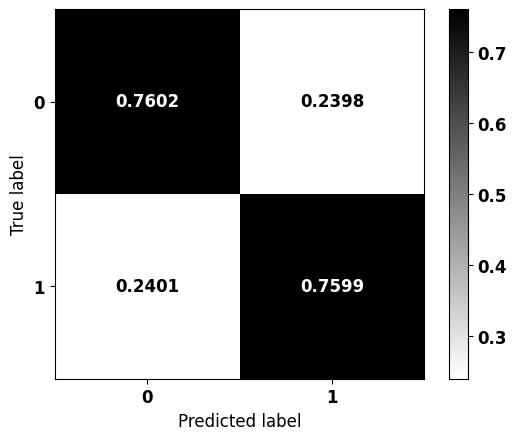


              precision    recall  f1-score   support

           0     0.7192    0.7602    0.7392      6273
           1     0.7967    0.7599    0.7779      7755

    accuracy                         0.7601     14028
   macro avg     0.7579    0.7601    0.7585     14028
weighted avg     0.7620    0.7601    0.7605     14028



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=0.645,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

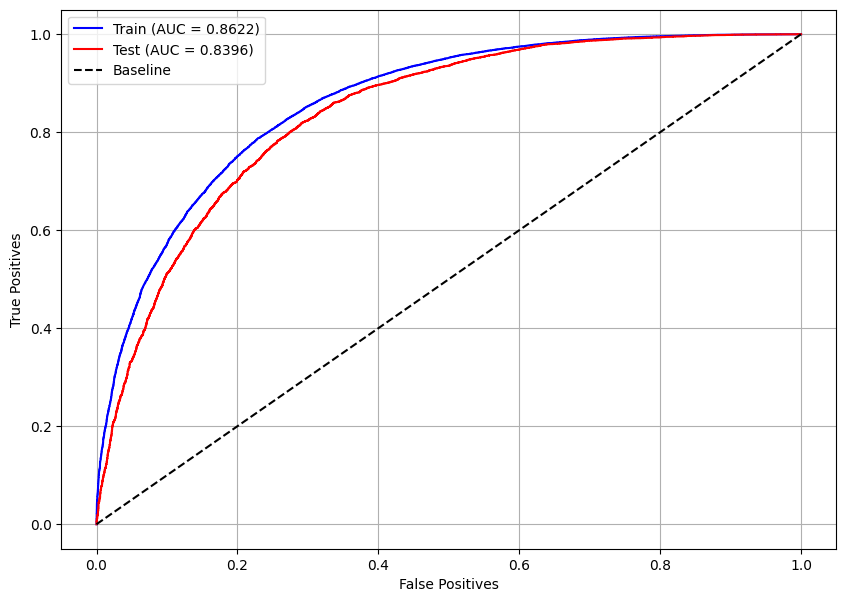

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

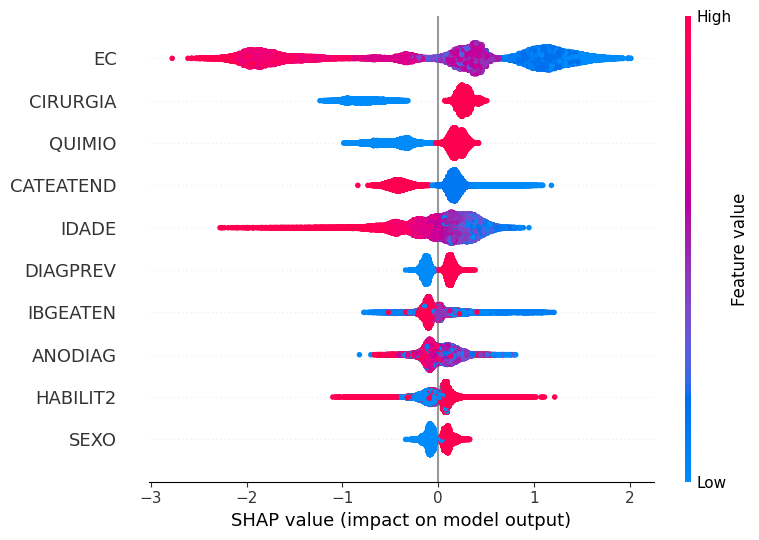

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 107,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'min_child_weight': 5,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.63, 0.66, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

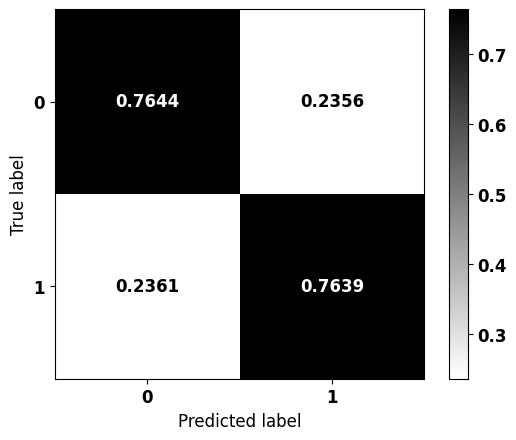


              precision    recall  f1-score   support

           0     0.7237    0.7644    0.7435      6273
           1     0.8003    0.7639    0.7817      7755

    accuracy                         0.7641     14028
   macro avg     0.7620    0.7641    0.7626     14028
weighted avg     0.7660    0.7641    0.7646     14028



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.6488

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

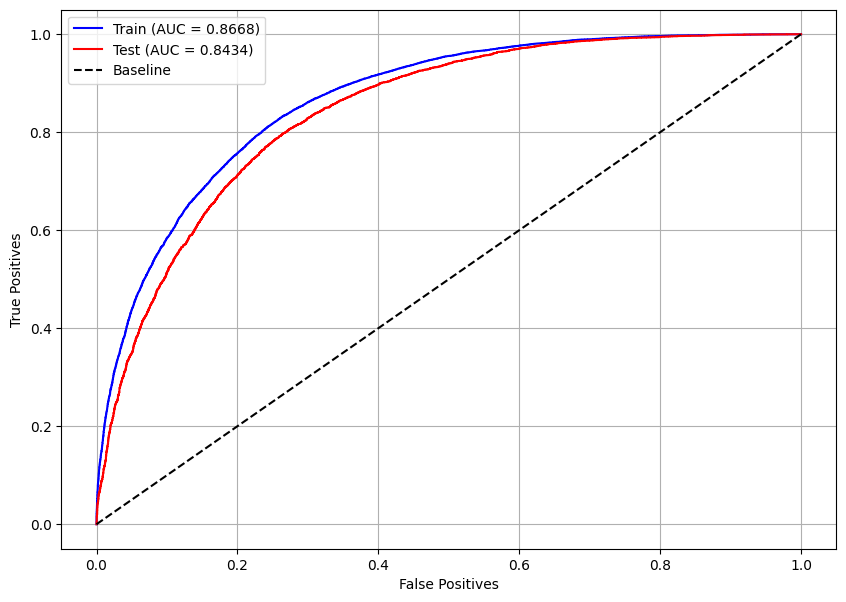

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 102,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.645, 0.67, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

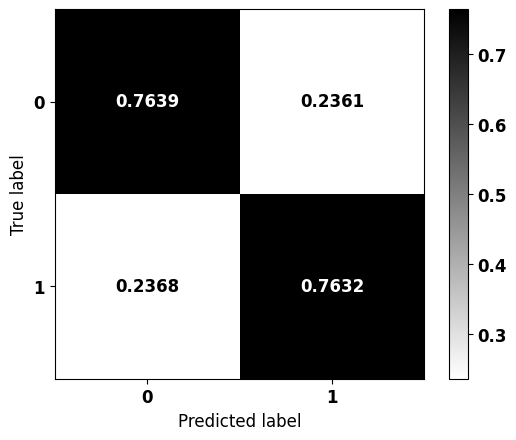


              precision    recall  f1-score   support

           0     0.7230    0.7639    0.7429      6273
           1     0.7999    0.7632    0.7811      7755

    accuracy                         0.7635     14028
   macro avg     0.7614    0.7636    0.7620     14028
weighted avg     0.7655    0.7635    0.7640     14028



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.6518

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

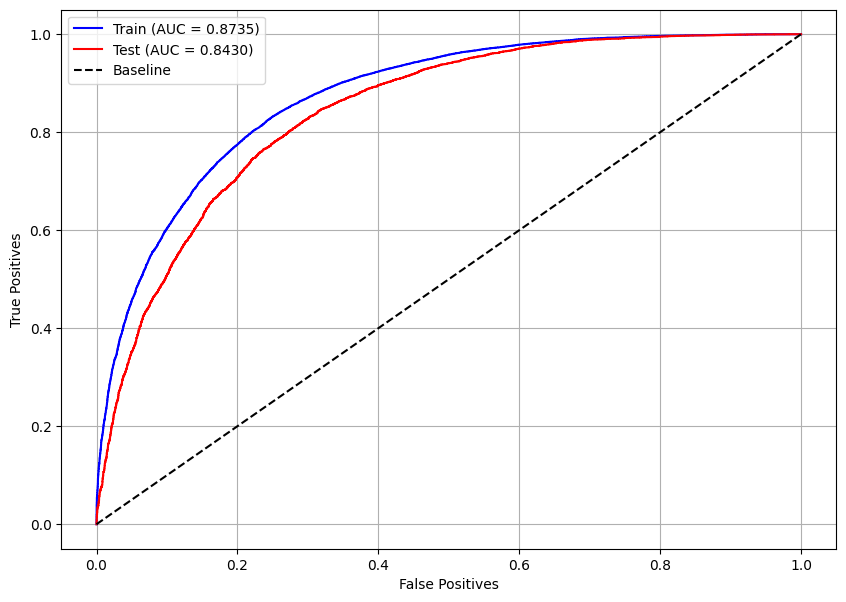

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 105,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.64, 0.66, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

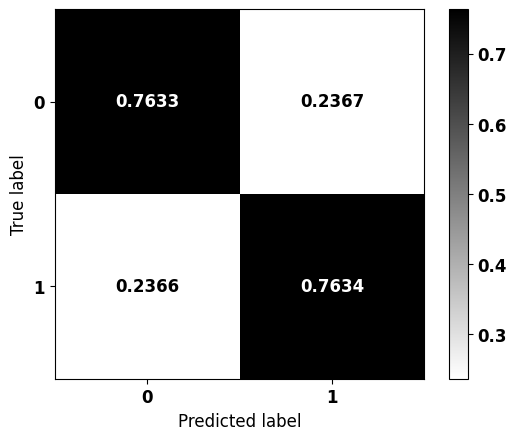


              precision    recall  f1-score   support

           0     0.7229    0.7633    0.7426      6273
           1     0.7995    0.7634    0.7810      7755

    accuracy                         0.7633     14028
   macro avg     0.7612    0.7633    0.7618     14028
weighted avg     0.7652    0.7633    0.7638     14028



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.6517

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

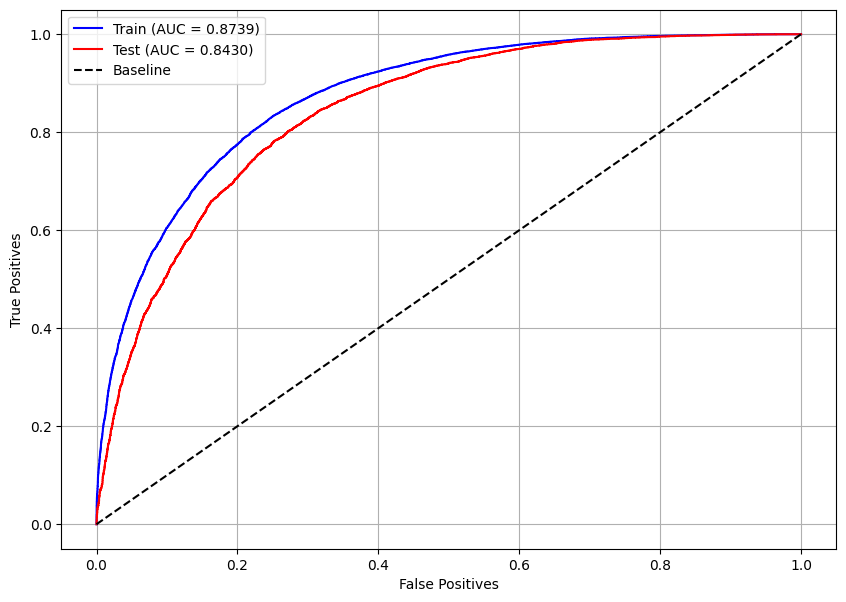

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6000000000000001, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=107,
              n_jobs=None, num_parallel_tree=None, random_state=7, ...)


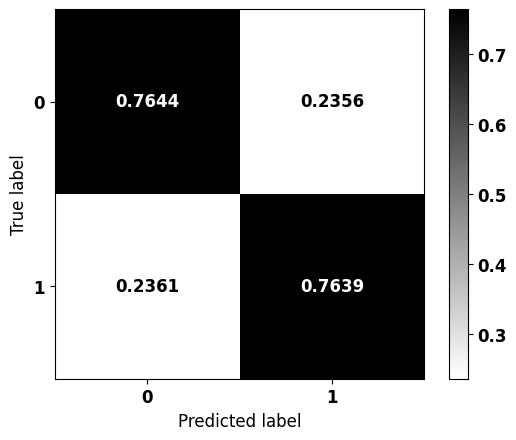


              precision    recall  f1-score   support

           0     0.7237    0.7644    0.7435      6273
           1     0.8003    0.7639    0.7817      7755

    accuracy                         0.7641     14028
   macro avg     0.7620    0.7641    0.7626     14028
weighted avg     0.7660    0.7641    0.7646     14028



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

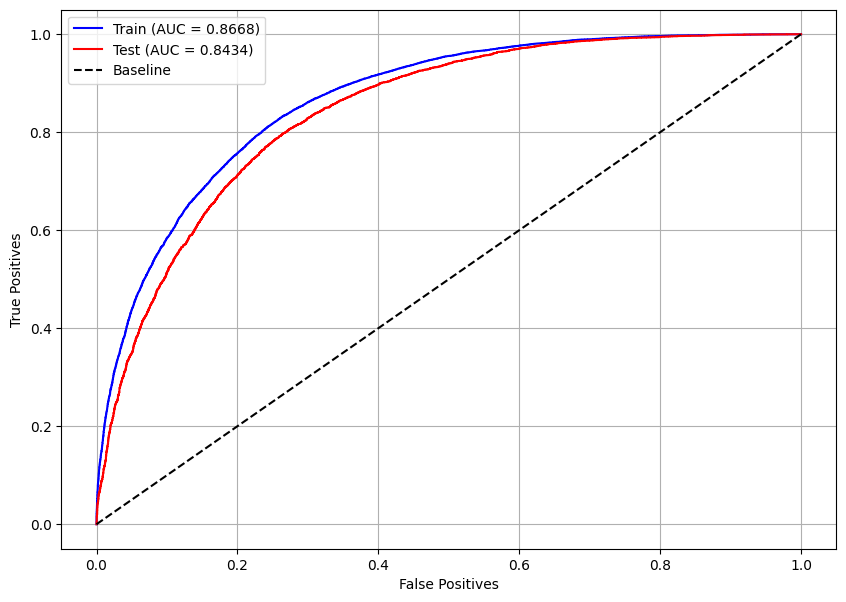

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

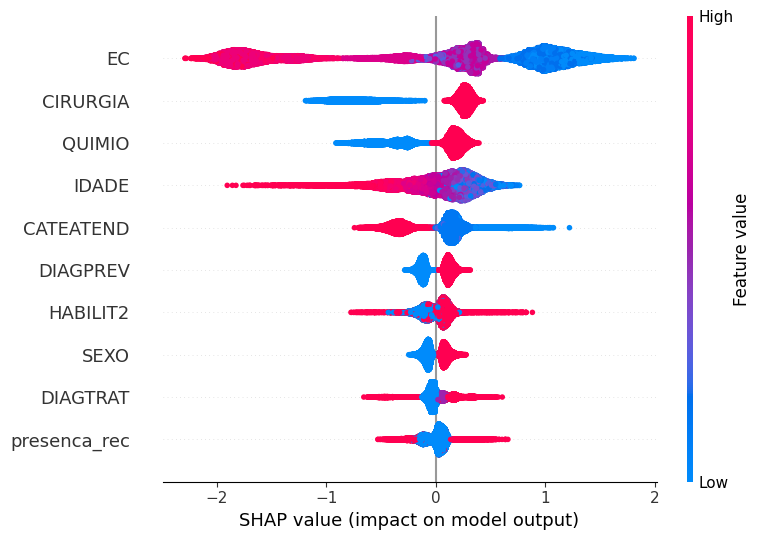

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

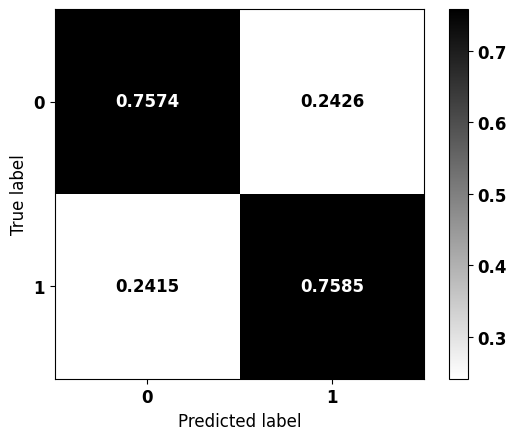


              precision    recall  f1-score   support

           0     0.7172    0.7574    0.7368      6273
           1     0.7944    0.7585    0.7760      7755

    accuracy                         0.7580     14028
   macro avg     0.7558    0.7579    0.7564     14028
weighted avg     0.7599    0.7580    0.7585     14028



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0: 1.4662, 1: 1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

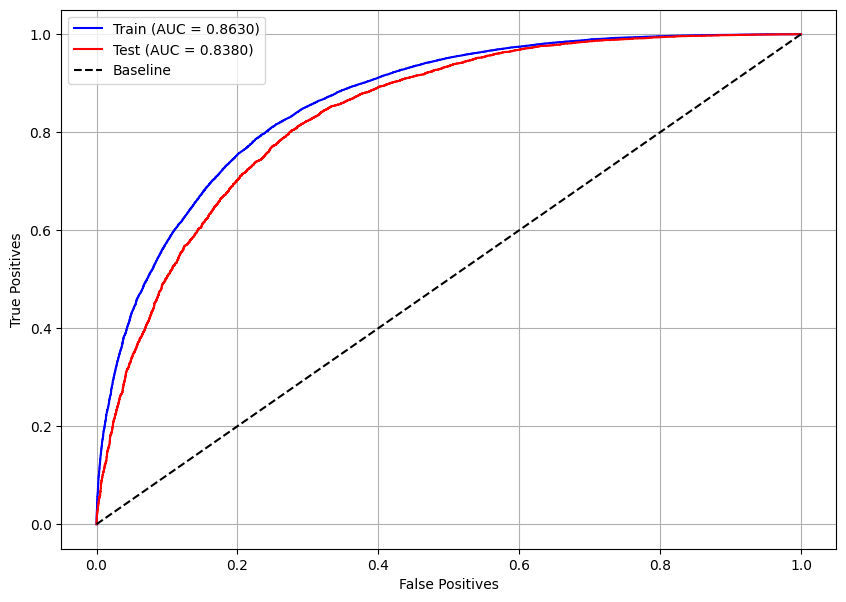

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


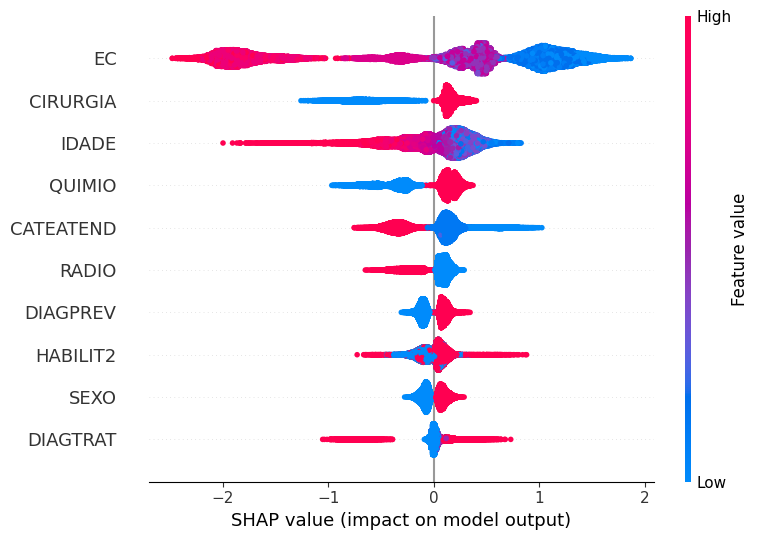

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 88,
 'max_depth': 6,
 'learning_rate': 0.16,
 'min_child_weight': 2,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.42, 1.44, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

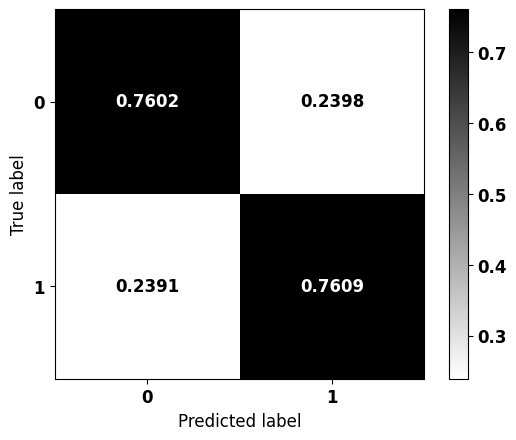


              precision    recall  f1-score   support

           0     0.7201    0.7602    0.7396      6273
           1     0.7969    0.7609    0.7785      7755

    accuracy                         0.7606     14028
   macro avg     0.7585    0.7606    0.7591     14028
weighted avg     0.7625    0.7606    0.7611     14028



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.4211, 1:1}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

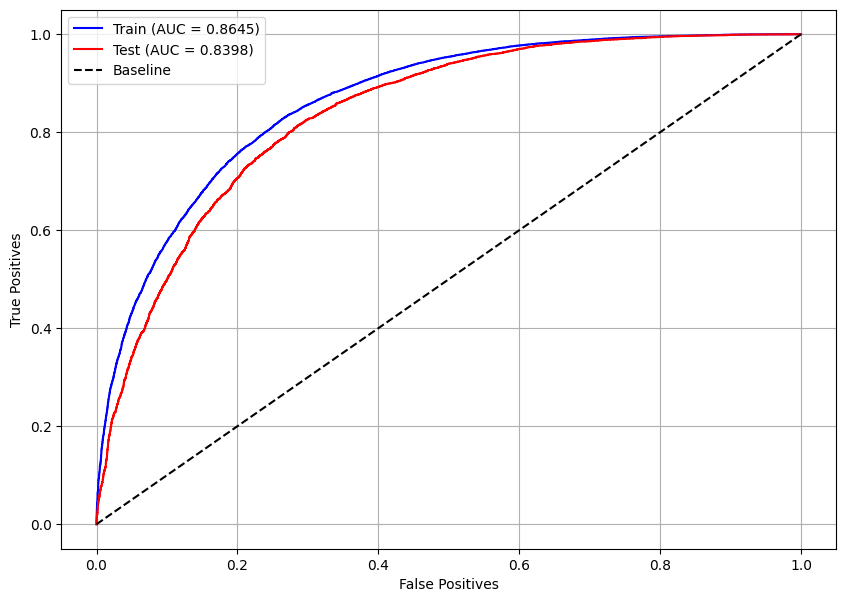

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 143,
 'max_depth': 10,
 'learning_rate': 0.12000000000000001,
 'min_child_weight': 1,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.425, 1.46, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

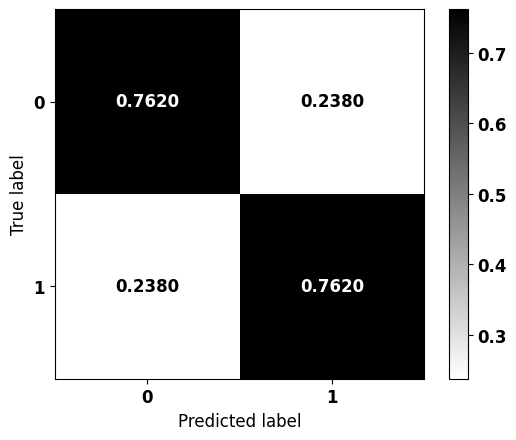


              precision    recall  f1-score   support

           0     0.7214    0.7620    0.7411      6273
           1     0.7983    0.7620    0.7797      7755

    accuracy                         0.7620     14028
   macro avg     0.7598    0.7620    0.7604     14028
weighted avg     0.7639    0.7620    0.7625     14028



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.4445, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

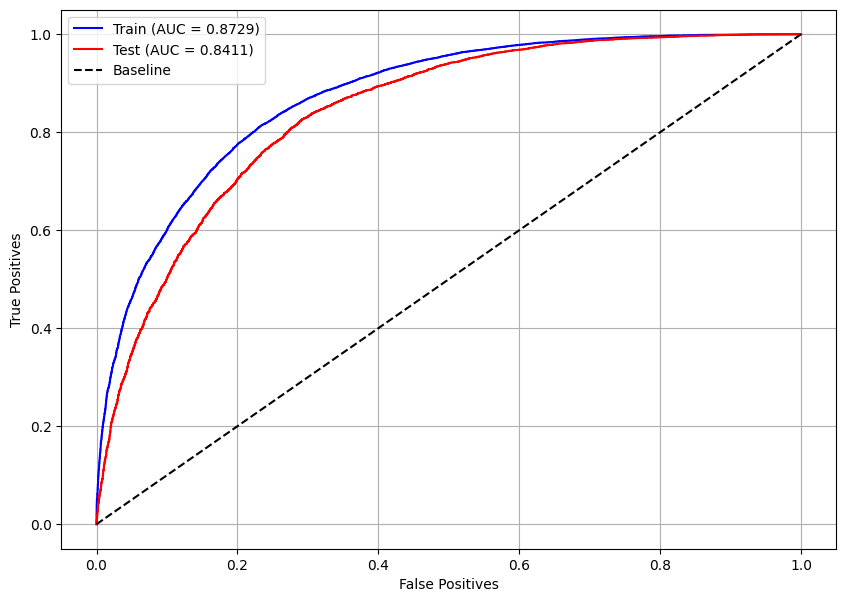

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 103,
 'max_depth': 7,
 'learning_rate': 0.11,
 'min_child_weight': 7,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.43, 1.45, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

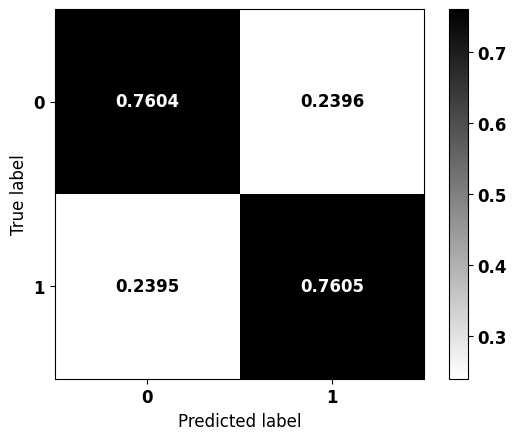


              precision    recall  f1-score   support

           0     0.7198    0.7604    0.7395      6273
           1     0.7969    0.7605    0.7783      7755

    accuracy                         0.7605     14028
   macro avg     0.7584    0.7605    0.7589     14028
weighted avg     0.7624    0.7605    0.7610     14028



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.4357, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

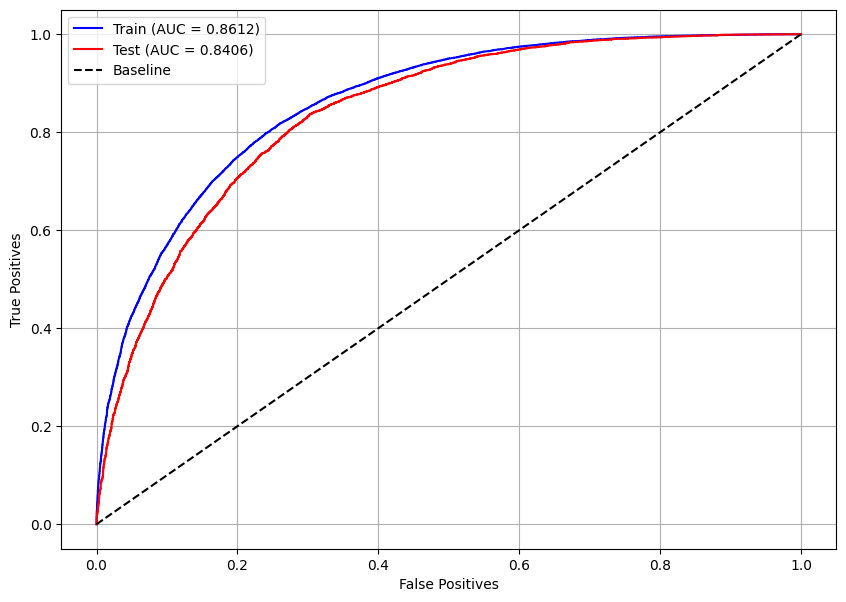

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1.4445, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.12000000000000001, max_depth=10,
               min_child_weight=1, n_estimators=143, random_state=7,
               verbose=-1)


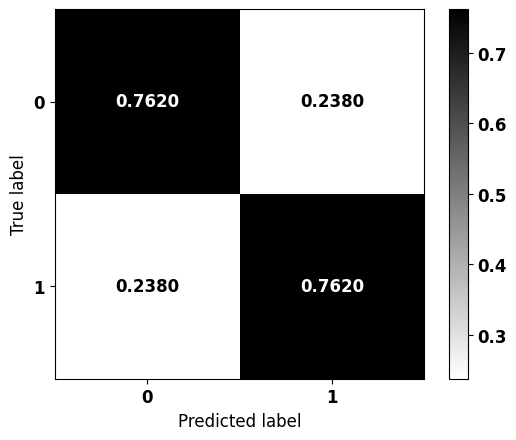


              precision    recall  f1-score   support

           0     0.7214    0.7620    0.7411      6273
           1     0.7983    0.7620    0.7797      7755

    accuracy                         0.7620     14028
   macro avg     0.7598    0.7620    0.7604     14028
weighted avg     0.7639    0.7620    0.7625     14028



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

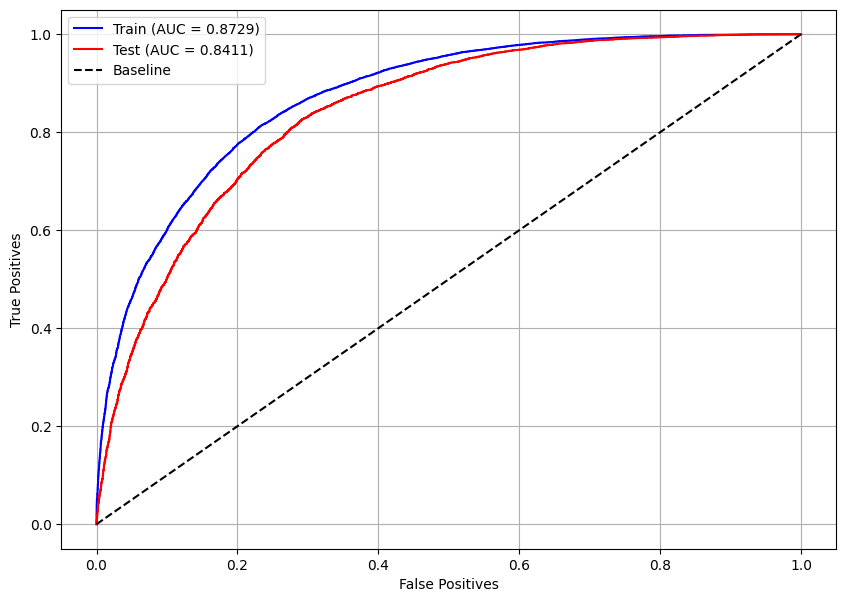

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


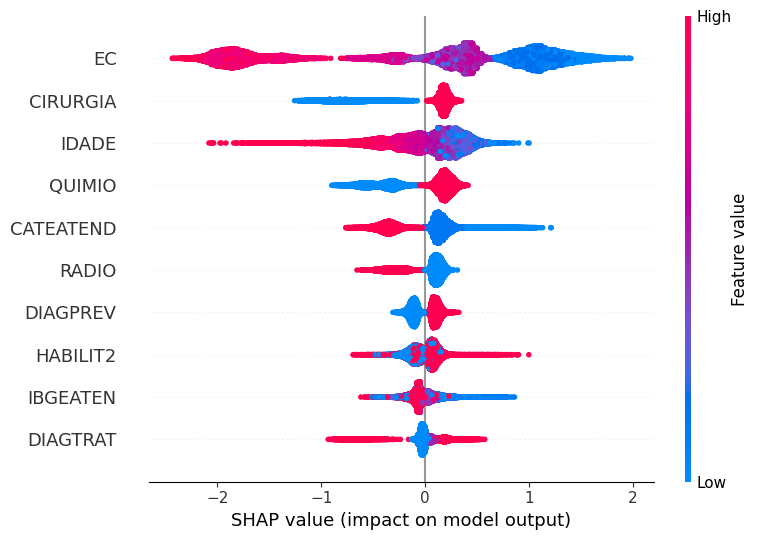

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7601, Optuna = 0.7641

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7580, Optuna = 0.7620

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1.4445, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.12000000000000001, max_depth=10,
               min_child_weight=1, n_estimators=143, random_state=7,
               verbose=-1)

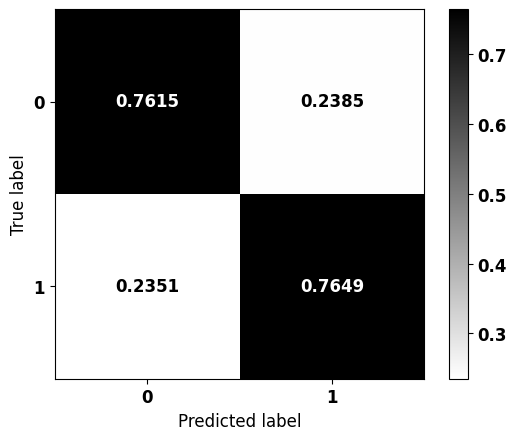


              precision    recall  f1-score   support

           0     0.7238    0.7615    0.7422      6273
           1     0.7986    0.7649    0.7814      7755

    accuracy                         0.7634     14028
   macro avg     0.7612    0.7632    0.7618     14028
weighted avg     0.7651    0.7634    0.7639     14028



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

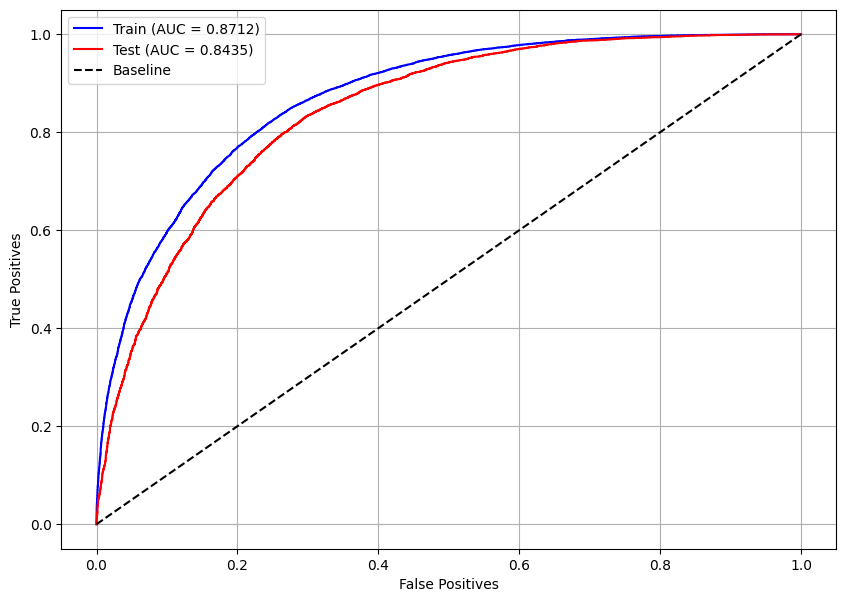

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6000000000000001, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=107,
              n_jobs=None, num_parallel_tree=None, random_state=7, ...)


In [ ]:
# Dados para testar
!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF # Mais incidentes - Teste

df_teste = pd.read_csv('incid_teste.csv')

mama_teste = df_teste[df_teste.TOPOGRUP.isin(['Mama'])]
pele_teste = df_teste[df_teste.TOPOGRUP.isin(['Pele'])]
prost_teste = df_teste[df_teste.TOPOGRUP.isin(['Próstata'])]
colo_teste = df_teste[df_teste.TOPOGRUP.isin(['Colorretal'])]
pulm_teste = df_teste[df_teste.TOPOGRUP.isin(['Pulmão'])]
colo_utero_teste = df_teste[df_teste.TOPOGRUP.isin(['Colo de Útero'])]

mama_teste.shape, pele_teste.shape, prost_teste.shape, colo_teste.shape, pulm_teste.shape, colo_utero_teste.shape

Downloading...
From: https://drive.google.com/uc?id=194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF
To: /content/incid_teste.csv
100% 46.4M/46.4M [00:00<00:00, 96.9MB/s]


((26133, 25), (25221, 25), (20862, 25), (14028, 25), (9252, 25), (5368, 25))

### **Mama**

In [ ]:
saida_mama = mama_teste.sobrevida_3anos
mama_teste = mama_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(mama_teste.shape)
mama_teste.head(3)

(26133, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
2  -0.623264  0.078323 -0.758504   1.270371 -0.915765 -1.584428    0.5453   
10 -0.549923  0.078323  1.068808  -0.747659 -0.915765 -0.339226    0.5453   
11  0.110146  0.078323  0.854448   1.270371 -0.915765 -1.584428    0.5453   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
2   1.015205 -1.536653  0.848079  ...  2.956862 -0.190274 -0.446767 -0.851058   
10  1.015205  0.650765  0.848079  ...  2.956862 -0.190274 -1.367290  1.932872   
11  1.015205  0.650765  0.848079  ...  1.273530 -0.190274 -1.735499 -0.851058   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
2  -0.888302  0.743452 -0.803767          0.967430           -1.048322   
10 -0.205138 -1.642306 -0.803767         -0.940442           -1.048322   
11 -0.660580  0.743452  0.599581          1.921366            0.953905   

    presenca_rec  
2       -0.51497  
10      -0.51497  
11      -0.51497  

[3 rows x 23 columns]

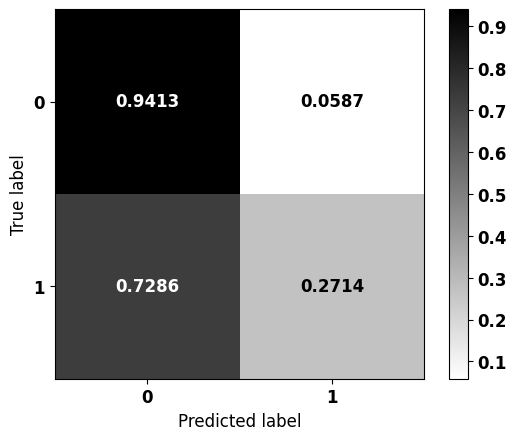


              precision    recall  f1-score   support

           0     0.2421    0.9413    0.3851      5180
           1     0.9492    0.2714    0.4221     20953

    accuracy                         0.4042     26133
   macro avg     0.5957    0.6063    0.4036     26133
weighted avg     0.8091    0.4042    0.4147     26133



In [ ]:
plot_confusion_matrix(best, mama_teste, saida_mama)

### **Pele**

In [ ]:
saida_pele = pele_teste.sobrevida_3anos
pele_teste = pele_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pele_teste.shape)
pele_teste.head(3)

(25221, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
4  0.324125 -0.916019 -0.841077   1.167751 -0.344597 -0.429061  0.315561   
5  0.701083 -0.916019  0.447649   1.167751 -0.344597 -0.429061  0.315561   
7 -0.052834 -0.916019  0.069663  -0.808623 -0.344597 -0.429061  0.315561   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
4 -0.242155 -0.156064  -0.03833  ...  0.591376  -0.20941 -0.716428  1.436258   
5 -0.242155 -0.156064  -0.03833  ... -0.689569  -0.20941  0.240058 -0.214815   
7 -0.242155 -0.156064  -0.03833  ...  1.872320  -0.20941  0.813950 -0.398268   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
4  0.636483 -1.212419  0.393904         -1.404163           -0.776427   
5 -0.234417 -1.110069 -1.165675          1.588451           -0.776427   
7  0.926783 -1.212419  0.393904         -0.406625           -0.776427   

   presenca_rec  
4     -0.218179  
5     -0.218179  
7     -0.218179  

[3 rows x 23 columns]

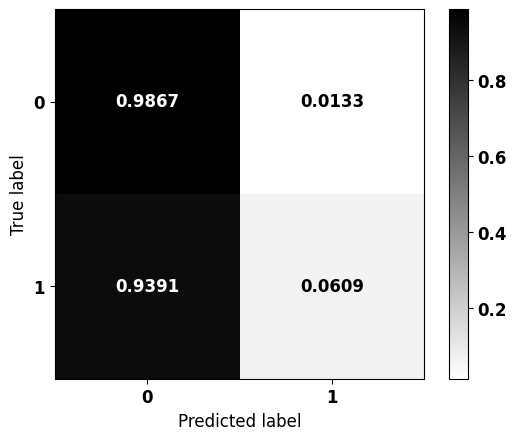


              precision    recall  f1-score   support

           0     0.2388    0.9867    0.3845      5799
           1     0.9388    0.0609    0.1143     19422

    accuracy                         0.2737     25221
   macro avg     0.5888    0.5238    0.2494     25221
weighted avg     0.7779    0.2737    0.1764     25221



In [ ]:
plot_confusion_matrix(best, pele_teste, saida_pele)

### **Próstata**

In [ ]:
saida_prost = prost_teste.sobrevida_3anos
prost_teste = prost_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(prost_teste.shape)
prost_teste.head(3)

(20862, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV       EC  CIRURGIA  \
3   0.149237   0.0  1.316000  -0.695899  0.723032 -0.63168 -0.879627   
12 -1.225865   0.0  0.958232  -0.695899  0.723032  0.27992  1.136845   
18 -0.423722   0.0 -0.370160  -0.695899  0.723032 -1.99908 -0.879627   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
3   1.381841 -0.308078  1.085991  ... -0.418644 -0.208982  0.051988  0.032404   
12 -0.723672 -0.308078 -0.920818  ... -0.418644 -0.208982  0.841591 -1.029723   
18  1.381841 -0.308078 -0.920818  ... -0.418644 -0.208982  1.236393  0.032404   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
3   1.523967 -0.540997 -0.971798         -0.714113           -0.906043   
12 -0.860966  0.842650  0.451912          0.355595            1.103700   
18  1.523967 -0.540997 -0.971798          1.425303           -0.906043   

    presenca_rec  
3      -0.414926  
12     -0.414926  
18     -0.414926  

[3 rows x 23 columns]

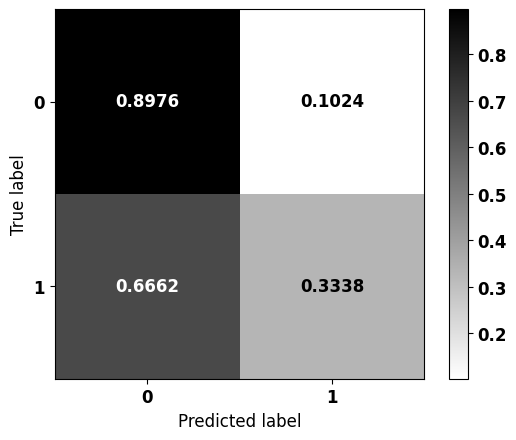


              precision    recall  f1-score   support

           0     0.2060    0.8976    0.3351      3369
           1     0.9442    0.3338    0.4933     17493

    accuracy                         0.4249     20862
   macro avg     0.5751    0.6157    0.4142     20862
weighted avg     0.8250    0.4249    0.4677     20862



In [ ]:
plot_confusion_matrix(best, prost_teste, saida_prost)

### **Pulmão**

In [ ]:
saida_pulm = pulm_teste.sobrevida_3anos
pulm_teste = pulm_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pulm_teste.shape)
pulm_teste.head(3)

(9252, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
8  -0.805560 -0.778211  0.751797  -0.853227  1.364883 -0.536078 -0.468319   
27  0.123762  1.284999  0.990635  -0.853227  1.364883  0.640728 -0.468319   
33  0.960153 -0.778211  0.844979   1.133388 -0.732664 -2.889689  2.135297   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
8  -0.748999 -1.335116 -0.070691  ... -0.403143 -0.432328  0.663596 -0.846783   
27 -0.748999  0.748999 -0.070691  ... -0.403143 -0.459489  1.022562 -0.846783   
33 -0.748999 -1.335116 -0.070691  ...  1.394771 -0.459489  0.304629 -0.846783   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
8  -1.881064  0.667417 -1.225737          0.274789            0.973507   
27 -1.171009  0.755208  0.238090          0.274789           -1.027214   
33 -0.697638  0.755208  0.238090         -0.775222            0.973507   

    presenca_rec  
8      -0.407845  
27      2.451912  
33      2.451912  

[3 rows x 23 columns]

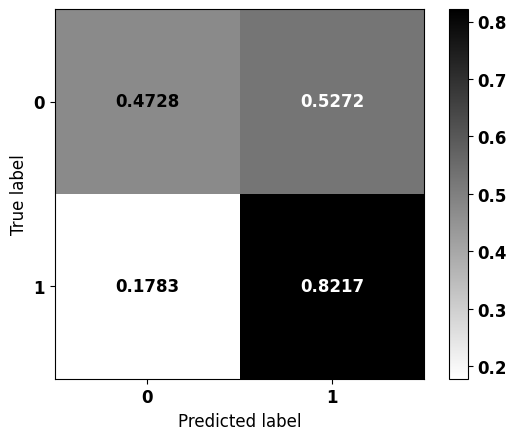


              precision    recall  f1-score   support

           0     0.9446    0.4728    0.6302      8007
           1     0.1951    0.8217    0.3153      1245

    accuracy                         0.5198      9252
   macro avg     0.5698    0.6473    0.4728      9252
weighted avg     0.8437    0.5198    0.5878      9252



In [ ]:
plot_confusion_matrix(best, pulm_teste, saida_pulm)

### **Colo de Útero**

In [ ]:
saida_colo_utero = colo_utero_teste.sobrevida_3anos
colo_utero_teste = colo_utero_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_utero_teste.shape)
colo_utero_teste.head(3)

(5368, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
40  0.519132   0.0  0.929895  -0.892955 -1.099583 -2.175331  1.259960   
63  0.722950   0.0  0.009041  -0.892955  0.909436  0.794350 -0.793676   
76 -0.092323   0.0  1.103217  -0.892955  0.909436  0.794350  1.259960   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
40 -1.349244 -0.933285 -0.087376  ...  4.004901 -0.269490  0.413337 -0.892417   
63 -1.349244 -0.933285 -0.087376  ... -0.292508  4.381396  0.936614 -0.892417   
76 -1.349244  1.071484 -0.087376  ... -0.292508 -0.175532  0.936614  1.467974   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
40 -0.710476  0.814678  0.639879         -1.668349            1.088759   
63 -0.936297  0.814678  0.639879         -0.614620           -0.918477   
76  1.321912 -1.416945  0.639879         -0.614620           -0.918477   

    presenca_rec  
40     -0.459887  
63     -0.459887  
76      2.174445  

[3 rows x 23 columns]

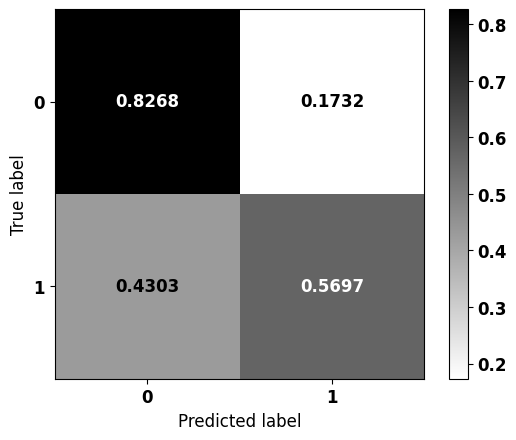


              precision    recall  f1-score   support

           0     0.5921    0.8268    0.6900      2310
           1     0.8133    0.5697    0.6700      3058

    accuracy                         0.6803      5368
   macro avg     0.7027    0.6982    0.6800      5368
weighted avg     0.7181    0.6803    0.6786      5368



In [ ]:
plot_confusion_matrix(best, colo_utero_teste, saida_colo_utero)

# **Pulmão**

In [ ]:
# Leitura dos dados de colo de útero
print(df_pulm.shape)
df_pulm.head(3)

(37005, 32)


IDADE  SEXO     IBGE  CATEATEND  DIAGPREV  TOPO TOPOGRUP  EC TRATHOSP  \
0     57     1  3518701          9         2  C349      C34  IV        C   
1     52     2  3513504          9         1  C341      C34  IV        E   
2     65     1  3518701          9         1  C349      C34  IV        E   

   NENHUM  ...  RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  \
0       0  ...     7   3518701         1               3.0   
1       0  ...     7   3518701         1               3.0   
2       0  ...     7   3518701         1               2.0   

   IBGE_idem_IBGEATEN  presenca_rec  obito_geral  sobrevida_ano1  \
0                   1             0            1               0   
1                   0             0            1               1   
2                   1             0            1               0   

   sobrevida_ano3  sobrevida_ano5  
0               0               0  
1               0               0  
2               0               0  

[3 rows x 32 columns]

In [ ]:
# Valores faltantes
df_pulm.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df_pulm.corr(numeric_only=True)
abs(corr_matrix['sobrevida_ano3']).sort_values(ascending = False).head(20)

sobrevida_ano3      1.000000
sobrevida_ano5      0.685950
obito_geral         0.630753
sobrevida_ano1      0.500594
CIRURGIA            0.344221
DIAGTRAT            0.149297
TRATCONS            0.148932
NENHUM              0.146357
presenca_rec        0.140548
CONSDIAG            0.099161
CATEATEND           0.084835
SEXO                0.081044
ESCOLARI_preench    0.079855
IDADE               0.045592
IMUNO               0.044318
OUTROS              0.041023
ANODIAG             0.038819
IBGEATEN            0.030325
DIAGPREV            0.025450
HORMONIO            0.021158
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_pulm.sobrevida_ano3.value_counts()

0    32025
1     4980
Name: sobrevida_ano3, dtype: int64

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_pulm,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (27753, 23), X_test = (9252, 23)
y_train = (27753,), y_test = (9252,)


In [ ]:
y_train.value_counts(normalize=True)

0    0.86542
1    0.13458
Name: sobrevida_ano3, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.865435
1    0.134565
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Dataset de treinamento de Pulmão
pulm_treino = pd.DataFrame(X_train, columns=feat_cols)
pulm_treino['TOPOGRUP'] = 'Pulmão'
pulm_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Pulmão
pulm_teste = pd.DataFrame(X_test, columns=feat_cols)
pulm_teste['TOPOGRUP'] = 'Pulmão'
pulm_teste['sobrevida_3anos'] = y_test.values

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

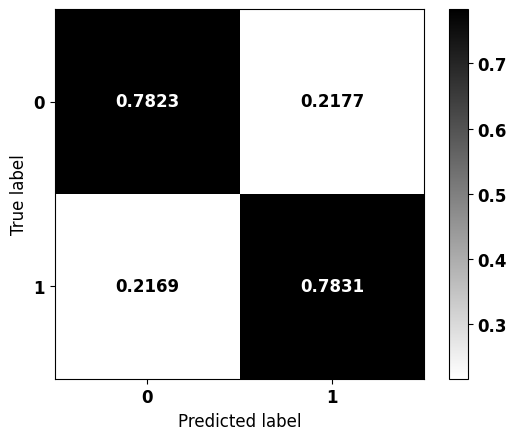


              precision    recall  f1-score   support

           0     0.9587    0.7823    0.8616      8007
           1     0.3587    0.7831    0.4921      1245

    accuracy                         0.7824      9252
   macro avg     0.6587    0.7827    0.6768      9252
weighted avg     0.8779    0.7824    0.8118      9252



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=7.27,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

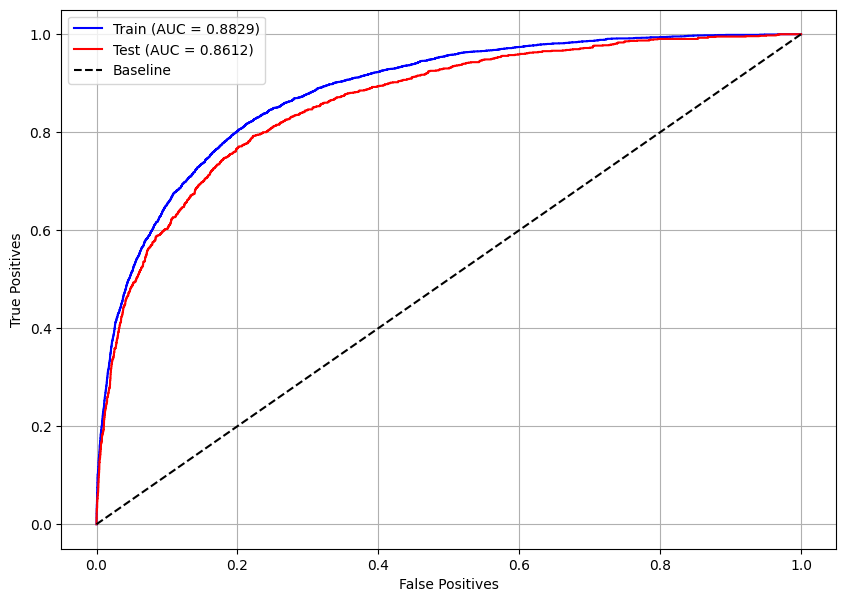

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

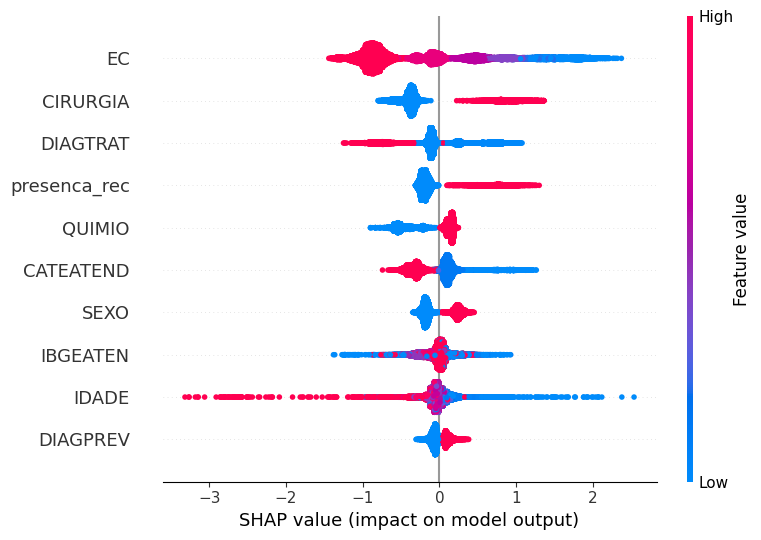

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 69,
 'max_depth': 4,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.3,
 'min_child_weight': 5,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(7.2, 7.4, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

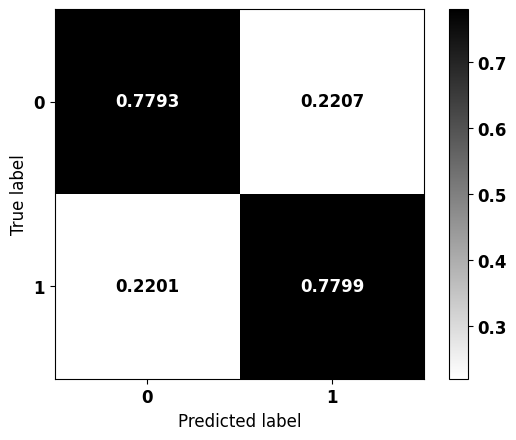


              precision    recall  f1-score   support

           0     0.9579    0.7793    0.8594      8007
           1     0.3546    0.7799    0.4876      1245

    accuracy                         0.7794      9252
   macro avg     0.6563    0.7796    0.6735      9252
weighted avg     0.8768    0.7794    0.8094      9252



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 7.255

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

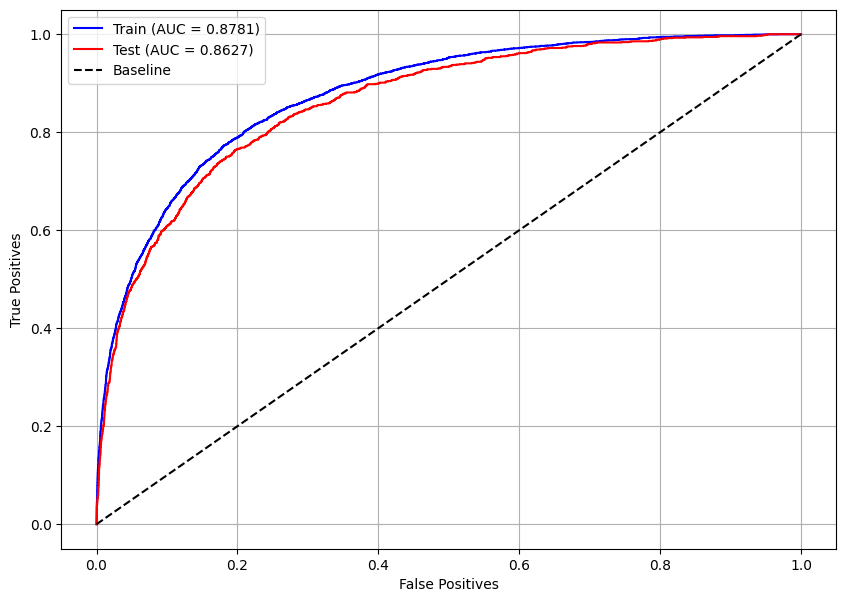

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 80,
 'max_depth': 4,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 7,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(7.28, 7.3, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

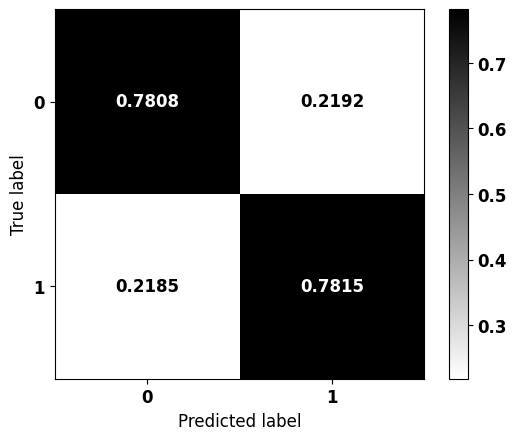


              precision    recall  f1-score   support

           0     0.9583    0.7808    0.8605      8007
           1     0.3567    0.7815    0.4898      1245

    accuracy                         0.7809      9252
   macro avg     0.6575    0.7812    0.6752      9252
weighted avg     0.8773    0.7809    0.8106      9252



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 7.292

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

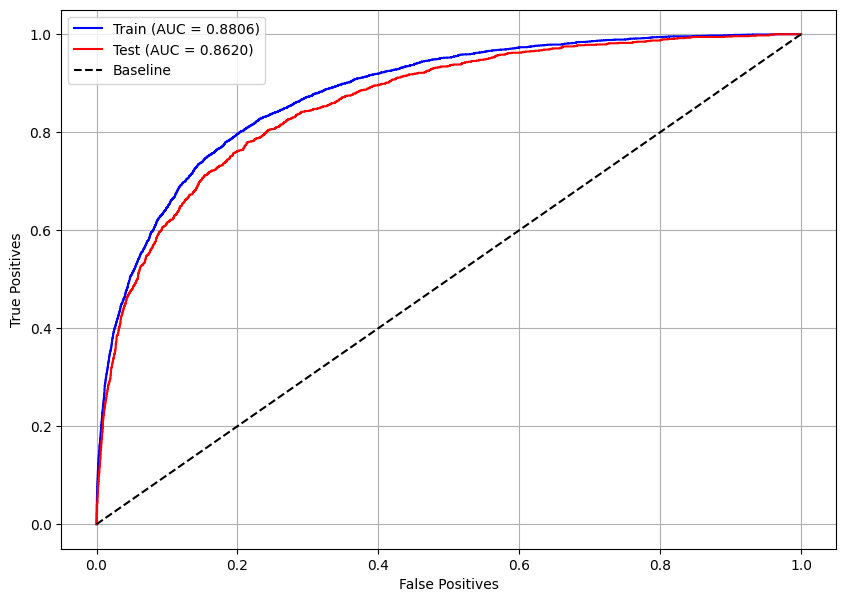

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 126,
 'max_depth': 4,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(7.2, 7.4, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

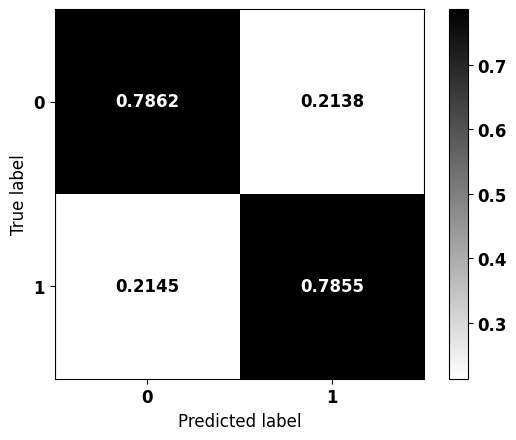


              precision    recall  f1-score   support

           0     0.9593    0.7862    0.8642      8007
           1     0.3636    0.7855    0.4971      1245

    accuracy                         0.7861      9252
   macro avg     0.6614    0.7859    0.6806      9252
weighted avg     0.8791    0.7861    0.8148      9252



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 7.256

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

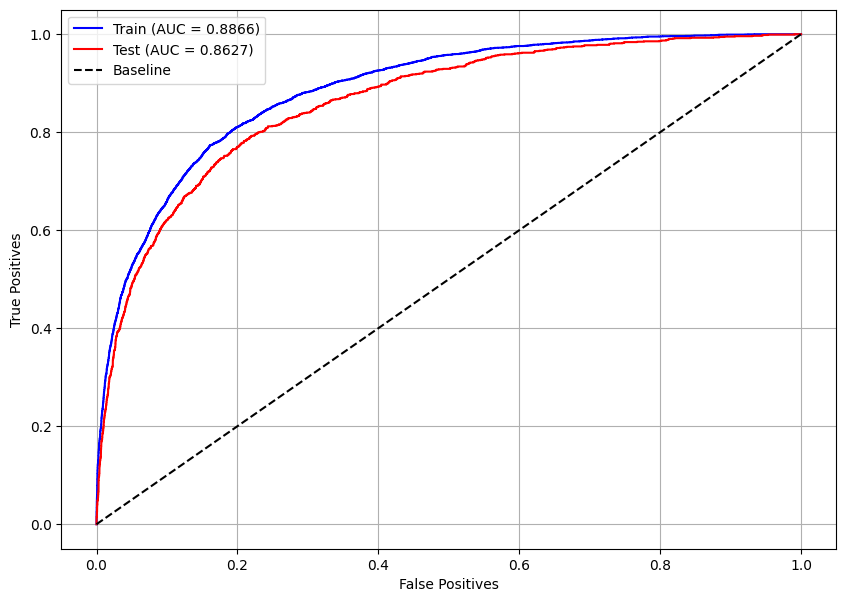

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15000000000000002,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=126, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


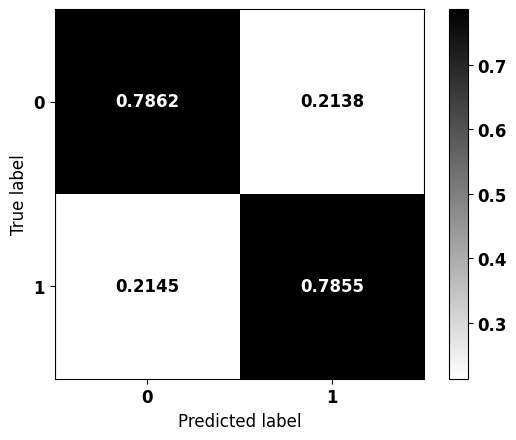


              precision    recall  f1-score   support

           0     0.9593    0.7862    0.8642      8007
           1     0.3636    0.7855    0.4971      1245

    accuracy                         0.7861      9252
   macro avg     0.6614    0.7859    0.6806      9252
weighted avg     0.8791    0.7861    0.8148      9252



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

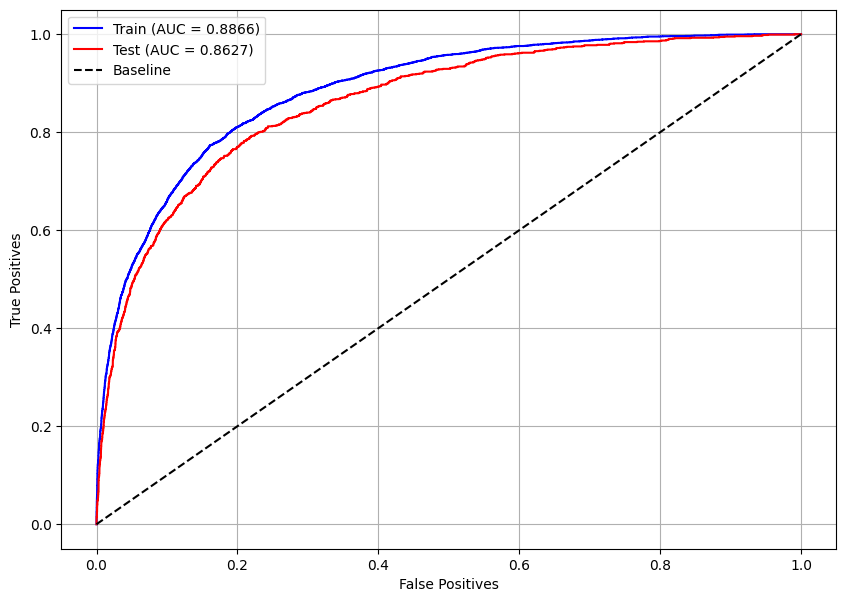

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

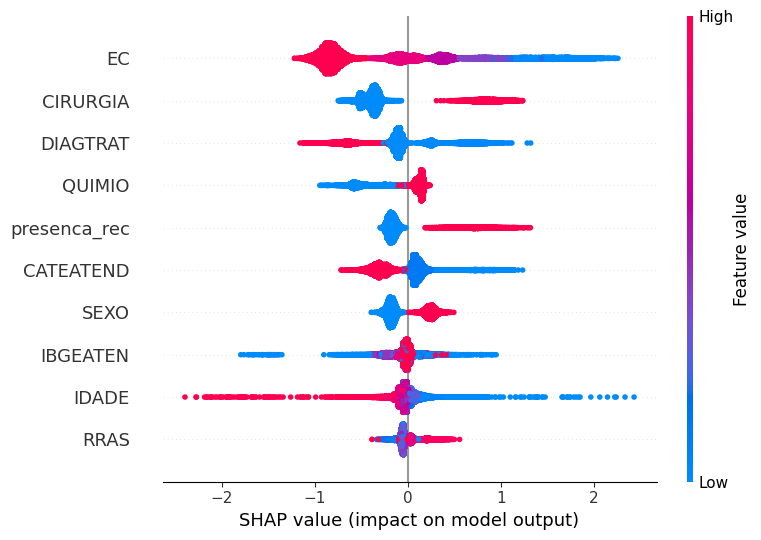

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

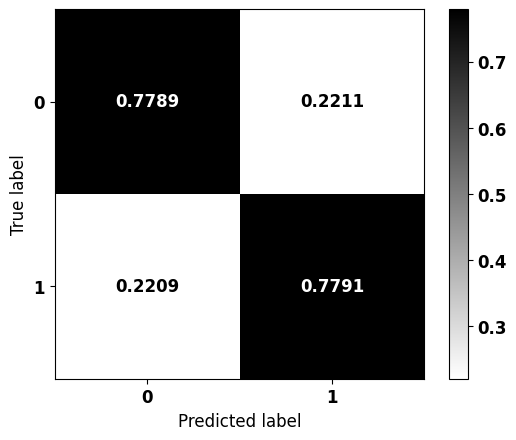


              precision    recall  f1-score   support

           0     0.9578    0.7789    0.8592      8007
           1     0.3540    0.7791    0.4868      1245

    accuracy                         0.7790      9252
   macro avg     0.6559    0.7790    0.6730      9252
weighted avg     0.8765    0.7790    0.8090      9252



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=4,
                      class_weight={0:1, 1:7.2},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

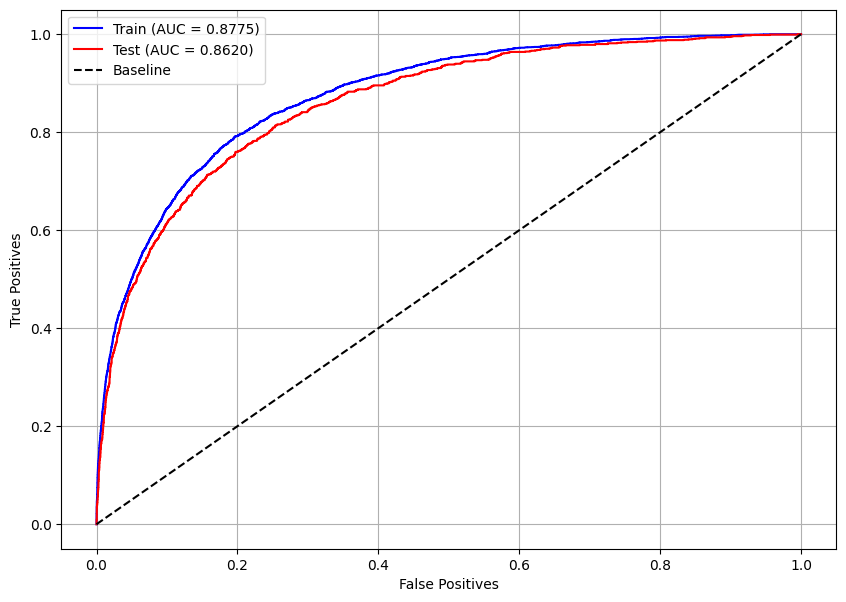

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

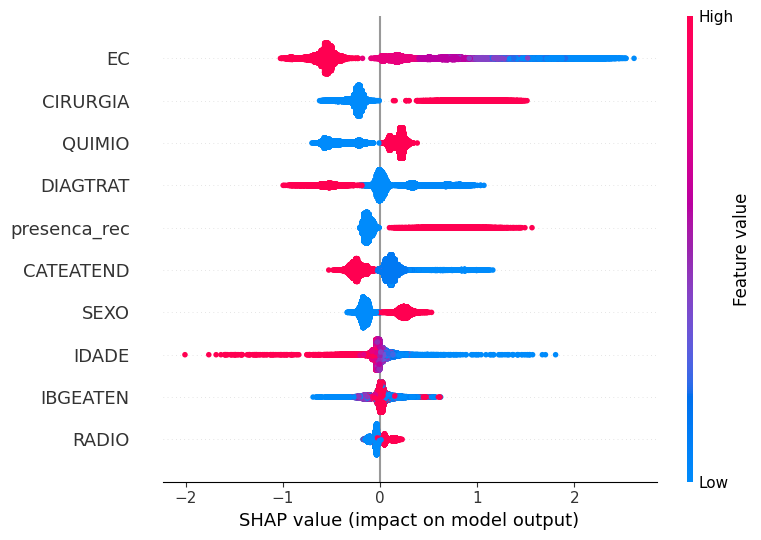

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 68,
 'max_depth': 5,
 'learning_rate': 0.16999999999999998,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(8.3, 8.8, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

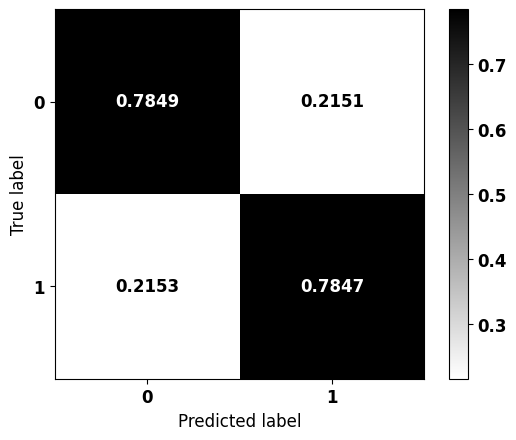


              precision    recall  f1-score   support

           0     0.9591    0.7849    0.8633      8007
           1     0.3620    0.7847    0.4954      1245

    accuracy                         0.7849      9252
   macro avg     0.6605    0.7848    0.6794      9252
weighted avg     0.8788    0.7849    0.8138      9252



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:7.32}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

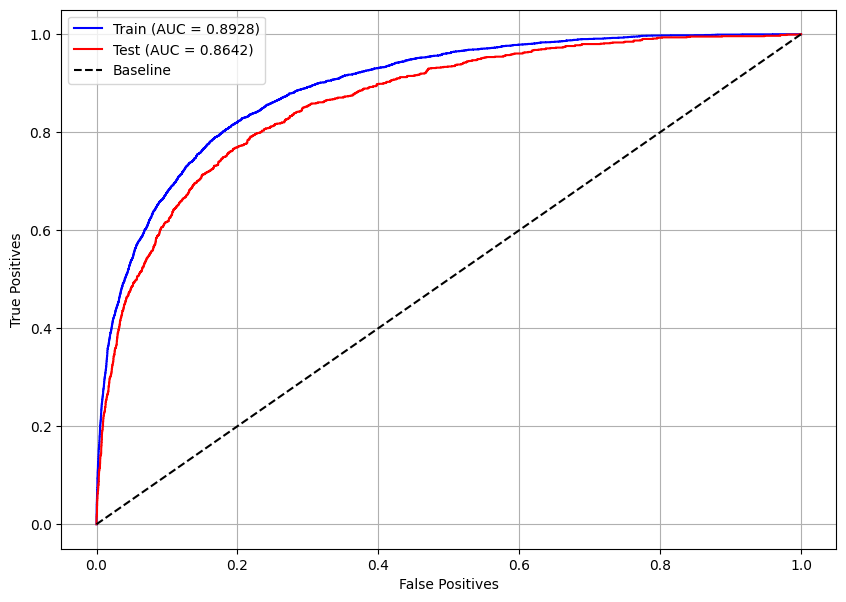

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 92,
 'max_depth': 5,
 'learning_rate': 0.11,
 'min_child_weight': 5,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(7.35, 7.55, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

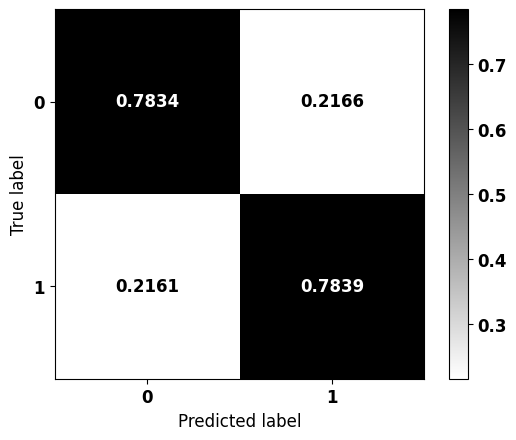


              precision    recall  f1-score   support

           0     0.9589    0.7834    0.8623      8007
           1     0.3601    0.7839    0.4936      1245

    accuracy                         0.7835      9252
   macro avg     0.6595    0.7837    0.6779      9252
weighted avg     0.8783    0.7835    0.8127      9252



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:7.469}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

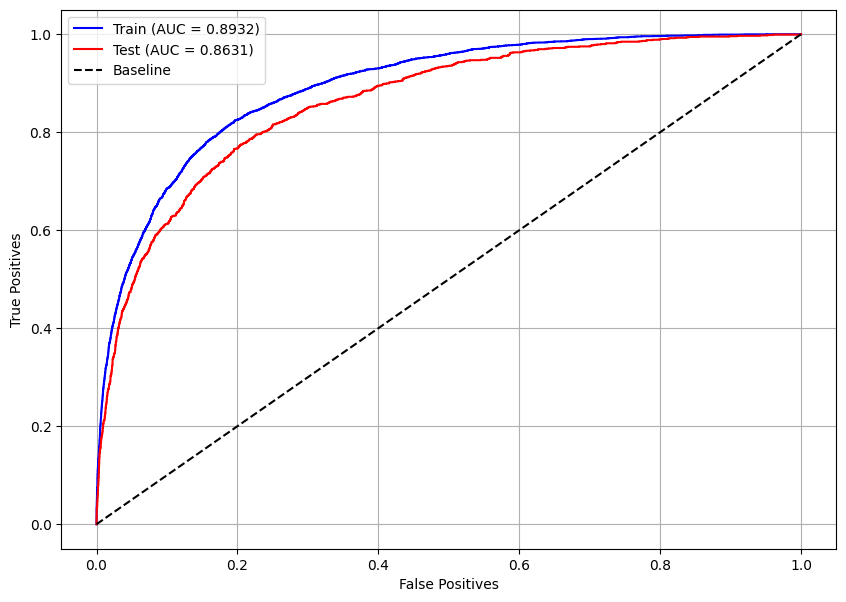

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 112,
 'max_depth': 5,
 'learning_rate': 0.08,
 'min_child_weight': 6,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(7.2, 7.45, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

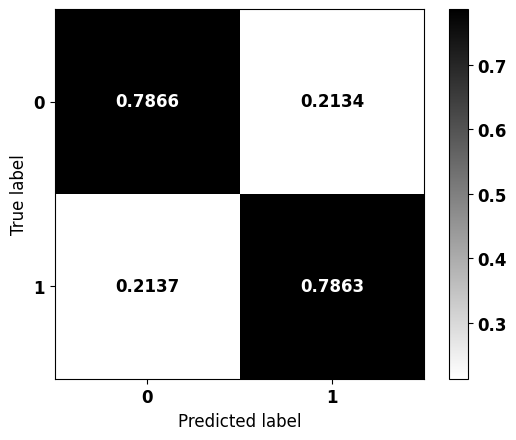


              precision    recall  f1-score   support

           0     0.9595    0.7866    0.8645      8007
           1     0.3642    0.7863    0.4978      1245

    accuracy                         0.7865      9252
   macro avg     0.6618    0.7865    0.6811      9252
weighted avg     0.8794    0.7865    0.8151      9252



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:7.25}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

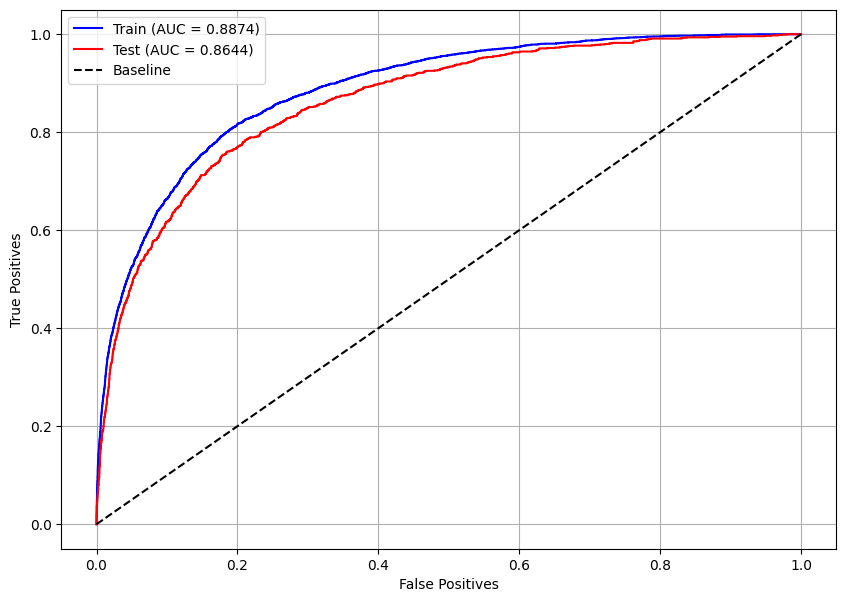

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 7.25}, colsample_bytree=0.5,
               learning_rate=0.08, max_depth=5, min_child_weight=6,
               n_estimators=112, random_state=7, verbose=-1)


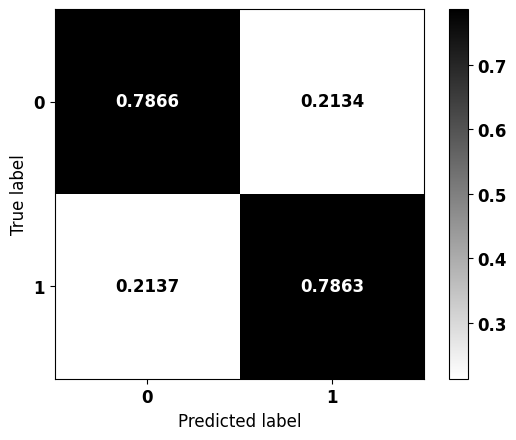


              precision    recall  f1-score   support

           0     0.9595    0.7866    0.8645      8007
           1     0.3642    0.7863    0.4978      1245

    accuracy                         0.7865      9252
   macro avg     0.6618    0.7865    0.6811      9252
weighted avg     0.8794    0.7865    0.8151      9252



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

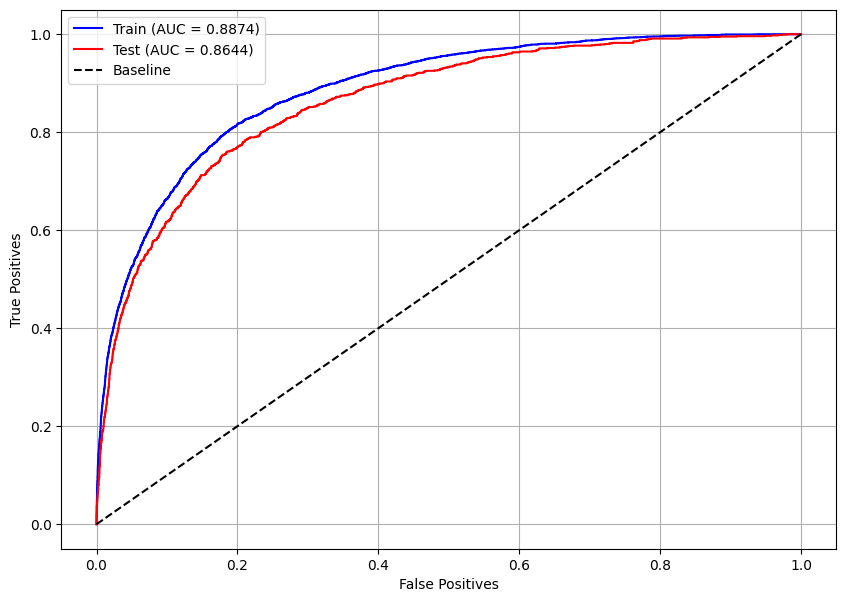

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

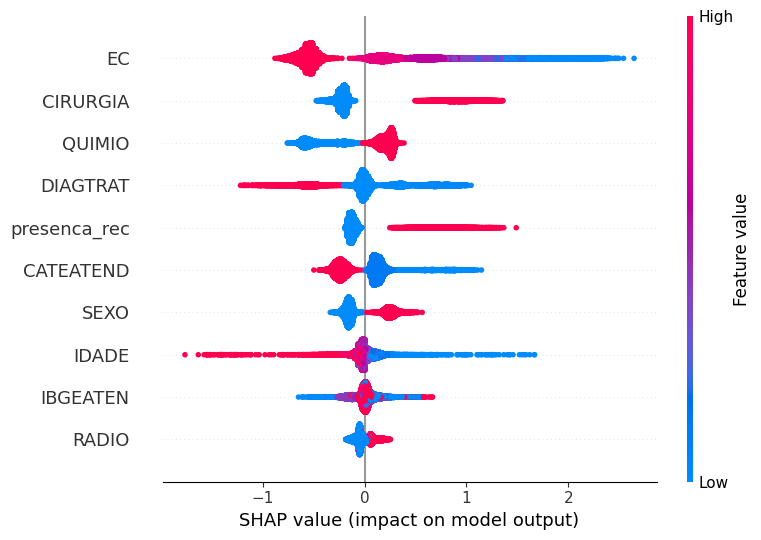

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7824, Optuna = 0.7861

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7790, Optuna = 0.7865

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 7.25}, colsample_bytree=0.5,
               learning_rate=0.08, max_depth=5, min_child_weight=6,
               n_estimators=112, random_state=7, verbose=-1)

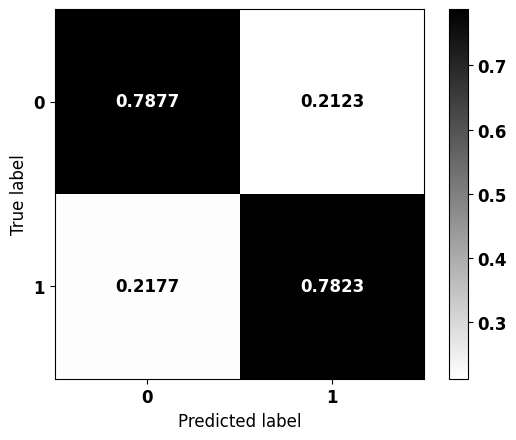


              precision    recall  f1-score   support

           0     0.9588    0.7877    0.8649      8007
           1     0.3642    0.7823    0.4971      1245

    accuracy                         0.7870      9252
   macro avg     0.6615    0.7850    0.6810      9252
weighted avg     0.8788    0.7870    0.8154      9252



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

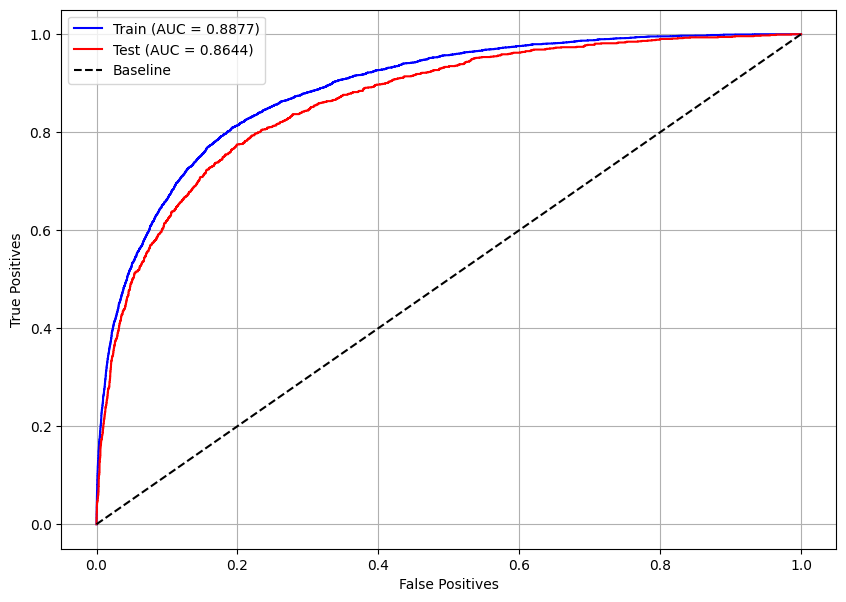

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 7.25}, colsample_bytree=0.5,
               learning_rate=0.08, max_depth=5, min_child_weight=6,
               n_estimators=112, random_state=7, verbose=-1)


In [ ]:
# Dados para testar
!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF # Mais incidentes - Teste

df_teste = pd.read_csv('incid_teste.csv')

mama_teste = df_teste[df_teste.TOPOGRUP.isin(['Mama'])]
pele_teste = df_teste[df_teste.TOPOGRUP.isin(['Pele'])]
prost_teste = df_teste[df_teste.TOPOGRUP.isin(['Próstata'])]
colo_teste = df_teste[df_teste.TOPOGRUP.isin(['Colorretal'])]
pulm_teste = df_teste[df_teste.TOPOGRUP.isin(['Pulmão'])]
colo_utero_teste = df_teste[df_teste.TOPOGRUP.isin(['Colo de Útero'])]

mama_teste.shape, pele_teste.shape, prost_teste.shape, colo_teste.shape, pulm_teste.shape, colo_utero_teste.shape

Downloading...
From: https://drive.google.com/uc?id=194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF
To: /content/incid_teste.csv
100% 46.4M/46.4M [00:00<00:00, 159MB/s]


((26133, 25), (25221, 25), (20862, 25), (14028, 25), (9252, 25), (5368, 25))

### **Mama**

In [ ]:
saida_mama = mama_teste.sobrevida_3anos
mama_teste = mama_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(mama_teste.shape)
mama_teste.head(3)

(26133, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
2  -0.623264  0.078323 -0.758504   1.270371 -0.915765 -1.584428    0.5453   
10 -0.549923  0.078323  1.068808  -0.747659 -0.915765 -0.339226    0.5453   
11  0.110146  0.078323  0.854448   1.270371 -0.915765 -1.584428    0.5453   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
2   1.015205 -1.536653  0.848079  ...  2.956862 -0.190274 -0.446767 -0.851058   
10  1.015205  0.650765  0.848079  ...  2.956862 -0.190274 -1.367290  1.932872   
11  1.015205  0.650765  0.848079  ...  1.273530 -0.190274 -1.735499 -0.851058   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
2  -0.888302  0.743452 -0.803767          0.967430           -1.048322   
10 -0.205138 -1.642306 -0.803767         -0.940442           -1.048322   
11 -0.660580  0.743452  0.599581          1.921366            0.953905   

    presenca_rec  
2       -0.51497  
10      -0.51497  
11      -0.51497  

[3 rows x 23 columns]

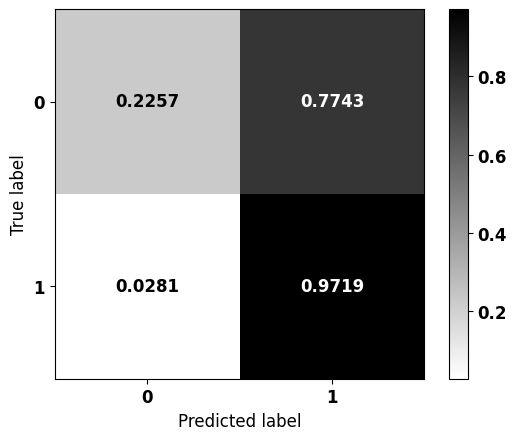


              precision    recall  f1-score   support

           0     0.6650    0.2257    0.3370      5180
           1     0.8354    0.9719    0.8985     20953

    accuracy                         0.8240     26133
   macro avg     0.7502    0.5988    0.6178     26133
weighted avg     0.8017    0.8240    0.7872     26133



In [ ]:
plot_confusion_matrix(best, mama_teste, saida_mama)

### **Pele**

In [ ]:
saida_pele = pele_teste.sobrevida_3anos
pele_teste = pele_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pele_teste.shape)
pele_teste.head(3)

(25221, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
4  0.324125 -0.916019 -0.841077   1.167751 -0.344597 -0.429061  0.315561   
5  0.701083 -0.916019  0.447649   1.167751 -0.344597 -0.429061  0.315561   
7 -0.052834 -0.916019  0.069663  -0.808623 -0.344597 -0.429061  0.315561   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
4 -0.242155 -0.156064  -0.03833  ...  0.591376  -0.20941 -0.716428  1.436258   
5 -0.242155 -0.156064  -0.03833  ... -0.689569  -0.20941  0.240058 -0.214815   
7 -0.242155 -0.156064  -0.03833  ...  1.872320  -0.20941  0.813950 -0.398268   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
4  0.636483 -1.212419  0.393904         -1.404163           -0.776427   
5 -0.234417 -1.110069 -1.165675          1.588451           -0.776427   
7  0.926783 -1.212419  0.393904         -0.406625           -0.776427   

   presenca_rec  
4     -0.218179  
5     -0.218179  
7     -0.218179  

[3 rows x 23 columns]

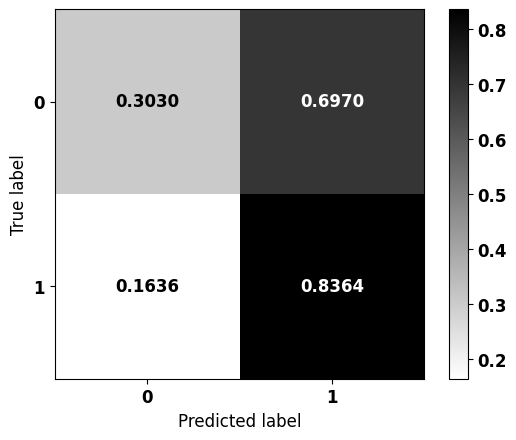


              precision    recall  f1-score   support

           0     0.3560    0.3030    0.3274      5799
           1     0.8007    0.8364    0.8182     19422

    accuracy                         0.7137     25221
   macro avg     0.5784    0.5697    0.5728     25221
weighted avg     0.6985    0.7137    0.7053     25221



In [ ]:
plot_confusion_matrix(best, pele_teste, saida_pele)

### **Próstata**

In [ ]:
saida_prost = prost_teste.sobrevida_3anos
prost_teste = prost_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(prost_teste.shape)
prost_teste.head(3)

(20862, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV       EC  CIRURGIA  \
3   0.149237   0.0  1.316000  -0.695899  0.723032 -0.63168 -0.879627   
12 -1.225865   0.0  0.958232  -0.695899  0.723032  0.27992  1.136845   
18 -0.423722   0.0 -0.370160  -0.695899  0.723032 -1.99908 -0.879627   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
3   1.381841 -0.308078  1.085991  ... -0.418644 -0.208982  0.051988  0.032404   
12 -0.723672 -0.308078 -0.920818  ... -0.418644 -0.208982  0.841591 -1.029723   
18  1.381841 -0.308078 -0.920818  ... -0.418644 -0.208982  1.236393  0.032404   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
3   1.523967 -0.540997 -0.971798         -0.714113           -0.906043   
12 -0.860966  0.842650  0.451912          0.355595            1.103700   
18  1.523967 -0.540997 -0.971798          1.425303           -0.906043   

    presenca_rec  
3      -0.414926  
12     -0.414926  
18     -0.414926  

[3 rows x 23 columns]

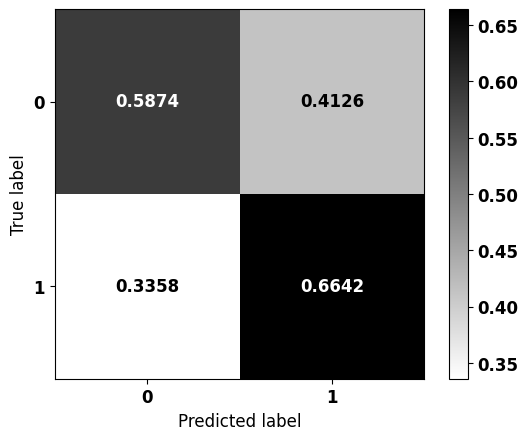


              precision    recall  f1-score   support

           0     0.2520    0.5874    0.3527      3369
           1     0.8931    0.6642    0.7618     17493

    accuracy                         0.6518     20862
   macro avg     0.5726    0.6258    0.5572     20862
weighted avg     0.7896    0.6518    0.6957     20862



In [ ]:
plot_confusion_matrix(best, prost_teste, saida_prost)

### **Colorretal**

In [ ]:
saida_colo = colo_teste.sobrevida_3anos
colo_teste = colo_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_teste.shape)
colo_teste.head(3)

(14028, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
0  0.366829 -0.972134  1.141405   1.343451  0.958036 -0.047542   0.60093   
1 -0.166349 -0.972134 -0.649610   1.343451  0.958036 -0.873817   0.60093   
6 -0.318686 -0.972134 -1.770966  -0.714301  0.958036  1.329585   0.60093   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
0 -0.567847  0.737288  -0.07854  ... -0.325938 -0.193018 -1.734289  1.587885   
1  1.761039  0.737288  -0.07854  ... -0.325938 -0.143566 -0.209650  1.767959   
6 -0.567847  0.737288  -0.07854  ... -0.325938 -0.193018  1.314989 -0.032782   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
0  0.660606 -1.716753  0.396181          1.180668            -1.03687   
1 -0.282288  0.900562 -0.968850          0.154944            -1.03687   
6 -0.046564 -0.607175  0.396181          2.206391            -1.03687   

   presenca_rec  
0     -0.475073  
1     -0.475073  
6     -0.475073  

[3 rows x 23 columns]

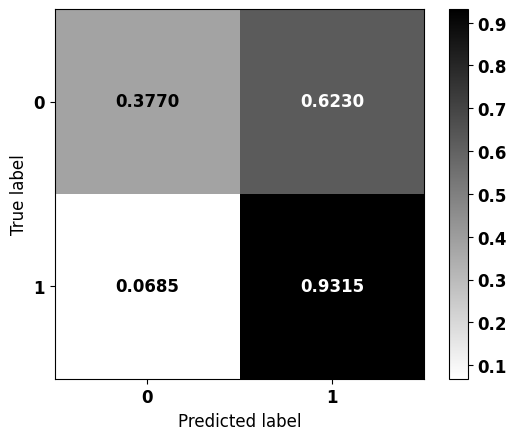


              precision    recall  f1-score   support

           0     0.8166    0.3770    0.5159      6273
           1     0.6489    0.9315    0.7650      7755

    accuracy                         0.6836     14028
   macro avg     0.7328    0.6543    0.6404     14028
weighted avg     0.7239    0.6836    0.6536     14028



In [ ]:
plot_confusion_matrix(best, colo_teste, saida_colo)

### **Colo de Útero**

In [ ]:
saida_colo_utero = colo_utero_teste.sobrevida_3anos
colo_utero_teste = colo_utero_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_utero_teste.shape)
colo_utero_teste.head(3)

(5368, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
40  0.519132   0.0  0.929895  -0.892955 -1.099583 -2.175331  1.259960   
63  0.722950   0.0  0.009041  -0.892955  0.909436  0.794350 -0.793676   
76 -0.092323   0.0  1.103217  -0.892955  0.909436  0.794350  1.259960   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
40 -1.349244 -0.933285 -0.087376  ...  4.004901 -0.269490  0.413337 -0.892417   
63 -1.349244 -0.933285 -0.087376  ... -0.292508  4.381396  0.936614 -0.892417   
76 -1.349244  1.071484 -0.087376  ... -0.292508 -0.175532  0.936614  1.467974   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
40 -0.710476  0.814678  0.639879         -1.668349            1.088759   
63 -0.936297  0.814678  0.639879         -0.614620           -0.918477   
76  1.321912 -1.416945  0.639879         -0.614620           -0.918477   

    presenca_rec  
40     -0.459887  
63     -0.459887  
76      2.174445  

[3 rows x 23 columns]

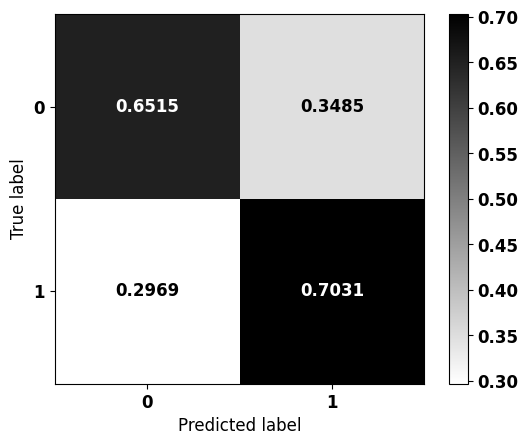


              precision    recall  f1-score   support

           0     0.6237    0.6515    0.6373      2310
           1     0.7276    0.7031    0.7151      3058

    accuracy                         0.6809      5368
   macro avg     0.6756    0.6773    0.6762      5368
weighted avg     0.6829    0.6809    0.6816      5368



In [ ]:
plot_confusion_matrix(best, colo_utero_teste, saida_colo_utero)

# **Colo de Útero**

In [ ]:
# Leitura dos dados de colo de útero
print(df_colo_utero.shape)
df_colo_utero.head(3)

(21470, 32)


IDADE  SEXO     IBGE  CATEATEND  DIAGPREV  TOPO TOPOGRUP    EC TRATHOSP  \
0     56     2  3518701          9         2  C530      C53   IB1        G   
1     72     2  3518701          9         1  C539      C53  IIIB        C   
2     63     2  3518701          9         1  C539      C53   IB1        E   

   NENHUM  ...  RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  \
0       0  ...     7   3518701         1               1.0   
1       0  ...     7   3518701         1               2.0   
2       0  ...     7   3518701         1               3.0   

   IBGE_idem_IBGEATEN  presenca_rec  obito_geral  sobrevida_ano1  \
0                   1             0            1               1   
1                   1             0            1               0   
2                   1             0            1               1   

   sobrevida_ano3  sobrevida_ano5  
0               0               0  
1               0               0  
2               0               0  

[3 rows x 32 columns]

In [ ]:
# Valores faltantes
df_colo_utero.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df_colo_utero.corr(numeric_only=True)
abs(corr_matrix['sobrevida_ano3']).sort_values(ascending=False).head(20)

sobrevida_ano3        1.000000
sobrevida_ano5        0.728169
obito_geral           0.705855
sobrevida_ano1        0.579727
CIRURGIA              0.329928
NENHUM                0.205218
DIAGTRAT              0.204454
TRATCONS              0.204275
IDADE                 0.132466
presenca_rec          0.107527
ESCOLARI_preench      0.077086
CONSDIAG              0.076845
QUIMIO                0.068720
RADIO                 0.055565
CATEATEND             0.051442
OUTROS                0.045452
IBGEATEN              0.044755
RRAS                  0.033182
DIAGPREV              0.030029
IBGE_idem_IBGEATEN    0.029533
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_colo_utero.sobrevida_ano3.value_counts()

1    12231
0     9239
Name: sobrevida_ano3, dtype: int64

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_colo_utero,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (16102, 23), X_test = (5368, 23)
y_train = (16102,), y_test = (5368,)


In [ ]:
y_train.value_counts(normalize=True)

1    0.569681
0    0.430319
Name: sobrevida_ano3, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.569672
0    0.430328
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Dataset de treinamento de Colo de Útero
colo_utero_treino = pd.DataFrame(X_train, columns=feat_cols)
colo_utero_treino['TOPOGRUP'] = 'Colo de Útero'
colo_utero_treino['sobrevida_3anos'] = y_train.values

# Dataset de teste de Colo de Útero
colo_utero_teste = pd.DataFrame(X_test, columns=feat_cols)
colo_utero_teste['TOPOGRUP'] = 'Colo de Útero'
colo_utero_teste['sobrevida_3anos'] = y_test.values

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

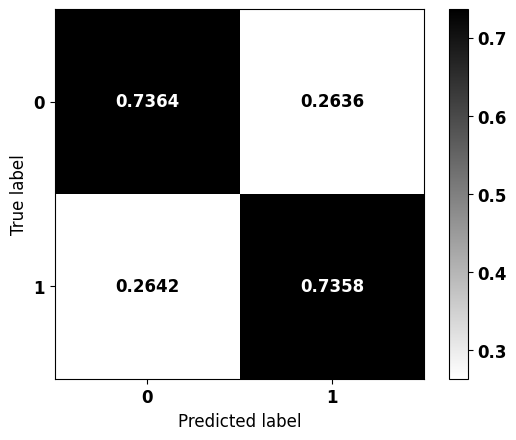


              precision    recall  f1-score   support

           0     0.6780    0.7364    0.7060      2310
           1     0.7870    0.7358    0.7605      3058

    accuracy                         0.7360      5368
   macro avg     0.7325    0.7361    0.7332      5368
weighted avg     0.7401    0.7360    0.7370      5368



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=0.851,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

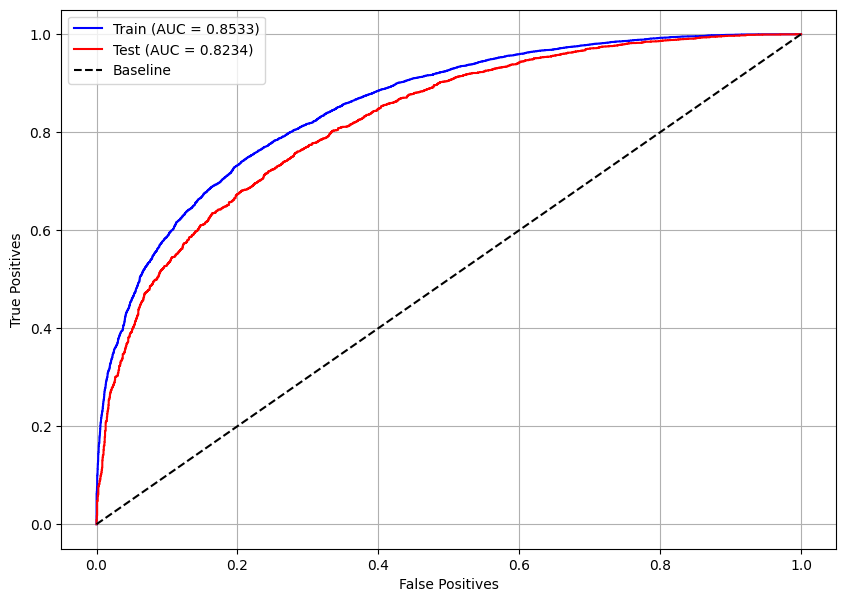

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

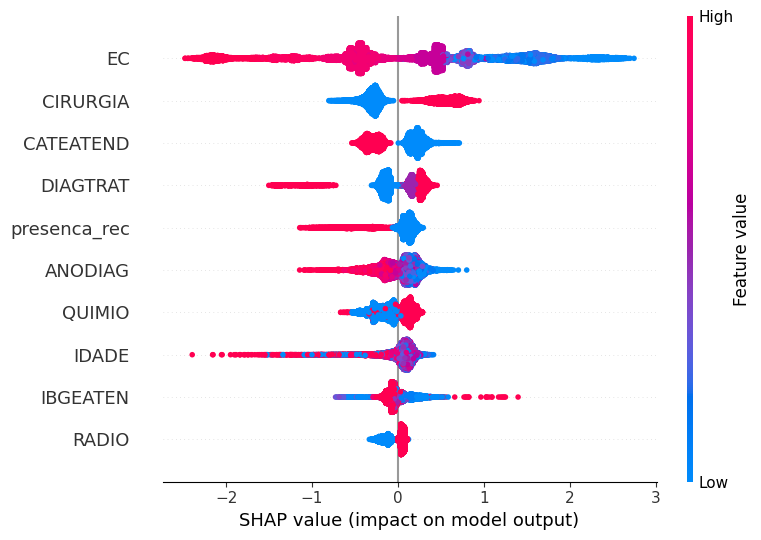

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 144,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 1,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(0.84, 0.875, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

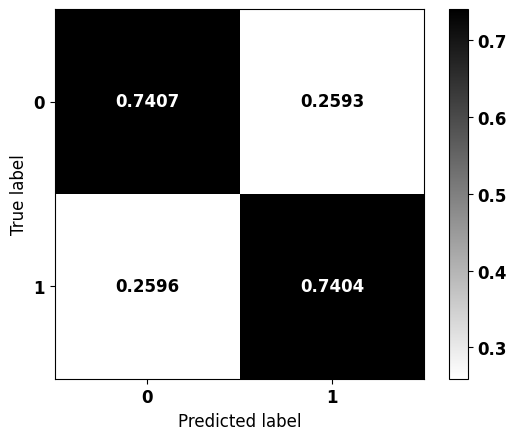


              precision    recall  f1-score   support

           0     0.6830    0.7407    0.7107      2310
           1     0.7908    0.7404    0.7647      3058

    accuracy                         0.7405      5368
   macro avg     0.7369    0.7405    0.7377      5368
weighted avg     0.7444    0.7405    0.7415      5368



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.8483

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

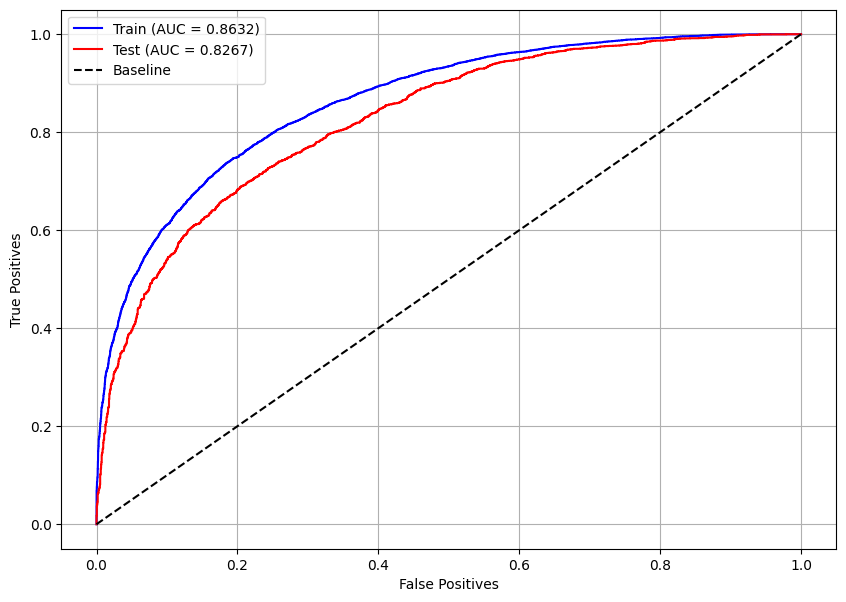

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 120,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 7,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.84, 0.87, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

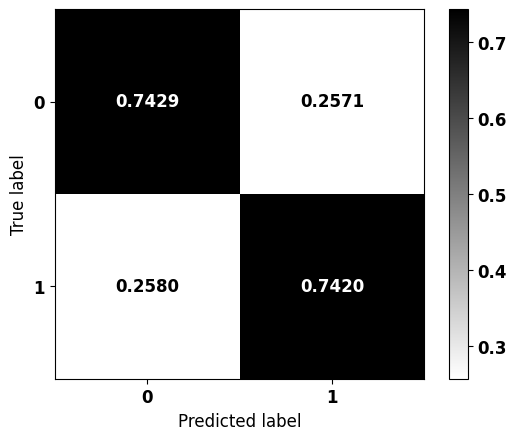


              precision    recall  f1-score   support

           0     0.6850    0.7429    0.7128      2310
           1     0.7925    0.7420    0.7664      3058

    accuracy                         0.7424      5368
   macro avg     0.7388    0.7424    0.7396      5368
weighted avg     0.7463    0.7424    0.7433      5368



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.8551

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

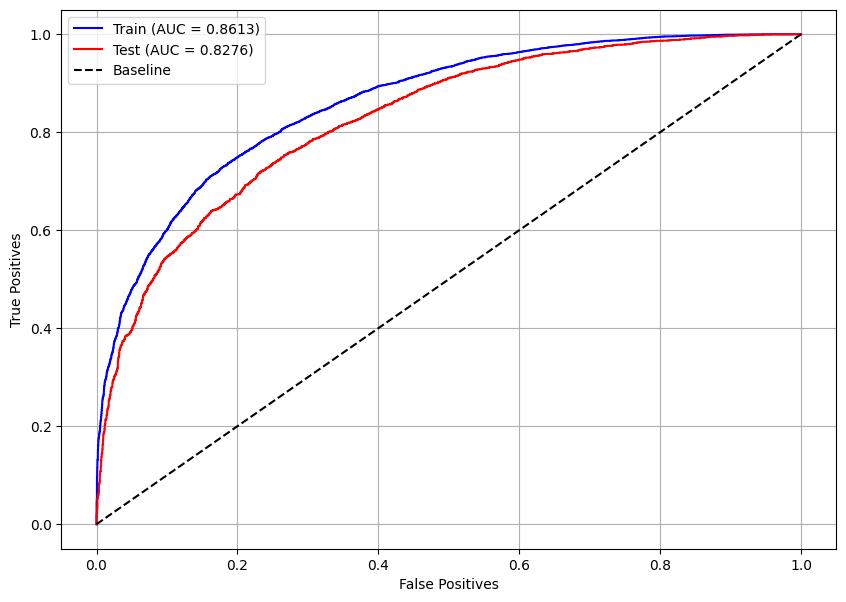

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 107,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 2,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.84, 0.865, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

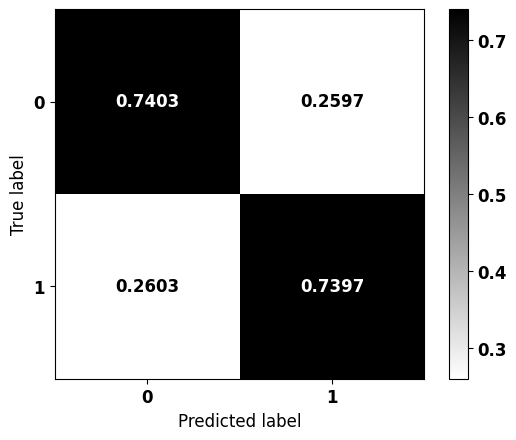


              precision    recall  f1-score   support

           0     0.6824    0.7403    0.7101      2310
           1     0.7904    0.7397    0.7642      3058

    accuracy                         0.7399      5368
   macro avg     0.7364    0.7400    0.7372      5368
weighted avg     0.7439    0.7399    0.7409      5368



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.8518

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

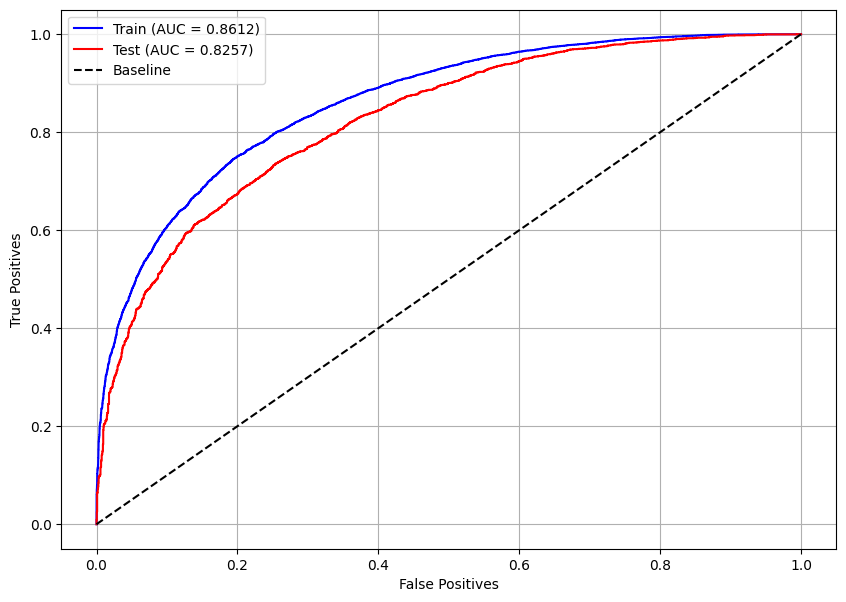

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6000000000000001, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=120,
              n_jobs=None, num_parallel_tree=None, random_state=7, ...)


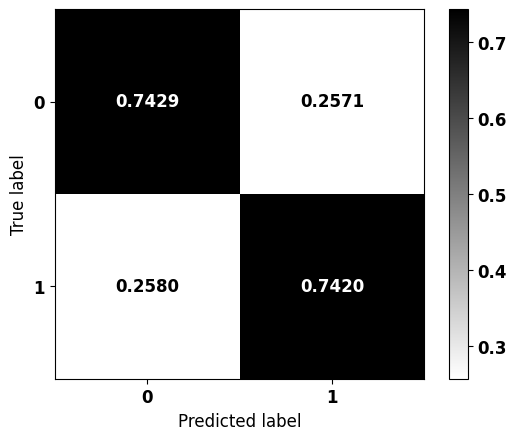


              precision    recall  f1-score   support

           0     0.6850    0.7429    0.7128      2310
           1     0.7925    0.7420    0.7664      3058

    accuracy                         0.7424      5368
   macro avg     0.7388    0.7424    0.7396      5368
weighted avg     0.7463    0.7424    0.7433      5368



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

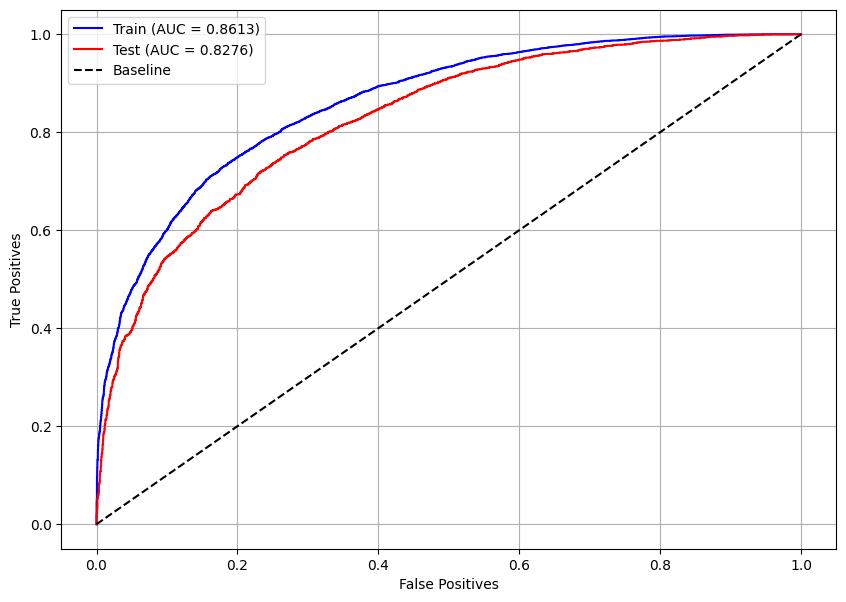

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

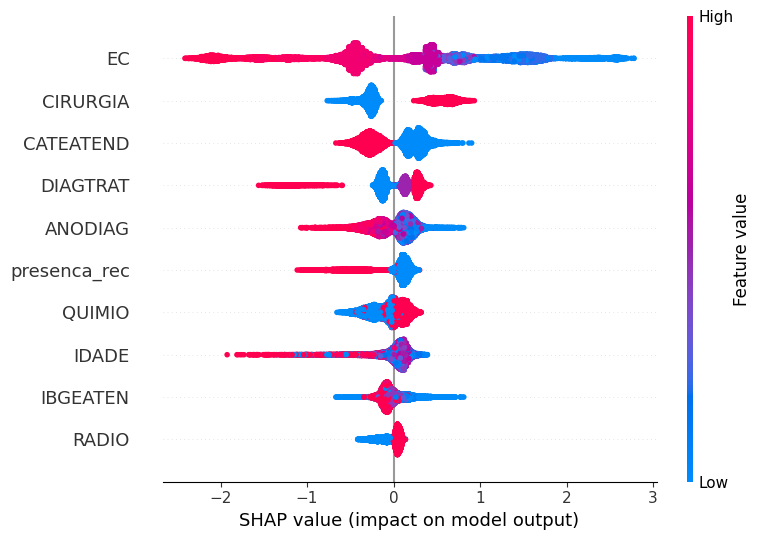

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

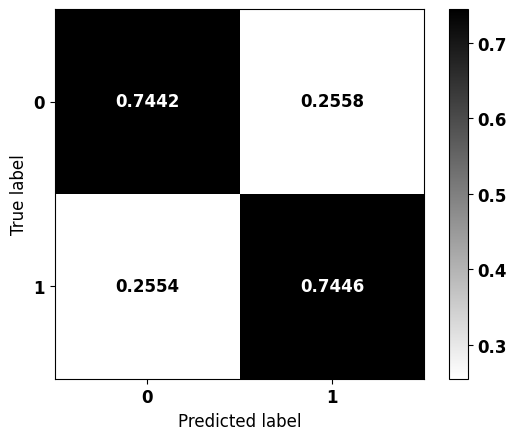


              precision    recall  f1-score   support

           0     0.6876    0.7442    0.7148      2310
           1     0.7939    0.7446    0.7685      3058

    accuracy                         0.7444      5368
   macro avg     0.7408    0.7444    0.7416      5368
weighted avg     0.7482    0.7444    0.7454      5368



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=4,
                      class_weight={0:1.154, 1:1},
                      random_state=seed,
                      importance_type='gain',
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

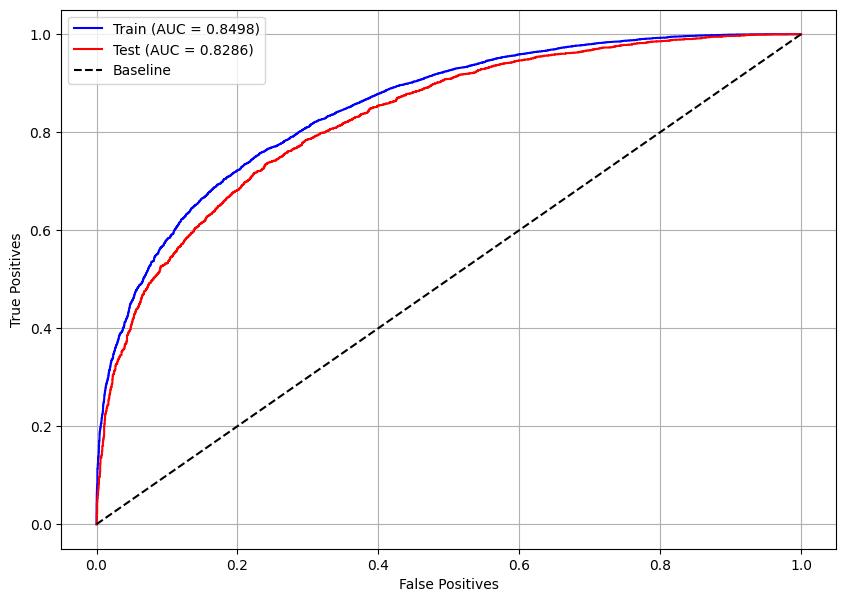

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

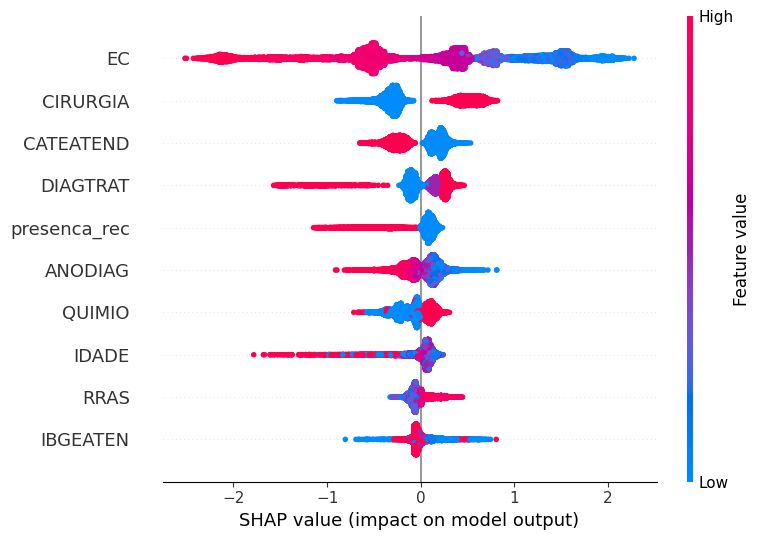

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

##### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 129,
 'max_depth': 4,
 'learning_rate': 0.13,
 'min_child_weight': 7,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.16, 1.18, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

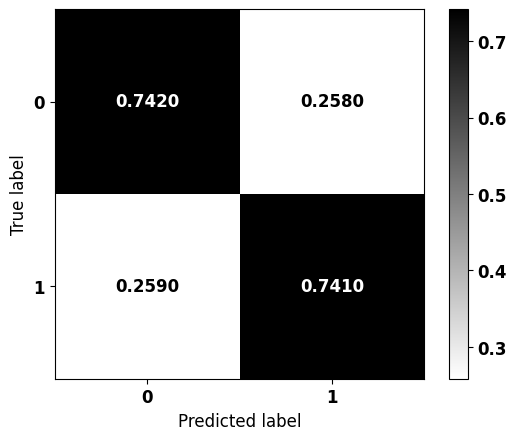


              precision    recall  f1-score   support

           0     0.6840    0.7420    0.7118      2310
           1     0.7918    0.7410    0.7655      3058

    accuracy                         0.7414      5368
   macro avg     0.7379    0.7415    0.7387      5368
weighted avg     0.7454    0.7414    0.7424      5368



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.173, 1:1}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

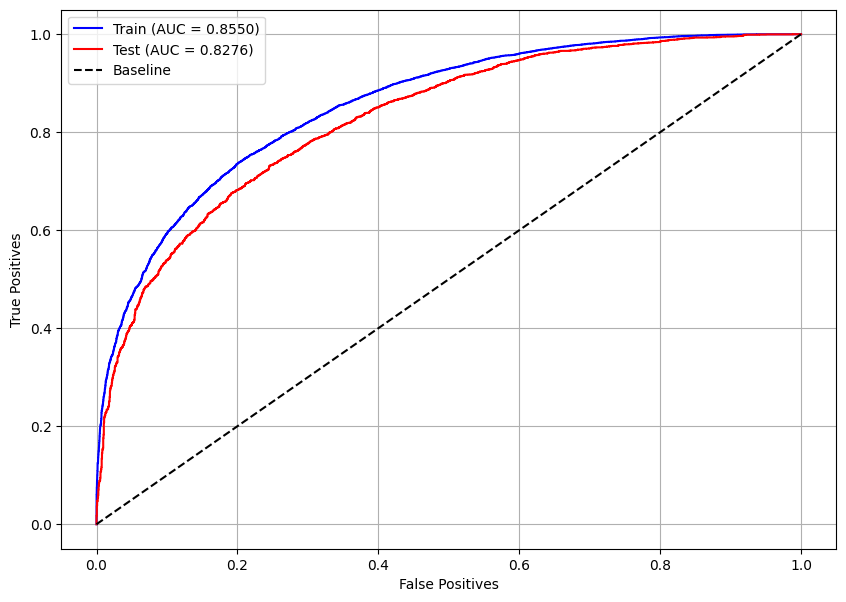

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

##### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 125,
 'max_depth': 4,
 'learning_rate': 0.18,
 'min_child_weight': 1,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(1.17, 1.19, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

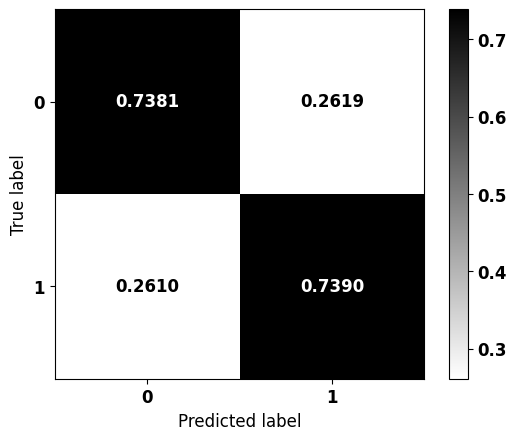


              precision    recall  f1-score   support

           0     0.6812    0.7381    0.7085      2310
           1     0.7888    0.7390    0.7631      3058

    accuracy                         0.7386      5368
   macro avg     0.7350    0.7386    0.7358      5368
weighted avg     0.7425    0.7386    0.7396      5368



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.1715, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

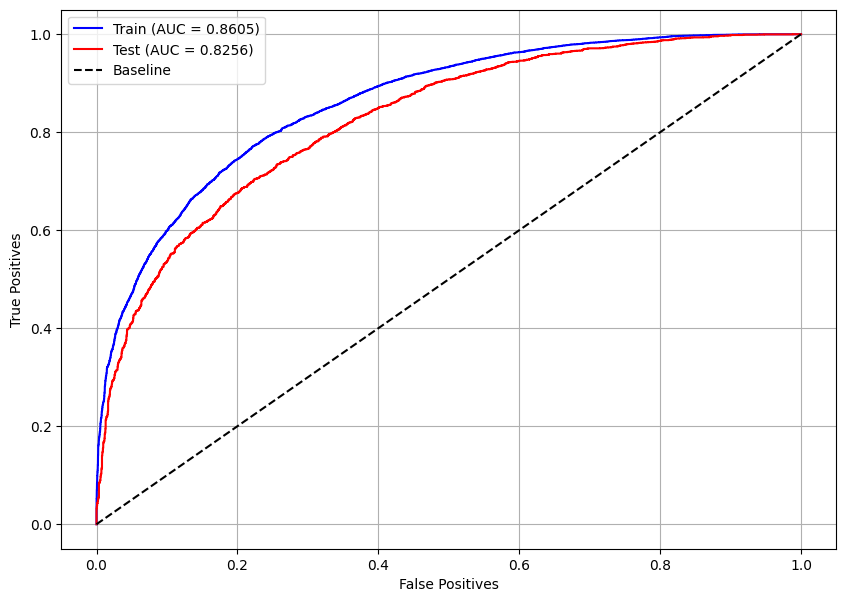

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

##### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 125,
 'max_depth': 4,
 'learning_rate': 0.14,
 'min_child_weight': 7,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.17, 1.19, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

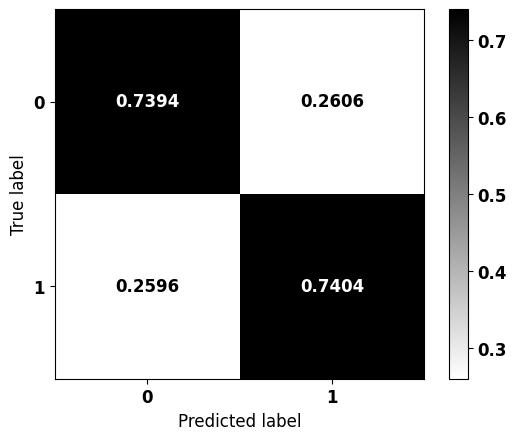


              precision    recall  f1-score   support

           0     0.6827    0.7394    0.7099      2310
           1     0.7900    0.7404    0.7643      3058

    accuracy                         0.7399      5368
   macro avg     0.7363    0.7399    0.7371      5368
weighted avg     0.7438    0.7399    0.7409      5368



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.1713, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

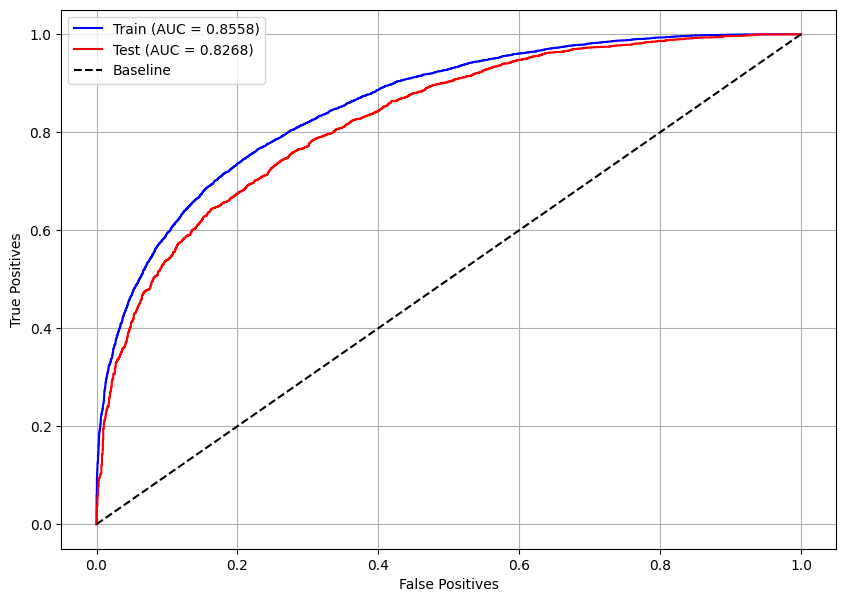

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

##### Modelo Otimizado

In [ ]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1.173, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.13, max_depth=4, min_child_weight=7,
               n_estimators=129, random_state=7, verbose=-1)


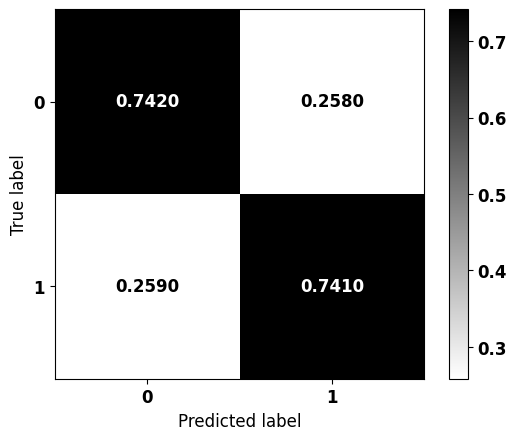


              precision    recall  f1-score   support

           0     0.6840    0.7420    0.7118      2310
           1     0.7918    0.7410    0.7655      3058

    accuracy                         0.7414      5368
   macro avg     0.7379    0.7415    0.7387      5368
weighted avg     0.7454    0.7414    0.7424      5368



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

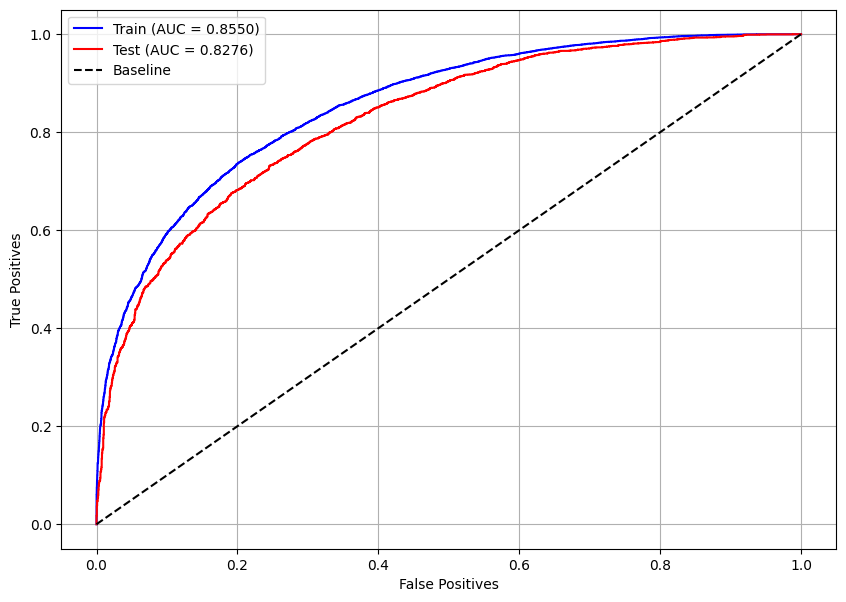

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


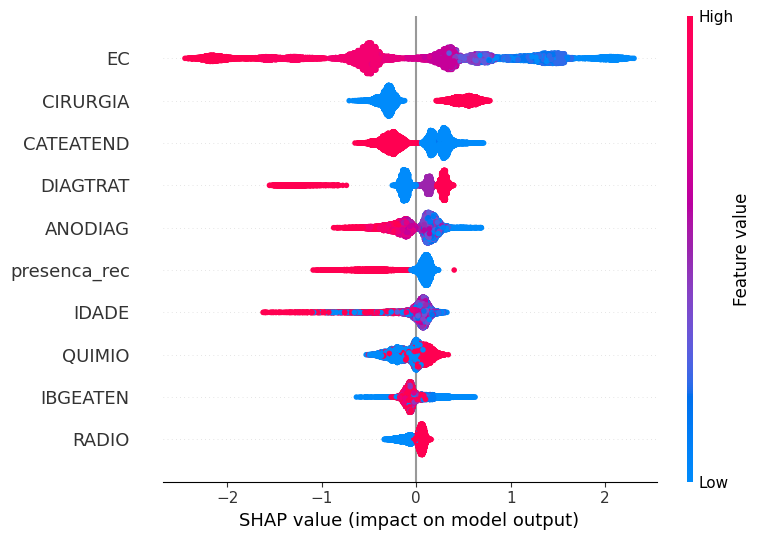

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7360, Optuna = 0.7424

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7444, Optuna = 0.7414

Modelo inicial venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1.154, 1: 1}, importance_type='gain',
               max_depth=4, random_state=7, verbose=-1)

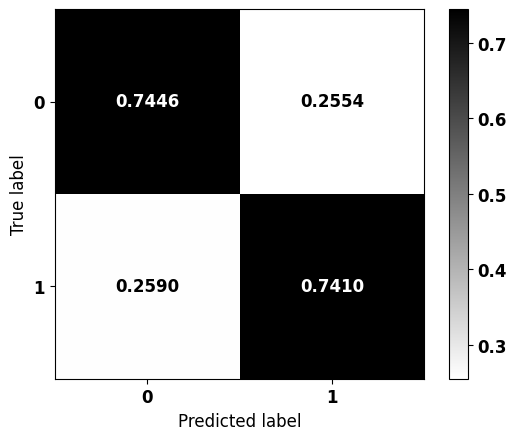


              precision    recall  f1-score   support

           0     0.6847    0.7446    0.7134      2310
           1     0.7934    0.7410    0.7663      3058

    accuracy                         0.7425      5368
   macro avg     0.7391    0.7428    0.7399      5368
weighted avg     0.7466    0.7425    0.7435      5368



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

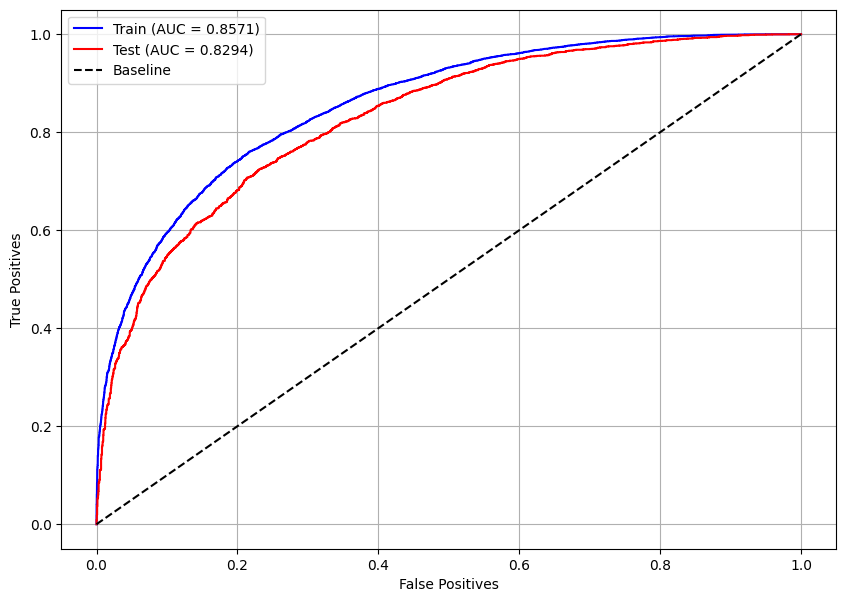

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1.154, 1: 1}, importance_type='gain',
               max_depth=4, random_state=7, verbose=-1)


In [ ]:
# Dados para testar
!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF # Mais incidentes - Teste

df_teste = pd.read_csv('incid_teste.csv')

mama_teste = df_teste[df_teste.TOPOGRUP.isin(['Mama'])]
pele_teste = df_teste[df_teste.TOPOGRUP.isin(['Pele'])]
prost_teste = df_teste[df_teste.TOPOGRUP.isin(['Próstata'])]
colo_teste = df_teste[df_teste.TOPOGRUP.isin(['Colorretal'])]
pulm_teste = df_teste[df_teste.TOPOGRUP.isin(['Pulmão'])]
colo_utero_teste = df_teste[df_teste.TOPOGRUP.isin(['Colo de Útero'])]

mama_teste.shape, pele_teste.shape, prost_teste.shape, colo_teste.shape, pulm_teste.shape, colo_utero_teste.shape

Downloading...
From: https://drive.google.com/uc?id=194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF
To: /content/incid_teste.csv
100% 46.4M/46.4M [00:00<00:00, 133MB/s]


((26133, 25), (25221, 25), (20862, 25), (14028, 25), (9252, 25), (5368, 25))

### **Mama**

In [ ]:
saida_mama = mama_teste.sobrevida_3anos
mama_teste = mama_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(mama_teste.shape)
mama_teste.head(3)

(26133, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
2  -0.623264  0.078323 -0.758504   1.270371 -0.915765 -1.584428    0.5453   
10 -0.549923  0.078323  1.068808  -0.747659 -0.915765 -0.339226    0.5453   
11  0.110146  0.078323  0.854448   1.270371 -0.915765 -1.584428    0.5453   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
2   1.015205 -1.536653  0.848079  ...  2.956862 -0.190274 -0.446767 -0.851058   
10  1.015205  0.650765  0.848079  ...  2.956862 -0.190274 -1.367290  1.932872   
11  1.015205  0.650765  0.848079  ...  1.273530 -0.190274 -1.735499 -0.851058   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
2  -0.888302  0.743452 -0.803767          0.967430           -1.048322   
10 -0.205138 -1.642306 -0.803767         -0.940442           -1.048322   
11 -0.660580  0.743452  0.599581          1.921366            0.953905   

    presenca_rec  
2       -0.51497  
10      -0.51497  
11      -0.51497  

[3 rows x 23 columns]

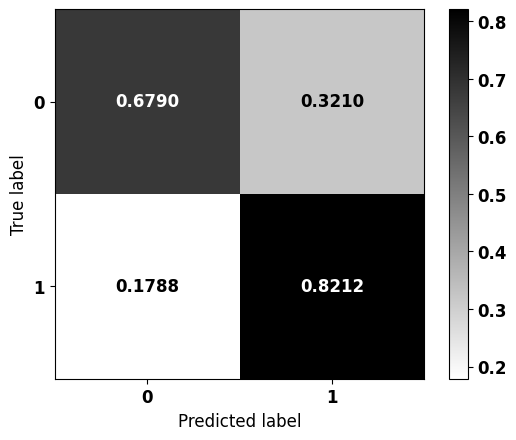


              precision    recall  f1-score   support

           0     0.4842    0.6790    0.5653      5180
           1     0.9119    0.8212    0.8641     20953

    accuracy                         0.7930     26133
   macro avg     0.6980    0.7501    0.7147     26133
weighted avg     0.8271    0.7930    0.8049     26133



In [ ]:
plot_confusion_matrix(best, mama_teste, saida_mama)

### **Pele**

In [ ]:
saida_pele = pele_teste.sobrevida_3anos
pele_teste = pele_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pele_teste.shape)
pele_teste.head(3)

(25221, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
4  0.324125 -0.916019 -0.841077   1.167751 -0.344597 -0.429061  0.315561   
5  0.701083 -0.916019  0.447649   1.167751 -0.344597 -0.429061  0.315561   
7 -0.052834 -0.916019  0.069663  -0.808623 -0.344597 -0.429061  0.315561   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
4 -0.242155 -0.156064  -0.03833  ...  0.591376  -0.20941 -0.716428  1.436258   
5 -0.242155 -0.156064  -0.03833  ... -0.689569  -0.20941  0.240058 -0.214815   
7 -0.242155 -0.156064  -0.03833  ...  1.872320  -0.20941  0.813950 -0.398268   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
4  0.636483 -1.212419  0.393904         -1.404163           -0.776427   
5 -0.234417 -1.110069 -1.165675          1.588451           -0.776427   
7  0.926783 -1.212419  0.393904         -0.406625           -0.776427   

   presenca_rec  
4     -0.218179  
5     -0.218179  
7     -0.218179  

[3 rows x 23 columns]

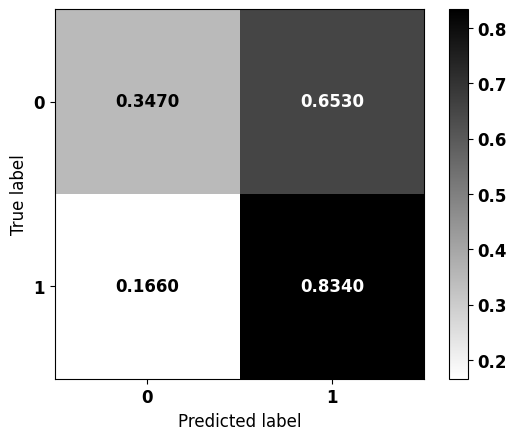


              precision    recall  f1-score   support

           0     0.3843    0.3470    0.3647      5799
           1     0.8105    0.8340    0.8221     19422

    accuracy                         0.7220     25221
   macro avg     0.5974    0.5905    0.5934     25221
weighted avg     0.7125    0.7220    0.7169     25221



In [ ]:
plot_confusion_matrix(best, pele_teste, saida_pele)

### **Próstata**

In [ ]:
saida_prost = prost_teste.sobrevida_3anos
prost_teste = prost_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(prost_teste.shape)
prost_teste.head(3)

(20862, 23)


IDADE  SEXO      IBGE  CATEATEND  DIAGPREV       EC  CIRURGIA  \
3   0.149237   0.0  1.316000  -0.695899  0.723032 -0.63168 -0.879627   
12 -1.225865   0.0  0.958232  -0.695899  0.723032  0.27992  1.136845   
18 -0.423722   0.0 -0.370160  -0.695899  0.723032 -1.99908 -0.879627   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
3   1.381841 -0.308078  1.085991  ... -0.418644 -0.208982  0.051988  0.032404   
12 -0.723672 -0.308078 -0.920818  ... -0.418644 -0.208982  0.841591 -1.029723   
18  1.381841 -0.308078 -0.920818  ... -0.418644 -0.208982  1.236393  0.032404   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
3   1.523967 -0.540997 -0.971798         -0.714113           -0.906043   
12 -0.860966  0.842650  0.451912          0.355595            1.103700   
18  1.523967 -0.540997 -0.971798          1.425303           -0.906043   

    presenca_rec  
3      -0.414926  
12     -0.414926  
18     -0.414926  

[3 rows x 23 columns]

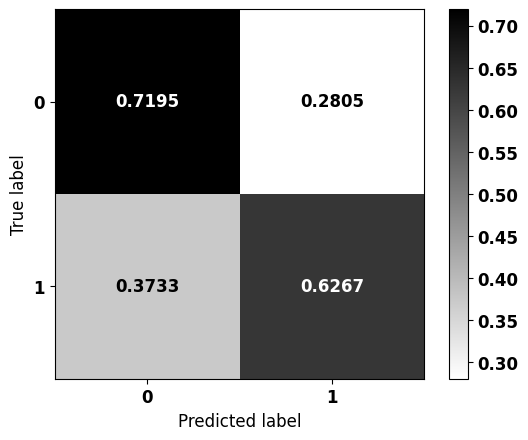


              precision    recall  f1-score   support

           0     0.2707    0.7195    0.3934      3369
           1     0.9206    0.6267    0.7457     17493

    accuracy                         0.6416     20862
   macro avg     0.5957    0.6731    0.5695     20862
weighted avg     0.8157    0.6416    0.6888     20862



In [ ]:
plot_confusion_matrix(best, prost_teste, saida_prost)

### **Colorretal**

In [ ]:
saida_colo = colo_teste.sobrevida_3anos
colo_teste = colo_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(colo_teste.shape)
colo_teste.head(3)

(14028, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
0  0.366829 -0.972134  1.141405   1.343451  0.958036 -0.047542   0.60093   
1 -0.166349 -0.972134 -0.649610   1.343451  0.958036 -0.873817   0.60093   
6 -0.318686 -0.972134 -1.770966  -0.714301  0.958036  1.329585   0.60093   

      RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
0 -0.567847  0.737288  -0.07854  ... -0.325938 -0.193018 -1.734289  1.587885   
1  1.761039  0.737288  -0.07854  ... -0.325938 -0.143566 -0.209650  1.767959   
6 -0.567847  0.737288  -0.07854  ... -0.325938 -0.193018  1.314989 -0.032782   

       RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
0  0.660606 -1.716753  0.396181          1.180668            -1.03687   
1 -0.282288  0.900562 -0.968850          0.154944            -1.03687   
6 -0.046564 -0.607175  0.396181          2.206391            -1.03687   

   presenca_rec  
0     -0.475073  
1     -0.475073  
6     -0.475073  

[3 rows x 23 columns]

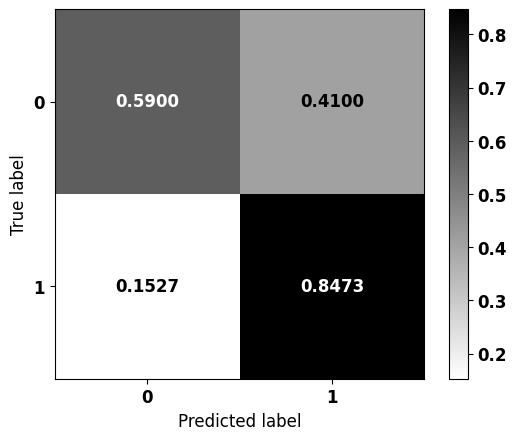


              precision    recall  f1-score   support

           0     0.7576    0.5900    0.6634      6273
           1     0.7187    0.8473    0.7777      7755

    accuracy                         0.7322     14028
   macro avg     0.7382    0.7187    0.7206     14028
weighted avg     0.7361    0.7322    0.7266     14028



In [ ]:
plot_confusion_matrix(best, colo_teste, saida_colo)

### **Pulmão**

In [ ]:
saida_pulm = pulm_teste.sobrevida_3anos
pulm_teste = pulm_teste.drop(columns=['TOPOGRUP', 'sobrevida_3anos'])
print(pulm_teste.shape)
pulm_teste.head(3)

(9252, 23)


IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
8  -0.805560 -0.778211  0.751797  -0.853227  1.364883 -0.536078 -0.468319   
27  0.123762  1.284999  0.990635  -0.853227  1.364883  0.640728 -0.468319   
33  0.960153 -0.778211  0.844979   1.133388 -0.732664 -2.889689  2.135297   

       RADIO    QUIMIO  HORMONIO  ...  CONSDIAG  DIAGTRAT   ANODIAG       DRS  \
8  -0.748999 -1.335116 -0.070691  ... -0.403143 -0.432328  0.663596 -0.846783   
27 -0.748999  0.748999 -0.070691  ... -0.403143 -0.459489  1.022562 -0.846783   
33 -0.748999 -1.335116 -0.070691  ...  1.394771 -0.459489  0.304629 -0.846783   

        RRAS  IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
8  -1.881064  0.667417 -1.225737          0.274789            0.973507   
27 -1.171009  0.755208  0.238090          0.274789           -1.027214   
33 -0.697638  0.755208  0.238090         -0.775222            0.973507   

    presenca_rec  
8      -0.407845  
27      2.451912  
33      2.451912  

[3 rows x 23 columns]

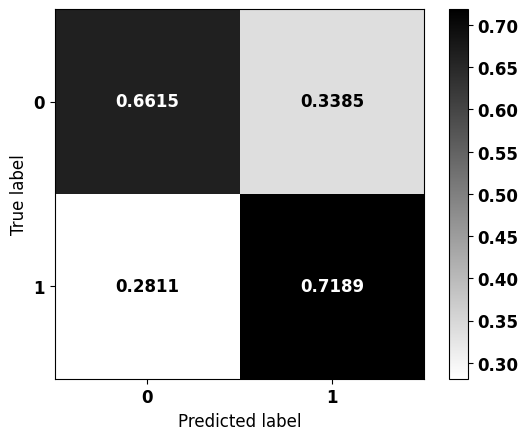


              precision    recall  f1-score   support

           0     0.9380    0.6615    0.7759      8007
           1     0.2483    0.7189    0.3691      1245

    accuracy                         0.6693      9252
   macro avg     0.5931    0.6902    0.5725      9252
weighted avg     0.8452    0.6693    0.7211      9252



In [ ]:
plot_confusion_matrix(best, pulm_teste, saida_pulm)

# **DF treino e teste**

Treino

In [ ]:
from sklearn.utils import shuffle

df_incid_treino = pd.concat([pulm_treino, prost_treino, pele_treino, mama_treino,
                             colo_utero_treino, colo_treino],
                            ignore_index=True)
df_incid_treino = shuffle(df_incid_treino, random_state=seed)
df_incid_treino.head(3)

IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
263928  0.900006  1.028664 -1.095067  -0.714301  0.958036  1.605010 -1.664088   
224467  2.017011  0.078323  0.709472   1.270371 -0.915765 -1.584428  0.545300   
92288   0.474908  1.091681 -0.572151   1.167751 -0.344597  1.142798  0.315561   

           RADIO    QUIMIO  HORMONIO  ...   ANODIAG       DRS      RRAS  \
263928 -0.567847  0.737288 -0.078540  ...  0.933829  0.327366  0.896330   
224467  1.015205 -1.536653  0.848079  ... -1.183185 -0.851058 -1.799187   
92288  -0.242155 -0.156064 -0.038330  ... -1.672914 -0.765173  0.926783   

        IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  \
263928 -1.117133  0.396181          0.154944            0.964441   
224467  0.743452  0.599581         -0.940442           -1.048322   
92288  -0.202185  0.393904         -0.406625           -0.776427   

        presenca_rec    TOPOGRUP  sobrevida_3anos  
263928     -0.475073  Colorretal                0  
224467     -0.514970        Mama                1  
92288      -0.218179        Pele                1  

[3 rows x 25 columns]

In [ ]:
df_incid_treino.shape

(302582, 25)

In [ ]:
df_incid_treino.TOPOGRUP.unique()

array(['Colorretal', 'Mama', 'Pele', 'Próstata', 'Colo de Útero',
       'Pulmão'], dtype=object)

In [ ]:
df_incid_treino.to_csv('incid_treino.csv', index=False, encoding='UTF-8')

Teste

In [ ]:
from sklearn.utils import shuffle

df_incid_teste = pd.concat([pulm_teste, prost_teste, pele_teste, mama_teste,
                            colo_utero_teste, colo_teste],
                           ignore_index=True)
df_incid_teste = shuffle(df_incid_teste, random_state=seed)
df_incid_teste.head(3)

IDADE      SEXO      IBGE  CATEATEND  DIAGPREV        EC  CIRURGIA  \
90021  0.366829 -0.972134  1.141405   1.343451  0.958036 -0.047542   0.60093   
87293 -0.166349 -0.972134 -0.649610   1.343451  0.958036 -0.873817   0.60093   
77594 -0.623264  0.078323 -0.758504   1.270371 -0.915765 -1.584428   0.54530   

          RADIO    QUIMIO  HORMONIO  ...   ANODIAG       DRS      RRAS  \
90021 -0.567847  0.737288 -0.078540  ... -1.734289  1.587885  0.660606   
87293  1.761039  0.737288 -0.078540  ... -0.209650  1.767959 -0.282288   
77594  1.015205 -1.536653  0.848079  ... -0.446767 -0.851058 -0.888302   

       IBGEATEN  HABILIT2  ESCOLARI_preench  IBGE_idem_IBGEATEN  presenca_rec  \
90021 -1.716753  0.396181          1.180668           -1.036870     -0.475073   
87293  0.900562 -0.968850          0.154944           -1.036870     -0.475073   
77594  0.743452 -0.803767          0.967430           -1.048322     -0.514970   

         TOPOGRUP  sobrevida_3anos  
90021  Colorretal                1  
87293  Colorretal                1  
77594        Mama                1  

[3 rows x 25 columns]

In [ ]:
df_incid_teste.shape

(100864, 25)

In [ ]:
df_incid_teste.TOPOGRUP.unique()

array(['Colorretal', 'Mama', 'Próstata', 'Pele', 'Pulmão',
       'Colo de Útero'], dtype=object)

In [ ]:
df_incid_teste.to_csv('incid_teste.csv', index=False, encoding='UTF-8')